In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
from catboost import CatBoostRegressor
import numpy as np
from sklearn.model_selection import KFold

In [2]:
categorical_vars = ['reservationstatusid_code', 'room_type_booked_code', 'member_age_buckets', 'state_code_resort',
                    'state_code_residence', 'season_holidayed_code', 'resort_id']

In [23]:
def format_data(inp_df):

    inp_df["checkin_date"] = pd.to_datetime(inp_df['checkin_date'],format="%d/%m/%Y")
    inp_df["checkout_date"] = pd.to_datetime(inp_df['checkout_date'],format="%d/%m/%Y")
    inp_df["booking_date"] = pd.to_datetime(inp_df['booking_date'],format="%d/%m/%Y")
    #inp_df["checkin_date"] = inp_df.apply(lambda row: datetime.strptime(row['checkin_date'], '%d/%m/%Y'), axis=1)
    #inp_df["checkout_date"] = inp_df.apply(lambda row: datetime.strptime(row['checkout_date'], '%d/%m/%Y'), axis=1)
    #inp_df["booking_date"] = inp_df.apply(lambda row: datetime.strptime(row['booking_date'], '%d/%m/%Y'), axis=1)
    inp_df["advance_booking"] = (inp_df['checkin_date'] - inp_df["booking_date"]).dt.days
    inp_df["days_stayed"] = (inp_df['checkout_date'] - inp_df['checkin_date']).dt.days
    #print(inp_df["checkin_date"][0])
    def get_weekdays(row):
        return np.busday_count(str(datetime.strftime(row['checkin_date'], '%Y-%m-%d')),
                        str(datetime.strftime(row['checkout_date'], '%Y-%m-%d')))
    
    inp_df["weekdays_stayed"] = inp_df.apply(get_weekdays ,axis=1)
        
    inp_df["weekends_stayed"] = inp_df["days_stayed"] - inp_df["weekdays_stayed"]
    inp_df["dropped_days"] = inp_df["roomnights"] - inp_df["days_stayed"]
    inp_df["checkin_month"] = inp_df['checkin_date'].dt.month
    inp_df["is_vacation"] = inp_df.apply(lambda x: 1 if x["checkin_month"] in [12,1,4,5] else 0, axis=1)
    inp_df["checkin_week"] = inp_df['checkin_date'].dt.week
    inp_df["checkin_year"] = inp_df['checkin_date'].dt.year
    inp_df["checkout_month"] = inp_df['checkout_date'].dt.month
    inp_df["total_pax_days"] = inp_df['days_stayed'] * inp_df['total_pax']

    calc_mean = inp_df.groupby(['resort_id'], axis=0).agg(
        {"total_pax":"mean","days_stayed":"mean","advance_booking":"mean","total_pax_days":"mean"}).reset_index()
    calc_mean.columns = ['resort_id','totalpax_mean',"days_stayed_resmean","advance_booking_resmean","totpaxdays_resmean"]
    inp_df = inp_df.merge(calc_mean,on=['resort_id'],how='left')

    calc_mean = inp_df.groupby(['resort_id','checkin_month'], axis=0).agg(
        {"total_pax":"mean"}).reset_index()
    calc_mean.columns = ['resort_id','checkin_month','totalpax_chkmean']
    inp_df = inp_df.merge(calc_mean,on=['resort_id','checkin_month'],how='left')

    calc_mean = inp_df.groupby(['memberid'], axis=0).agg(
        {"total_pax":"mean","days_stayed":"mean","advance_booking":"mean","reservation_id":"count",
         "roomnights":"mean","numberofadults":"mean","numberofchildren":"mean","weekends_stayed":"mean", "weekdays_stayed":"mean",
         "total_pax_days":"mean"}).reset_index()
    calc_mean.columns = ['memberid','totalpax_memmean',"days_stayed_memmean","advance_booking_memmean",
                         "res_memcnt","roomnights_memmean","adults_memmean","child_memmean","weekends_memmean","weekdays_memmean",
                         "totpaxdays_memmean"]
    inp_df = inp_df.merge(calc_mean,on=['memberid'],how='left')

    calc_mean = inp_df.groupby(['memberid'], axis=0).agg(
        {"days_stayed":"sum","advance_booking":"sum","total_pax":"sum","numberofadults":"sum","numberofchildren":"sum",
         "weekends_stayed":"sum","total_pax_days":"sum"}).reset_index()
    calc_mean.columns = ['memberid',"days_stayed_memsum","advance_booking_memsum","total_pax_memsum","adults_memsum","child_memsum",
                         "weekend_memsum","totpaxdays_memsum"]
    inp_df = inp_df.merge(calc_mean,on=['memberid'],how='left')

    calc_mean = inp_df.groupby(['memberid','resort_id'], axis=0).agg(
        {"total_pax":"mean","days_stayed":"mean","roomnights":"mean","reservation_id":"count","total_pax_days":"mean"}).reset_index()
    calc_mean.columns = ['memberid','resort_id','totalpax_memresmean',"days_stayed_memresmean","roomnights_memresmean",
                         "book_memrescnt","totpaxdays_memresmean"]
    inp_df = inp_df.merge(calc_mean,on=['memberid','resort_id'],how='left')

    calc_mean = inp_df.groupby(['memberid','resort_id','checkin_month'], axis=0).agg(
        {"total_pax":"mean","reservation_id":"count","total_pax_days":"mean"}).reset_index()
    calc_mean.columns = ['memberid','resort_id','checkin_month','totalpax_memreschkmean',
                         "book_memreschkcnt","totpaxdays_memreschkmean"]
    inp_df = inp_df.merge(calc_mean,on=['memberid','resort_id','checkin_month'],how='left')

    inp_df["passengers_dropped"] = inp_df["total_pax"] - (inp_df["numberofadults"] + inp_df["numberofchildren"])
    drop = ['checkin_date','checkout_date','booking_date','memberid']
    inp_df = inp_df.drop(drop, axis=1)
    inp_df = inp_df.fillna(-1)
    column_names = inp_df.columns
    for i in column_names:
        if inp_df[i].dtype == 'object' and i not in ['reservation_id','type']:
            lbl = LabelEncoder()
            lbl.fit(list(inp_df[i].values))
            inp_df[i] = lbl.transform(list(inp_df[i].values))

    for var in categorical_vars:
        inp_df[var] = inp_df[var].astype('category')
    return inp_df

In [24]:
def remove_outliers(inp_df):
    inp_df = inp_df.drop(inp_df[inp_df['roomnights'] < 0].index)
    inp_df = inp_df.drop(inp_df[inp_df['advance_booking'] < 0].index)
    inp_df = inp_df.drop(inp_df[inp_df['days_stayed'] < 0].index)
    inp_df = inp_df.drop(inp_df[(inp_df["numberofadults"] + inp_df["numberofchildren"]) == 0].index)
    inp_df = inp_df.drop(inp_df[inp_df['total_pax'] == 0].index)

    return inp_df

In [25]:
train = pd.read_csv("data/train.csv")
train['type'] = "train"
test = pd.read_csv("data/test.csv")
test["amount_spent_per_room_night_scaled"] = 0
test["type"] = "test"
final_df = pd.concat([train,test],axis=0)

In [26]:
final_df = format_data(final_df)

In [27]:
pd.set_option('display.max_columns', None)

In [28]:
final_df.head()

,reservation_id,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,type,advance_booking,days_stayed,weekdays_stayed,weekends_stayed,dropped_days,checkin_month,is_vacation,checkin_week,checkin_year,checkout_month,total_pax_days,totalpax_mean,days_stayed_resmean,advance_booking_resmean,totpaxdays_resmean,totalpax_chkmean,totalpax_memmean,days_stayed_memmean,advance_booking_memmean,res_memcnt,roomnights_memmean,adults_memmean,child_memmean,weekends_memmean,weekdays_memmean,totpaxdays_memmean,days_stayed_memsum,advance_booking_memsum,total_pax_memsum,adults_memsum,child_memsum,weekend_memsum,totpaxdays_memsum,totalpax_memresmean,days_stayed_memresmean,roomnights_memresmean,book_memrescnt,totpaxdays_memresmean,totalpax_memreschkmean,book_memreschkcnt,totpaxdays_memreschkmean,passengers_dropped
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,5,1,5,2,7,7.706428,train,0,1,1,0,0,4,1,14,2018,4,3,3.431176,2.565248,46.943868,8.730783,3.402844,2.357143,3.0,40.142857,14,3.357143,2.0,0.285714,0.642857,2.357143,7.142857,42,562,33,28,4,9,100,3.000000,1.0,1.0,1,3.000000,3.0,1,3.0,1
1,03930f033646d073462b35d411616323597715ac4fc398...,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,5,1,5,0,1,6.662563,train,78,5,3,2,0,4,1,15,2015,4,10,2.677017,2.461738,48.188125,6.553203,2.734127,2.357143,3.0,40.142857,14,3.357143,2.0,0.285714,0.642857,2.357143,7.142857,42,562,33,28,4,9,100,2.000000,5.0,5.0,1,10.000000,2.0,1,10.0,0
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,5,1,4,0,9,7.871602,train,4,4,3,1,0,2,0,5,2015,2,8,3.075815,2.300858,61.734889,7.075472,2.735532,2.357143,3.0,40.142857,14,3.357143,2.0,0.285714,0.642857,2.357143,7.142857,42,562,33,28,4,9,100,2.000000,3.5,4.0,2,7.000000,2.0,1,8.0,0
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,5,1,3,0,25,5.344943,train,40,5,3,2,0,6,0,24,2015,6,10,3.287967,2.790648,55.162534,9.311623,3.422744,2.357143,3.0,40.142857,14,3.357143,2.0,0.285714,0.642857,2.357143,7.142857,42,562,33,28,4,9,100,2.666667,4.0,4.0,3,9.333333,2.0,1,10.0,-2
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,5,1,3,0,25,7.059346,train,103,5,5,0,0,12,1,51,2015,12,10,3.287967,2.790648,55.162534,9.311623,3.330458,2.357143,3.0,40.142857,14,3.357143,2.0,0.285714,0.642857,2.357143,7.142857,42,562,33,28,4,9,100,2.666667,4.0,4.0,3,9.333333,2.0,1,10.0,0


In [29]:
test = final_df[final_df["type"]=="test"]
test = test.drop(['type'],axis=1)
train = final_df[final_df["type"]=="train"]
train = train.drop(['type'],axis=1)
train = remove_outliers(train)

In [30]:
X = train.drop(['reservation_id','amount_spent_per_room_night_scaled'], axis=1)
feature_set = X.columns
X = X.values
y = train['amount_spent_per_room_night_scaled'].values

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [32]:
len(X_train[0])

60

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf

In [14]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [34]:
with tf.device('/device:GPU:0'):
    # Initialising the ANN
    Regressior = Sequential()
    
    # Adding the input layer and the first hidden layer
    Regressior.add(Dense(units=60, kernel_initializer='uniform', activation='relu', input_dim=60))
    
    # Adding the second hidden layer
    Regressior.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
    
    # Adding the third hidden layer
    #Regressior.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
    
    # Adding the output layer
    Regressior.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))
    
    # Compiling the ANN
    Regressior.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Fitting the ANN to the Training set
    Regressior.fit(X_train, y_train, batch_size=2000, epochs=500, validation_split=0.1)

Train on 245784 samples, validate on 27310 samples
Epoch 1/500
245784/245784 [==============================] - 2s 7us/sample - loss: 2.9291 - rmse: 1.1157 - val_loss: 1.1701 - val_rmse: 0.8066
Epoch 2/500
245784/245784 [==============================] - 1s 6us/sample - loss: 1.1625 - rmse: 0.8051 - val_loss: 1.1436 - val_rmse: 0.8007
Epoch 3/500
245784/245784 [==============================] - 1s 6us/sample - loss: 1.1335 - rmse: 0.7930 - val_loss: 1.1099 - val_rmse: 0.7872
Epoch 4/500
245784/245784 [==============================] - 2s 6us/sample - loss: 1.1012 - rmse: 0.7791 - val_loss: 1.0793 - val_rmse: 0.7656
Epoch 5/500
245784/245784 [==============================] - 1s 6us/sample - loss: 1.0761 - rmse: 0.7683 - val_loss: 1.0557 - val_rmse: 0.7551
Epoch 6/500
245784/245784 [==============================] - 1s 6us/sample - loss: 1.0574 - rmse: 0.7603 - val_loss: 1.0427 - val_rmse: 0.7638
Epoch 7/500
245784/245784 [==============================] - 1s 6us/sample - loss: 1.0476 -

245784/245784 [==============================] - 1s 6us/sample - loss: 0.9945 - rmse: 0.7342 - val_loss: 0.9859 - val_rmse: 0.7378
Epoch 58/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9948 - rmse: 0.7345 - val_loss: 0.9903 - val_rmse: 0.7227
Epoch 59/500
245784/245784 [==============================] - 2s 6us/sample - loss: 1.0008 - rmse: 0.7374 - val_loss: 0.9906 - val_rmse: 0.7226
Epoch 60/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9959 - rmse: 0.7346 - val_loss: 0.9959 - val_rmse: 0.7561
Epoch 61/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9960 - rmse: 0.7350 - val_loss: 0.9914 - val_rmse: 0.7263
Epoch 62/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9939 - rmse: 0.7341 - val_loss: 0.9845 - val_rmse: 0.7359
Epoch 63/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9945 - rmse: 0.7343 - val_loss: 0.9845 - val_rmse: 0.7379
Epoch

Epoch 114/500
245784/245784 [==============================] - 2s 7us/sample - loss: 0.9828 - rmse: 0.7290 - val_loss: 0.9726 - val_rmse: 0.7337
Epoch 115/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9780 - rmse: 0.7268 - val_loss: 0.9731 - val_rmse: 0.7370
Epoch 116/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9774 - rmse: 0.7270 - val_loss: 0.9733 - val_rmse: 0.7365
Epoch 117/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9774 - rmse: 0.7267 - val_loss: 0.9805 - val_rmse: 0.7117
Epoch 118/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9837 - rmse: 0.7296 - val_loss: 0.9697 - val_rmse: 0.7220
Epoch 119/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9808 - rmse: 0.7283 - val_loss: 0.9943 - val_rmse: 0.7101
Epoch 120/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9842 - rmse: 0.7294 - val_loss: 0.9710 - va

245784/245784 [==============================] - 2s 6us/sample - loss: 0.9731 - rmse: 0.7251 - val_loss: 0.9742 - val_rmse: 0.7421
Epoch 171/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9745 - rmse: 0.7253 - val_loss: 0.9755 - val_rmse: 0.7478
Epoch 172/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9762 - rmse: 0.7263 - val_loss: 0.9785 - val_rmse: 0.7490
Epoch 173/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9748 - rmse: 0.7257 - val_loss: 0.9784 - val_rmse: 0.7487
Epoch 174/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9707 - rmse: 0.7240 - val_loss: 0.9675 - val_rmse: 0.7283
Epoch 175/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9722 - rmse: 0.7244 - val_loss: 0.9666 - val_rmse: 0.7221
Epoch 176/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9708 - rmse: 0.7239 - val_loss: 0.9770 - val_rmse: 0.7417

245784/245784 [==============================] - 1s 6us/sample - loss: 0.9686 - rmse: 0.7230 - val_loss: 0.9630 - val_rmse: 0.7225
Epoch 227/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9673 - rmse: 0.7223 - val_loss: 0.9662 - val_rmse: 0.7351
Epoch 228/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9677 - rmse: 0.7227 - val_loss: 0.9713 - val_rmse: 0.7349
Epoch 229/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9686 - rmse: 0.7229 - val_loss: 0.9639 - val_rmse: 0.7265
Epoch 230/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9672 - rmse: 0.7228 - val_loss: 0.9667 - val_rmse: 0.7132
Epoch 231/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9702 - rmse: 0.7238 - val_loss: 0.9624 - val_rmse: 0.7220
Epoch 232/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9669 - rmse: 0.7223 - val_loss: 0.9654 - val_rmse: 0.7241

245784/245784 [==============================] - 1s 6us/sample - loss: 0.9704 - rmse: 0.7239 - val_loss: 0.9659 - val_rmse: 0.7127
Epoch 283/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9662 - rmse: 0.7221 - val_loss: 0.9614 - val_rmse: 0.7197
Epoch 284/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9646 - rmse: 0.7213 - val_loss: 0.9620 - val_rmse: 0.7206
Epoch 285/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9657 - rmse: 0.7219 - val_loss: 0.9664 - val_rmse: 0.7118
Epoch 286/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9682 - rmse: 0.7234 - val_loss: 0.9641 - val_rmse: 0.7124
Epoch 287/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9645 - rmse: 0.7211 - val_loss: 0.9635 - val_rmse: 0.7285
Epoch 288/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9645 - rmse: 0.7215 - val_loss: 0.9685 - val_rmse: 0.7154

245784/245784 [==============================] - 1s 6us/sample - loss: 0.9629 - rmse: 0.7209 - val_loss: 0.9627 - val_rmse: 0.7250
Epoch 339/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9635 - rmse: 0.7211 - val_loss: 0.9629 - val_rmse: 0.7305
Epoch 340/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9650 - rmse: 0.7222 - val_loss: 0.9657 - val_rmse: 0.7137
Epoch 341/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9660 - rmse: 0.7223 - val_loss: 0.9625 - val_rmse: 0.7318
Epoch 342/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9607 - rmse: 0.7198 - val_loss: 0.9627 - val_rmse: 0.7131
Epoch 343/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9646 - rmse: 0.7216 - val_loss: 0.9610 - val_rmse: 0.7308
Epoch 344/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9650 - rmse: 0.7217 - val_loss: 0.9932 - val_rmse: 0.7690

245784/245784 [==============================] - 1s 6us/sample - loss: 0.9634 - rmse: 0.7213 - val_loss: 0.9703 - val_rmse: 0.7065
Epoch 395/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9614 - rmse: 0.7202 - val_loss: 0.9631 - val_rmse: 0.7198
Epoch 396/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9627 - rmse: 0.7210 - val_loss: 0.9615 - val_rmse: 0.7302
Epoch 397/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9618 - rmse: 0.7204 - val_loss: 0.9620 - val_rmse: 0.7306
Epoch 398/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9622 - rmse: 0.7209 - val_loss: 0.9625 - val_rmse: 0.7235
Epoch 399/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9727 - rmse: 0.7253 - val_loss: 0.9894 - val_rmse: 0.7623
Epoch 400/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9636 - rmse: 0.7216 - val_loss: 0.9592 - val_rmse: 0.7183

245784/245784 [==============================] - 1s 6us/sample - loss: 0.9642 - rmse: 0.7215 - val_loss: 0.9594 - val_rmse: 0.7161
Epoch 451/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9645 - rmse: 0.7221 - val_loss: 0.9582 - val_rmse: 0.7232
Epoch 452/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9572 - rmse: 0.7187 - val_loss: 0.9597 - val_rmse: 0.7155
Epoch 453/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9608 - rmse: 0.7201 - val_loss: 0.9600 - val_rmse: 0.7190
Epoch 454/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9619 - rmse: 0.7206 - val_loss: 0.9631 - val_rmse: 0.7347
Epoch 455/500
245784/245784 [==============================] - 1s 6us/sample - loss: 0.9586 - rmse: 0.7195 - val_loss: 0.9615 - val_rmse: 0.7101
Epoch 456/500
245784/245784 [==============================] - 2s 6us/sample - loss: 0.9598 - rmse: 0.7196 - val_loss: 0.9576 - val_rmse: 0.7199

In [35]:
y_pred= Regressior.predict(X_test)

In [36]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

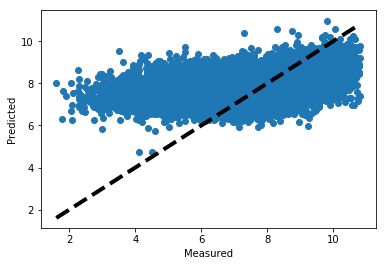

In [37]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [38]:
nrounds = 4000

params = {'metric': 'rmse', 'learning_rate': 0.02, 'max_depth': 6, 'objective': 'regression',"n_estimators": 10000,
          'feature_fraction': 0.9, 'bagging_fraction': 1, 'lambda_l1': 2, 'lambda_l2': 4, 'num_leaves': 600,
          'min_gain_to_split': .1}

xgb_params = {'eta': 0.02, 'max_depth': 6, 'subsample':0.8, 'colsample_bytree': 0.9,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

sub = test[['reservation_id']]
sub['amount_spent_per_room_night_scaled'] = 0
valid = 0
count = 0
kfold = 5

skf = KFold(n_splits=kfold)
skf.get_n_splits(X,y)

for train_index, test_index in skf.split(X,y):
    count = count + 1
    print(' lgb kfold: {}  of  {}'.format(count, 5))
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    lgb_model = lgb.train(params, lgb.Dataset(X_train, label=Y_train), nrounds,
                          lgb.Dataset(X_test, label=Y_test), verbose_eval=50, early_stopping_rounds=50)

    sub['amount_spent_per_room_night_scaled'] += lgb_model.predict(test[feature_set].values,
                                                num_iteration=lgb_model.best_iteration)

    d_train = xgb.DMatrix(X_train, Y_train)
    d_valid = xgb.DMatrix(X_test, Y_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    xgb_model = xgb.train(xgb_params, d_train, nrounds, watchlist, early_stopping_rounds=50,
                          maximize=False, verbose_eval=50)

    sub['amount_spent_per_room_night_scaled'] += xgb_model.predict(xgb.DMatrix(test[feature_set].values),
                                                                   ntree_limit=xgb_model.best_ntree_limit)

    model = CatBoostRegressor(learning_rate=0.02, depth=6, iterations=5000,
                              eval_metric="RMSE", verbose=True,bootstrap_type="Bernoulli")

    fit_model = model.fit(X_train, Y_train, eval_set=(X_test, Y_test), use_best_model=True)

    sub['amount_spent_per_room_night_scaled'] += fit_model.predict(test[feature_set].values)


sub['amount_spent_per_room_night_scaled'] = sub['amount_spent_per_room_night_scaled']/(3 * kfold)
sub.to_csv('data/sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


 lgb kfold: 1  of  5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 0.977065
[100]	valid_0's rmse: 0.955569
[150]	valid_0's rmse: 0.946426
[200]	valid_0's rmse: 0.94172
[250]	valid_0's rmse: 0.938883
[300]	valid_0's rmse: 0.937241
[350]	valid_0's rmse: 0.936243
[400]	valid_0's rmse: 0.935645
[450]	valid_0's rmse: 0.935232
[500]	valid_0's rmse: 0.935023
[550]	valid_0's rmse: 0.934857
[600]	valid_0's rmse: 0.934685
[650]	valid_0's rmse: 0.934562
[700]	valid_0's rmse: 0.934449
[750]	valid_0's rmse: 0.934401
[800]	valid_0's rmse: 0.934335
Early stopping, best iteration is:
[799]	valid_0's rmse: 0.934332


C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[0]	train-rmse:7.1774	valid-rmse:7.08617
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:2.77719	valid-rmse:2.70923
[100]	train-rmse:1.36965	valid-rmse:1.30974
[150]	train-rmse:1.04213	valid-rmse:0.994682
[200]	train-rmse:0.98535	valid-rmse:0.946489
[250]	train-rmse:0.973708	valid-rmse:0.938982
[300]	train-rmse:0.969195	valid-rmse:0.937105
[350]	train-rmse:0.965957	valid-rmse:0.936086
[400]	train-rmse:0.963428	valid-rmse:0.93547
[450]	train-rmse:0.961093	valid-rmse:0.935023
[500]	train-rmse:0.959	valid-rmse:0.934705
[550]	train-rmse:0.956989	valid-rmse:0.934443
[600]	train-rmse:0.955161	valid-rmse:0.934276
[650]	train-rmse:0.953425	valid-rmse:0.934186
[700]	train-rmse:0.951779	valid-rmse:0.934111
[750]	train-rmse:0.950128	valid-rmse:0.934032
[800]	train-rmse:0.948584	valid-rmse:0.934005
Stopping. Best iteration:
[764]	train-rmse:0.949666	valid-rmse:0.933975



C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0:	learn: 7.6623277	test: 7.5711349	best: 7.5711349 (0)	total: 156ms	remaining: 12m 57s
1:	learn: 7.5122414	test: 7.4214368	best: 7.4214368 (1)	total: 199ms	remaining: 8m 18s
2:	learn: 7.3652536	test: 7.2745947	best: 7.2745947 (2)	total: 244ms	remaining: 6m 47s
3:	learn: 7.2211233	test: 7.1306800	best: 7.1306800 (3)	total: 299ms	remaining: 6m 13s
4:	learn: 7.0800606	test: 6.9896853	best: 6.9896853 (4)	total: 349ms	remaining: 5m 48s
5:	learn: 6.9418185	test: 6.8517511	best: 6.8517511 (5)	total: 397ms	remaining: 5m 30s
6:	learn: 6.8064836	test: 6.7164400	best: 6.7164400 (6)	total: 446ms	remaining: 5m 17s
7:	learn: 6.6738933	test: 6.5837181	best: 6.5837181 (7)	total: 498ms	remaining: 5m 10s
8:	learn: 6.5440102	test: 6.4537041	best: 6.4537041 (8)	total: 550ms	remaining: 5m 4s
9:	learn: 6.4168083	test: 6.3263047	best: 6.3263047 (9)	total: 601ms	remaining: 5m
10:	learn: 6.2922306	test: 6.2019284	best: 6.2019284 (10)	total: 661ms	remaining: 4m 59s
11:	learn: 6.1701829	test: 6.0796719	best: 6.

96:	learn: 1.5103318	test: 1.4391532	best: 1.4391532 (96)	total: 5.44s	remaining: 4m 34s
97:	learn: 1.4942164	test: 1.4233139	best: 1.4233139 (97)	total: 5.5s	remaining: 4m 35s
98:	learn: 1.4785531	test: 1.4078437	best: 1.4078437 (98)	total: 5.57s	remaining: 4m 35s
99:	learn: 1.4634981	test: 1.3929074	best: 1.3929074 (99)	total: 5.63s	remaining: 4m 36s
100:	learn: 1.4487937	test: 1.3786878	best: 1.3786878 (100)	total: 5.7s	remaining: 4m 36s
101:	learn: 1.4342372	test: 1.3645567	best: 1.3645567 (101)	total: 5.76s	remaining: 4m 36s
102:	learn: 1.4203855	test: 1.3509676	best: 1.3509676 (102)	total: 5.81s	remaining: 4m 36s
103:	learn: 1.4069423	test: 1.3378311	best: 1.3378311 (103)	total: 5.87s	remaining: 4m 36s
104:	learn: 1.3937610	test: 1.3249840	best: 1.3249840 (104)	total: 5.93s	remaining: 4m 36s
105:	learn: 1.3809465	test: 1.3125655	best: 1.3125655 (105)	total: 6s	remaining: 4m 36s
106:	learn: 1.3685521	test: 1.3004620	best: 1.3004620 (106)	total: 6.06s	remaining: 4m 37s
107:	learn: 

188:	learn: 1.0197186	test: 0.9712732	best: 0.9712732 (188)	total: 10.9s	remaining: 4m 38s
189:	learn: 1.0189232	test: 0.9706197	best: 0.9706197 (189)	total: 11s	remaining: 4m 38s
190:	learn: 1.0181741	test: 0.9699630	best: 0.9699630 (190)	total: 11.1s	remaining: 4m 38s
191:	learn: 1.0174523	test: 0.9693456	best: 0.9693456 (191)	total: 11.1s	remaining: 4m 38s
192:	learn: 1.0167080	test: 0.9687093	best: 0.9687093 (192)	total: 11.2s	remaining: 4m 38s
193:	learn: 1.0160462	test: 0.9681519	best: 0.9681519 (193)	total: 11.2s	remaining: 4m 38s
194:	learn: 1.0153409	test: 0.9675655	best: 0.9675655 (194)	total: 11.3s	remaining: 4m 38s
195:	learn: 1.0146898	test: 0.9670231	best: 0.9670231 (195)	total: 11.4s	remaining: 4m 38s
196:	learn: 1.0140608	test: 0.9664871	best: 0.9664871 (196)	total: 11.4s	remaining: 4m 38s
197:	learn: 1.0134375	test: 0.9659756	best: 0.9659756 (197)	total: 11.5s	remaining: 4m 38s
198:	learn: 1.0128801	test: 0.9655197	best: 0.9655197 (198)	total: 11.6s	remaining: 4m 38s
1

280:	learn: 0.9925824	test: 0.9491873	best: 0.9491873 (280)	total: 16.3s	remaining: 4m 34s
281:	learn: 0.9924995	test: 0.9491247	best: 0.9491247 (281)	total: 16.4s	remaining: 4m 34s
282:	learn: 0.9924094	test: 0.9490537	best: 0.9490537 (282)	total: 16.5s	remaining: 4m 34s
283:	learn: 0.9923228	test: 0.9489711	best: 0.9489711 (283)	total: 16.5s	remaining: 4m 34s
284:	learn: 0.9922143	test: 0.9488697	best: 0.9488697 (284)	total: 16.6s	remaining: 4m 34s
285:	learn: 0.9921247	test: 0.9487958	best: 0.9487958 (285)	total: 16.7s	remaining: 4m 34s
286:	learn: 0.9920189	test: 0.9487156	best: 0.9487156 (286)	total: 16.7s	remaining: 4m 34s
287:	learn: 0.9919431	test: 0.9486495	best: 0.9486495 (287)	total: 16.8s	remaining: 4m 34s
288:	learn: 0.9918623	test: 0.9485743	best: 0.9485743 (288)	total: 16.8s	remaining: 4m 34s
289:	learn: 0.9917878	test: 0.9485174	best: 0.9485174 (289)	total: 16.9s	remaining: 4m 34s
290:	learn: 0.9916658	test: 0.9484184	best: 0.9484184 (290)	total: 16.9s	remaining: 4m 33s

374:	learn: 0.9864994	test: 0.9441067	best: 0.9441067 (374)	total: 22s	remaining: 4m 30s
375:	learn: 0.9864419	test: 0.9440584	best: 0.9440584 (375)	total: 22s	remaining: 4m 30s
376:	learn: 0.9863958	test: 0.9440103	best: 0.9440103 (376)	total: 22.1s	remaining: 4m 30s
377:	learn: 0.9863650	test: 0.9439752	best: 0.9439752 (377)	total: 22.1s	remaining: 4m 30s
378:	learn: 0.9863200	test: 0.9439292	best: 0.9439292 (378)	total: 22.2s	remaining: 4m 30s
379:	learn: 0.9862785	test: 0.9439031	best: 0.9439031 (379)	total: 22.3s	remaining: 4m 30s
380:	learn: 0.9862008	test: 0.9438392	best: 0.9438392 (380)	total: 22.3s	remaining: 4m 30s
381:	learn: 0.9861688	test: 0.9438183	best: 0.9438183 (381)	total: 22.4s	remaining: 4m 30s
382:	learn: 0.9861290	test: 0.9437857	best: 0.9437857 (382)	total: 22.4s	remaining: 4m 30s
383:	learn: 0.9860983	test: 0.9437767	best: 0.9437767 (383)	total: 22.5s	remaining: 4m 30s
384:	learn: 0.9860707	test: 0.9437584	best: 0.9437584 (384)	total: 22.6s	remaining: 4m 30s
385

468:	learn: 0.9831537	test: 0.9413717	best: 0.9413717 (468)	total: 27.5s	remaining: 4m 25s
469:	learn: 0.9831217	test: 0.9413397	best: 0.9413397 (469)	total: 27.5s	remaining: 4m 25s
470:	learn: 0.9830628	test: 0.9412915	best: 0.9412915 (470)	total: 27.6s	remaining: 4m 25s
471:	learn: 0.9830277	test: 0.9412666	best: 0.9412666 (471)	total: 27.6s	remaining: 4m 25s
472:	learn: 0.9830001	test: 0.9412491	best: 0.9412491 (472)	total: 27.7s	remaining: 4m 24s
473:	learn: 0.9829657	test: 0.9412186	best: 0.9412186 (473)	total: 27.7s	remaining: 4m 24s
474:	learn: 0.9829362	test: 0.9411969	best: 0.9411969 (474)	total: 27.8s	remaining: 4m 24s
475:	learn: 0.9829114	test: 0.9411786	best: 0.9411786 (475)	total: 27.9s	remaining: 4m 24s
476:	learn: 0.9828890	test: 0.9411653	best: 0.9411653 (476)	total: 27.9s	remaining: 4m 24s
477:	learn: 0.9828651	test: 0.9411511	best: 0.9411511 (477)	total: 28s	remaining: 4m 24s
478:	learn: 0.9828386	test: 0.9411253	best: 0.9411253 (478)	total: 28s	remaining: 4m 24s
479

562:	learn: 0.9807926	test: 0.9396714	best: 0.9396714 (562)	total: 33s	remaining: 4m 19s
563:	learn: 0.9807666	test: 0.9396567	best: 0.9396567 (563)	total: 33s	remaining: 4m 19s
564:	learn: 0.9807412	test: 0.9396309	best: 0.9396309 (564)	total: 33.1s	remaining: 4m 19s
565:	learn: 0.9807198	test: 0.9396228	best: 0.9396228 (565)	total: 33.1s	remaining: 4m 19s
566:	learn: 0.9807012	test: 0.9396157	best: 0.9396157 (566)	total: 33.2s	remaining: 4m 19s
567:	learn: 0.9806780	test: 0.9396073	best: 0.9396073 (567)	total: 33.2s	remaining: 4m 19s
568:	learn: 0.9806600	test: 0.9395979	best: 0.9395979 (568)	total: 33.3s	remaining: 4m 19s
569:	learn: 0.9806399	test: 0.9395842	best: 0.9395842 (569)	total: 33.4s	remaining: 4m 19s
570:	learn: 0.9806278	test: 0.9395803	best: 0.9395803 (570)	total: 33.4s	remaining: 4m 19s
571:	learn: 0.9806074	test: 0.9395755	best: 0.9395755 (571)	total: 33.5s	remaining: 4m 19s
572:	learn: 0.9805859	test: 0.9395675	best: 0.9395675 (572)	total: 33.5s	remaining: 4m 19s
573

653:	learn: 0.9789751	test: 0.9385759	best: 0.9385759 (653)	total: 38.4s	remaining: 4m 15s
654:	learn: 0.9789577	test: 0.9385621	best: 0.9385621 (654)	total: 38.5s	remaining: 4m 15s
655:	learn: 0.9789375	test: 0.9385487	best: 0.9385487 (655)	total: 38.5s	remaining: 4m 15s
656:	learn: 0.9789216	test: 0.9385409	best: 0.9385409 (656)	total: 38.6s	remaining: 4m 15s
657:	learn: 0.9788989	test: 0.9385263	best: 0.9385263 (657)	total: 38.6s	remaining: 4m 15s
658:	learn: 0.9788754	test: 0.9385128	best: 0.9385128 (658)	total: 38.7s	remaining: 4m 14s
659:	learn: 0.9788558	test: 0.9384992	best: 0.9384992 (659)	total: 38.8s	remaining: 4m 14s
660:	learn: 0.9788410	test: 0.9384852	best: 0.9384852 (660)	total: 38.8s	remaining: 4m 14s
661:	learn: 0.9788253	test: 0.9384804	best: 0.9384804 (661)	total: 38.9s	remaining: 4m 14s
662:	learn: 0.9788083	test: 0.9384680	best: 0.9384680 (662)	total: 38.9s	remaining: 4m 14s
663:	learn: 0.9787945	test: 0.9384594	best: 0.9384594 (663)	total: 39s	remaining: 4m 14s
6

745:	learn: 0.9773242	test: 0.9376833	best: 0.9376833 (745)	total: 43.6s	remaining: 4m 8s
746:	learn: 0.9773099	test: 0.9376762	best: 0.9376762 (746)	total: 43.7s	remaining: 4m 8s
747:	learn: 0.9772940	test: 0.9376715	best: 0.9376715 (747)	total: 43.7s	remaining: 4m 8s
748:	learn: 0.9772675	test: 0.9376598	best: 0.9376598 (748)	total: 43.8s	remaining: 4m 8s
749:	learn: 0.9772519	test: 0.9376509	best: 0.9376509 (749)	total: 43.9s	remaining: 4m 8s
750:	learn: 0.9772364	test: 0.9376434	best: 0.9376434 (750)	total: 43.9s	remaining: 4m 8s
751:	learn: 0.9772216	test: 0.9376419	best: 0.9376419 (751)	total: 44s	remaining: 4m 8s
752:	learn: 0.9772053	test: 0.9376292	best: 0.9376292 (752)	total: 44s	remaining: 4m 8s
753:	learn: 0.9771874	test: 0.9376159	best: 0.9376159 (753)	total: 44.1s	remaining: 4m 8s
754:	learn: 0.9771726	test: 0.9376124	best: 0.9376124 (754)	total: 44.1s	remaining: 4m 8s
755:	learn: 0.9771528	test: 0.9375971	best: 0.9375971 (755)	total: 44.2s	remaining: 4m 8s
756:	learn: 0.

840:	learn: 0.9758590	test: 0.9370867	best: 0.9370867 (840)	total: 49s	remaining: 4m 2s
841:	learn: 0.9758432	test: 0.9370822	best: 0.9370822 (841)	total: 49s	remaining: 4m 2s
842:	learn: 0.9758300	test: 0.9370768	best: 0.9370768 (842)	total: 49.1s	remaining: 4m 2s
843:	learn: 0.9758079	test: 0.9370641	best: 0.9370641 (843)	total: 49.1s	remaining: 4m 1s
844:	learn: 0.9757867	test: 0.9370437	best: 0.9370437 (844)	total: 49.2s	remaining: 4m 1s
845:	learn: 0.9757671	test: 0.9370373	best: 0.9370373 (845)	total: 49.3s	remaining: 4m 1s
846:	learn: 0.9757571	test: 0.9370338	best: 0.9370338 (846)	total: 49.3s	remaining: 4m 1s
847:	learn: 0.9757426	test: 0.9370280	best: 0.9370280 (847)	total: 49.4s	remaining: 4m 1s
848:	learn: 0.9757327	test: 0.9370271	best: 0.9370271 (848)	total: 49.4s	remaining: 4m 1s
849:	learn: 0.9757206	test: 0.9370188	best: 0.9370188 (849)	total: 49.5s	remaining: 4m 1s
850:	learn: 0.9757084	test: 0.9370147	best: 0.9370147 (850)	total: 49.5s	remaining: 4m 1s
851:	learn: 0.

932:	learn: 0.9746230	test: 0.9365580	best: 0.9365580 (932)	total: 54.1s	remaining: 3m 56s
933:	learn: 0.9746152	test: 0.9365523	best: 0.9365523 (933)	total: 54.2s	remaining: 3m 55s
934:	learn: 0.9746047	test: 0.9365457	best: 0.9365457 (934)	total: 54.3s	remaining: 3m 55s
935:	learn: 0.9745977	test: 0.9365456	best: 0.9365456 (935)	total: 54.3s	remaining: 3m 55s
936:	learn: 0.9745859	test: 0.9365420	best: 0.9365420 (936)	total: 54.4s	remaining: 3m 55s
937:	learn: 0.9745722	test: 0.9365350	best: 0.9365350 (937)	total: 54.4s	remaining: 3m 55s
938:	learn: 0.9745570	test: 0.9365274	best: 0.9365274 (938)	total: 54.5s	remaining: 3m 55s
939:	learn: 0.9745373	test: 0.9365151	best: 0.9365151 (939)	total: 54.6s	remaining: 3m 55s
940:	learn: 0.9745236	test: 0.9365102	best: 0.9365102 (940)	total: 54.6s	remaining: 3m 55s
941:	learn: 0.9745074	test: 0.9365031	best: 0.9365031 (941)	total: 54.7s	remaining: 3m 55s
942:	learn: 0.9744939	test: 0.9364947	best: 0.9364947 (942)	total: 54.7s	remaining: 3m 55s

1024:	learn: 0.9734992	test: 0.9361399	best: 0.9361399 (1024)	total: 59.3s	remaining: 3m 49s
1025:	learn: 0.9734850	test: 0.9361382	best: 0.9361382 (1025)	total: 59.4s	remaining: 3m 49s
1026:	learn: 0.9734741	test: 0.9361364	best: 0.9361364 (1026)	total: 59.4s	remaining: 3m 49s
1027:	learn: 0.9734608	test: 0.9361363	best: 0.9361363 (1027)	total: 59.5s	remaining: 3m 49s
1028:	learn: 0.9734498	test: 0.9361348	best: 0.9361348 (1028)	total: 59.5s	remaining: 3m 49s
1029:	learn: 0.9734388	test: 0.9361284	best: 0.9361284 (1029)	total: 59.6s	remaining: 3m 49s
1030:	learn: 0.9734294	test: 0.9361270	best: 0.9361270 (1030)	total: 59.6s	remaining: 3m 49s
1031:	learn: 0.9734198	test: 0.9361247	best: 0.9361247 (1031)	total: 59.7s	remaining: 3m 49s
1032:	learn: 0.9734126	test: 0.9361230	best: 0.9361230 (1032)	total: 59.7s	remaining: 3m 49s
1033:	learn: 0.9734004	test: 0.9361209	best: 0.9361209 (1033)	total: 59.8s	remaining: 3m 49s
1034:	learn: 0.9733832	test: 0.9361119	best: 0.9361119 (1034)	total: 5

1116:	learn: 0.9724508	test: 0.9357987	best: 0.9357987 (1116)	total: 1m 4s	remaining: 3m 43s
1117:	learn: 0.9724429	test: 0.9357977	best: 0.9357977 (1117)	total: 1m 4s	remaining: 3m 43s
1118:	learn: 0.9724302	test: 0.9357938	best: 0.9357938 (1118)	total: 1m 4s	remaining: 3m 43s
1119:	learn: 0.9724158	test: 0.9357858	best: 0.9357858 (1119)	total: 1m 4s	remaining: 3m 43s
1120:	learn: 0.9724057	test: 0.9357843	best: 0.9357843 (1120)	total: 1m 4s	remaining: 3m 43s
1121:	learn: 0.9723940	test: 0.9357809	best: 0.9357809 (1121)	total: 1m 4s	remaining: 3m 43s
1122:	learn: 0.9723813	test: 0.9357752	best: 0.9357752 (1122)	total: 1m 4s	remaining: 3m 43s
1123:	learn: 0.9723742	test: 0.9357749	best: 0.9357749 (1123)	total: 1m 4s	remaining: 3m 43s
1124:	learn: 0.9723623	test: 0.9357746	best: 0.9357746 (1124)	total: 1m 4s	remaining: 3m 43s
1125:	learn: 0.9723486	test: 0.9357653	best: 0.9357653 (1125)	total: 1m 4s	remaining: 3m 43s
1126:	learn: 0.9723371	test: 0.9357673	best: 0.9357653 (1125)	total: 1

1208:	learn: 0.9715229	test: 0.9355705	best: 0.9355701 (1207)	total: 1m 9s	remaining: 3m 37s
1209:	learn: 0.9715110	test: 0.9355743	best: 0.9355701 (1207)	total: 1m 9s	remaining: 3m 37s
1210:	learn: 0.9714975	test: 0.9355728	best: 0.9355701 (1207)	total: 1m 9s	remaining: 3m 37s
1211:	learn: 0.9714909	test: 0.9355736	best: 0.9355701 (1207)	total: 1m 9s	remaining: 3m 37s
1212:	learn: 0.9714746	test: 0.9355659	best: 0.9355659 (1212)	total: 1m 9s	remaining: 3m 37s
1213:	learn: 0.9714702	test: 0.9355627	best: 0.9355627 (1213)	total: 1m 9s	remaining: 3m 36s
1214:	learn: 0.9714581	test: 0.9355573	best: 0.9355573 (1214)	total: 1m 9s	remaining: 3m 36s
1215:	learn: 0.9714484	test: 0.9355550	best: 0.9355550 (1215)	total: 1m 9s	remaining: 3m 36s
1216:	learn: 0.9714395	test: 0.9355510	best: 0.9355510 (1216)	total: 1m 9s	remaining: 3m 36s
1217:	learn: 0.9714228	test: 0.9355458	best: 0.9355458 (1217)	total: 1m 9s	remaining: 3m 36s
1218:	learn: 0.9714064	test: 0.9355375	best: 0.9355375 (1218)	total: 1

1297:	learn: 0.9706084	test: 0.9353304	best: 0.9353304 (1297)	total: 1m 14s	remaining: 3m 31s
1298:	learn: 0.9705998	test: 0.9353294	best: 0.9353294 (1298)	total: 1m 14s	remaining: 3m 31s
1299:	learn: 0.9705902	test: 0.9353255	best: 0.9353255 (1299)	total: 1m 14s	remaining: 3m 31s
1300:	learn: 0.9705851	test: 0.9353254	best: 0.9353254 (1300)	total: 1m 14s	remaining: 3m 31s
1301:	learn: 0.9705786	test: 0.9353262	best: 0.9353254 (1300)	total: 1m 14s	remaining: 3m 31s
1302:	learn: 0.9705649	test: 0.9353229	best: 0.9353229 (1302)	total: 1m 14s	remaining: 3m 31s
1303:	learn: 0.9705506	test: 0.9353235	best: 0.9353229 (1302)	total: 1m 14s	remaining: 3m 31s
1304:	learn: 0.9705407	test: 0.9353248	best: 0.9353229 (1302)	total: 1m 14s	remaining: 3m 31s
1305:	learn: 0.9705284	test: 0.9353247	best: 0.9353229 (1302)	total: 1m 14s	remaining: 3m 30s
1306:	learn: 0.9705196	test: 0.9353243	best: 0.9353229 (1302)	total: 1m 14s	remaining: 3m 30s
1307:	learn: 0.9705127	test: 0.9353255	best: 0.9353229 (1302

1388:	learn: 0.9697161	test: 0.9351952	best: 0.9351952 (1388)	total: 1m 19s	remaining: 3m 25s
1389:	learn: 0.9697044	test: 0.9351920	best: 0.9351920 (1389)	total: 1m 19s	remaining: 3m 25s
1390:	learn: 0.9696974	test: 0.9351885	best: 0.9351885 (1390)	total: 1m 19s	remaining: 3m 25s
1391:	learn: 0.9696880	test: 0.9351858	best: 0.9351858 (1391)	total: 1m 19s	remaining: 3m 25s
1392:	learn: 0.9696784	test: 0.9351789	best: 0.9351789 (1392)	total: 1m 19s	remaining: 3m 25s
1393:	learn: 0.9696678	test: 0.9351790	best: 0.9351789 (1392)	total: 1m 19s	remaining: 3m 25s
1394:	learn: 0.9696577	test: 0.9351728	best: 0.9351728 (1394)	total: 1m 19s	remaining: 3m 25s
1395:	learn: 0.9696467	test: 0.9351663	best: 0.9351663 (1395)	total: 1m 19s	remaining: 3m 25s
1396:	learn: 0.9696378	test: 0.9351663	best: 0.9351663 (1395)	total: 1m 19s	remaining: 3m 25s
1397:	learn: 0.9696282	test: 0.9351612	best: 0.9351612 (1397)	total: 1m 19s	remaining: 3m 25s
1398:	learn: 0.9696224	test: 0.9351603	best: 0.9351603 (1398

1476:	learn: 0.9688976	test: 0.9349936	best: 0.9349931 (1473)	total: 1m 23s	remaining: 3m 20s
1477:	learn: 0.9688873	test: 0.9349878	best: 0.9349878 (1477)	total: 1m 23s	remaining: 3m 20s
1478:	learn: 0.9688743	test: 0.9349836	best: 0.9349836 (1478)	total: 1m 24s	remaining: 3m 20s
1479:	learn: 0.9688672	test: 0.9349831	best: 0.9349831 (1479)	total: 1m 24s	remaining: 3m 19s
1480:	learn: 0.9688575	test: 0.9349939	best: 0.9349831 (1479)	total: 1m 24s	remaining: 3m 19s
1481:	learn: 0.9688470	test: 0.9349932	best: 0.9349831 (1479)	total: 1m 24s	remaining: 3m 19s
1482:	learn: 0.9688413	test: 0.9349922	best: 0.9349831 (1479)	total: 1m 24s	remaining: 3m 19s
1483:	learn: 0.9688298	test: 0.9349872	best: 0.9349831 (1479)	total: 1m 24s	remaining: 3m 19s
1484:	learn: 0.9688205	test: 0.9349905	best: 0.9349831 (1479)	total: 1m 24s	remaining: 3m 19s
1485:	learn: 0.9688124	test: 0.9349911	best: 0.9349831 (1479)	total: 1m 24s	remaining: 3m 19s
1486:	learn: 0.9688051	test: 0.9349878	best: 0.9349831 (1479

1564:	learn: 0.9681440	test: 0.9348707	best: 0.9348707 (1564)	total: 1m 28s	remaining: 3m 14s
1565:	learn: 0.9681391	test: 0.9348702	best: 0.9348702 (1565)	total: 1m 28s	remaining: 3m 14s
1566:	learn: 0.9681296	test: 0.9348686	best: 0.9348686 (1566)	total: 1m 28s	remaining: 3m 14s
1567:	learn: 0.9681174	test: 0.9348707	best: 0.9348686 (1566)	total: 1m 28s	remaining: 3m 14s
1568:	learn: 0.9681083	test: 0.9348731	best: 0.9348686 (1566)	total: 1m 28s	remaining: 3m 14s
1569:	learn: 0.9681001	test: 0.9348700	best: 0.9348686 (1566)	total: 1m 28s	remaining: 3m 14s
1570:	learn: 0.9680906	test: 0.9348675	best: 0.9348675 (1570)	total: 1m 28s	remaining: 3m 14s
1571:	learn: 0.9680802	test: 0.9348670	best: 0.9348670 (1571)	total: 1m 29s	remaining: 3m 14s
1572:	learn: 0.9680716	test: 0.9348643	best: 0.9348643 (1572)	total: 1m 29s	remaining: 3m 14s
1573:	learn: 0.9680669	test: 0.9348633	best: 0.9348633 (1573)	total: 1m 29s	remaining: 3m 13s
1574:	learn: 0.9680614	test: 0.9348653	best: 0.9348633 (1573

1652:	learn: 0.9673775	test: 0.9347626	best: 0.9347626 (1652)	total: 1m 33s	remaining: 3m 9s
1653:	learn: 0.9673715	test: 0.9347687	best: 0.9347626 (1652)	total: 1m 33s	remaining: 3m 9s
1654:	learn: 0.9673592	test: 0.9347741	best: 0.9347626 (1652)	total: 1m 33s	remaining: 3m 9s
1655:	learn: 0.9673497	test: 0.9347741	best: 0.9347626 (1652)	total: 1m 33s	remaining: 3m 9s
1656:	learn: 0.9673369	test: 0.9347675	best: 0.9347626 (1652)	total: 1m 33s	remaining: 3m 8s
1657:	learn: 0.9673249	test: 0.9347646	best: 0.9347626 (1652)	total: 1m 33s	remaining: 3m 8s
1658:	learn: 0.9673148	test: 0.9347597	best: 0.9347597 (1658)	total: 1m 33s	remaining: 3m 8s
1659:	learn: 0.9673032	test: 0.9347536	best: 0.9347536 (1659)	total: 1m 33s	remaining: 3m 8s
1660:	learn: 0.9672946	test: 0.9347495	best: 0.9347495 (1660)	total: 1m 33s	remaining: 3m 8s
1661:	learn: 0.9672857	test: 0.9347477	best: 0.9347477 (1661)	total: 1m 33s	remaining: 3m 8s
1662:	learn: 0.9672765	test: 0.9347458	best: 0.9347458 (1662)	total: 1

1741:	learn: 0.9665834	test: 0.9346260	best: 0.9346260 (1741)	total: 1m 38s	remaining: 3m 4s
1742:	learn: 0.9665761	test: 0.9346241	best: 0.9346241 (1742)	total: 1m 38s	remaining: 3m 4s
1743:	learn: 0.9665711	test: 0.9346261	best: 0.9346241 (1742)	total: 1m 38s	remaining: 3m 4s
1744:	learn: 0.9665632	test: 0.9346272	best: 0.9346241 (1742)	total: 1m 38s	remaining: 3m 4s
1745:	learn: 0.9665563	test: 0.9346263	best: 0.9346241 (1742)	total: 1m 38s	remaining: 3m 4s
1746:	learn: 0.9665486	test: 0.9346241	best: 0.9346241 (1742)	total: 1m 39s	remaining: 3m 4s
1747:	learn: 0.9665428	test: 0.9346235	best: 0.9346235 (1747)	total: 1m 39s	remaining: 3m 4s
1748:	learn: 0.9665295	test: 0.9346266	best: 0.9346235 (1747)	total: 1m 39s	remaining: 3m 4s
1749:	learn: 0.9665193	test: 0.9346205	best: 0.9346205 (1749)	total: 1m 39s	remaining: 3m 4s
1750:	learn: 0.9665087	test: 0.9346173	best: 0.9346173 (1750)	total: 1m 39s	remaining: 3m 4s
1751:	learn: 0.9664994	test: 0.9346193	best: 0.9346173 (1750)	total: 1

1833:	learn: 0.9658258	test: 0.9345038	best: 0.9345037 (1832)	total: 1m 43s	remaining: 2m 59s
1834:	learn: 0.9658186	test: 0.9345052	best: 0.9345037 (1832)	total: 1m 43s	remaining: 2m 59s
1835:	learn: 0.9658148	test: 0.9345037	best: 0.9345037 (1832)	total: 1m 43s	remaining: 2m 59s
1836:	learn: 0.9658052	test: 0.9345080	best: 0.9345037 (1832)	total: 1m 44s	remaining: 2m 59s
1837:	learn: 0.9657945	test: 0.9345089	best: 0.9345037 (1832)	total: 1m 44s	remaining: 2m 59s
1838:	learn: 0.9657840	test: 0.9345016	best: 0.9345016 (1838)	total: 1m 44s	remaining: 2m 59s
1839:	learn: 0.9657727	test: 0.9344965	best: 0.9344965 (1839)	total: 1m 44s	remaining: 2m 58s
1840:	learn: 0.9657630	test: 0.9344978	best: 0.9344965 (1839)	total: 1m 44s	remaining: 2m 58s
1841:	learn: 0.9657533	test: 0.9344965	best: 0.9344965 (1839)	total: 1m 44s	remaining: 2m 58s
1842:	learn: 0.9657445	test: 0.9344971	best: 0.9344965 (1839)	total: 1m 44s	remaining: 2m 58s
1843:	learn: 0.9657357	test: 0.9345000	best: 0.9344965 (1839

1921:	learn: 0.9651112	test: 0.9344072	best: 0.9344072 (1921)	total: 1m 48s	remaining: 2m 54s
1922:	learn: 0.9650985	test: 0.9344069	best: 0.9344069 (1922)	total: 1m 48s	remaining: 2m 54s
1923:	learn: 0.9650944	test: 0.9344073	best: 0.9344069 (1922)	total: 1m 48s	remaining: 2m 53s
1924:	learn: 0.9650878	test: 0.9344072	best: 0.9344069 (1922)	total: 1m 48s	remaining: 2m 53s
1925:	learn: 0.9650772	test: 0.9344050	best: 0.9344050 (1925)	total: 1m 48s	remaining: 2m 53s
1926:	learn: 0.9650698	test: 0.9343999	best: 0.9343999 (1926)	total: 1m 49s	remaining: 2m 53s
1927:	learn: 0.9650612	test: 0.9343945	best: 0.9343945 (1927)	total: 1m 49s	remaining: 2m 53s
1928:	learn: 0.9650488	test: 0.9343899	best: 0.9343899 (1928)	total: 1m 49s	remaining: 2m 53s
1929:	learn: 0.9650345	test: 0.9343944	best: 0.9343899 (1928)	total: 1m 49s	remaining: 2m 53s
1930:	learn: 0.9650225	test: 0.9343882	best: 0.9343882 (1930)	total: 1m 49s	remaining: 2m 53s
1931:	learn: 0.9650129	test: 0.9343880	best: 0.9343880 (1931

2012:	learn: 0.9643885	test: 0.9343220	best: 0.9343215 (2010)	total: 1m 53s	remaining: 2m 48s
2013:	learn: 0.9643799	test: 0.9343196	best: 0.9343196 (2013)	total: 1m 53s	remaining: 2m 48s
2014:	learn: 0.9643740	test: 0.9343184	best: 0.9343184 (2014)	total: 1m 53s	remaining: 2m 48s
2015:	learn: 0.9643647	test: 0.9343160	best: 0.9343160 (2015)	total: 1m 53s	remaining: 2m 48s
2016:	learn: 0.9643517	test: 0.9343153	best: 0.9343153 (2016)	total: 1m 53s	remaining: 2m 48s
2017:	learn: 0.9643471	test: 0.9343158	best: 0.9343153 (2016)	total: 1m 54s	remaining: 2m 48s
2018:	learn: 0.9643389	test: 0.9343171	best: 0.9343153 (2016)	total: 1m 54s	remaining: 2m 48s
2019:	learn: 0.9643261	test: 0.9343124	best: 0.9343124 (2019)	total: 1m 54s	remaining: 2m 48s
2020:	learn: 0.9643160	test: 0.9343020	best: 0.9343020 (2020)	total: 1m 54s	remaining: 2m 48s
2021:	learn: 0.9643103	test: 0.9342970	best: 0.9342970 (2021)	total: 1m 54s	remaining: 2m 48s
2022:	learn: 0.9643040	test: 0.9342958	best: 0.9342958 (2022

2100:	learn: 0.9637025	test: 0.9342400	best: 0.9342397 (2099)	total: 1m 58s	remaining: 2m 43s
2101:	learn: 0.9636946	test: 0.9342414	best: 0.9342397 (2099)	total: 1m 58s	remaining: 2m 43s
2102:	learn: 0.9636855	test: 0.9342412	best: 0.9342397 (2099)	total: 1m 58s	remaining: 2m 43s
2103:	learn: 0.9636812	test: 0.9342401	best: 0.9342397 (2099)	total: 1m 58s	remaining: 2m 43s
2104:	learn: 0.9636736	test: 0.9342391	best: 0.9342391 (2104)	total: 1m 58s	remaining: 2m 43s
2105:	learn: 0.9636658	test: 0.9342339	best: 0.9342339 (2105)	total: 1m 58s	remaining: 2m 43s
2106:	learn: 0.9636569	test: 0.9342316	best: 0.9342316 (2106)	total: 1m 58s	remaining: 2m 43s
2107:	learn: 0.9636459	test: 0.9342319	best: 0.9342316 (2106)	total: 1m 58s	remaining: 2m 43s
2108:	learn: 0.9636343	test: 0.9342318	best: 0.9342316 (2106)	total: 1m 59s	remaining: 2m 43s
2109:	learn: 0.9636274	test: 0.9342294	best: 0.9342294 (2109)	total: 1m 59s	remaining: 2m 43s
2110:	learn: 0.9636223	test: 0.9342243	best: 0.9342243 (2110

2192:	learn: 0.9630065	test: 0.9341564	best: 0.9341564 (2192)	total: 2m 3s	remaining: 2m 38s
2193:	learn: 0.9629971	test: 0.9341568	best: 0.9341564 (2192)	total: 2m 3s	remaining: 2m 38s
2194:	learn: 0.9629887	test: 0.9341527	best: 0.9341527 (2194)	total: 2m 3s	remaining: 2m 38s
2195:	learn: 0.9629798	test: 0.9341552	best: 0.9341527 (2194)	total: 2m 3s	remaining: 2m 38s
2196:	learn: 0.9629687	test: 0.9341503	best: 0.9341503 (2196)	total: 2m 3s	remaining: 2m 37s
2197:	learn: 0.9629599	test: 0.9341496	best: 0.9341496 (2197)	total: 2m 3s	remaining: 2m 37s
2198:	learn: 0.9629551	test: 0.9341476	best: 0.9341476 (2198)	total: 2m 3s	remaining: 2m 37s
2199:	learn: 0.9629500	test: 0.9341482	best: 0.9341476 (2198)	total: 2m 4s	remaining: 2m 37s
2200:	learn: 0.9629413	test: 0.9341509	best: 0.9341476 (2198)	total: 2m 4s	remaining: 2m 37s
2201:	learn: 0.9629355	test: 0.9341489	best: 0.9341476 (2198)	total: 2m 4s	remaining: 2m 37s
2202:	learn: 0.9629264	test: 0.9341421	best: 0.9341421 (2202)	total: 2

2283:	learn: 0.9623340	test: 0.9340852	best: 0.9340843 (2282)	total: 2m 8s	remaining: 2m 33s
2284:	learn: 0.9623231	test: 0.9340901	best: 0.9340843 (2282)	total: 2m 8s	remaining: 2m 33s
2285:	learn: 0.9623178	test: 0.9340865	best: 0.9340843 (2282)	total: 2m 8s	remaining: 2m 32s
2286:	learn: 0.9623119	test: 0.9340887	best: 0.9340843 (2282)	total: 2m 8s	remaining: 2m 32s
2287:	learn: 0.9623045	test: 0.9340877	best: 0.9340843 (2282)	total: 2m 8s	remaining: 2m 32s
2288:	learn: 0.9623002	test: 0.9340866	best: 0.9340843 (2282)	total: 2m 9s	remaining: 2m 32s
2289:	learn: 0.9622956	test: 0.9340862	best: 0.9340843 (2282)	total: 2m 9s	remaining: 2m 32s
2290:	learn: 0.9622867	test: 0.9340849	best: 0.9340843 (2282)	total: 2m 9s	remaining: 2m 32s
2291:	learn: 0.9622795	test: 0.9340834	best: 0.9340834 (2291)	total: 2m 9s	remaining: 2m 32s
2292:	learn: 0.9622717	test: 0.9340836	best: 0.9340834 (2291)	total: 2m 9s	remaining: 2m 32s
2293:	learn: 0.9622624	test: 0.9340808	best: 0.9340808 (2293)	total: 2

2374:	learn: 0.9617077	test: 0.9340669	best: 0.9340669 (2374)	total: 2m 13s	remaining: 2m 27s
2375:	learn: 0.9616951	test: 0.9340716	best: 0.9340669 (2374)	total: 2m 13s	remaining: 2m 27s
2376:	learn: 0.9616912	test: 0.9340682	best: 0.9340669 (2374)	total: 2m 13s	remaining: 2m 27s
2377:	learn: 0.9616852	test: 0.9340710	best: 0.9340669 (2374)	total: 2m 13s	remaining: 2m 27s
2378:	learn: 0.9616753	test: 0.9340682	best: 0.9340669 (2374)	total: 2m 14s	remaining: 2m 27s
2379:	learn: 0.9616653	test: 0.9340672	best: 0.9340669 (2374)	total: 2m 14s	remaining: 2m 27s
2380:	learn: 0.9616558	test: 0.9340623	best: 0.9340623 (2380)	total: 2m 14s	remaining: 2m 27s
2381:	learn: 0.9616485	test: 0.9340621	best: 0.9340621 (2381)	total: 2m 14s	remaining: 2m 27s
2382:	learn: 0.9616432	test: 0.9340622	best: 0.9340621 (2381)	total: 2m 14s	remaining: 2m 27s
2383:	learn: 0.9616381	test: 0.9340617	best: 0.9340617 (2383)	total: 2m 14s	remaining: 2m 27s
2384:	learn: 0.9616305	test: 0.9340635	best: 0.9340617 (2383

2465:	learn: 0.9610208	test: 0.9339714	best: 0.9339695 (2464)	total: 2m 18s	remaining: 2m 22s
2466:	learn: 0.9610135	test: 0.9339707	best: 0.9339695 (2464)	total: 2m 19s	remaining: 2m 22s
2467:	learn: 0.9609994	test: 0.9339659	best: 0.9339659 (2467)	total: 2m 19s	remaining: 2m 22s
2468:	learn: 0.9609919	test: 0.9339662	best: 0.9339659 (2467)	total: 2m 19s	remaining: 2m 22s
2469:	learn: 0.9609885	test: 0.9339655	best: 0.9339655 (2469)	total: 2m 19s	remaining: 2m 22s
2470:	learn: 0.9609799	test: 0.9339610	best: 0.9339610 (2470)	total: 2m 19s	remaining: 2m 22s
2471:	learn: 0.9609731	test: 0.9339577	best: 0.9339577 (2471)	total: 2m 19s	remaining: 2m 22s
2472:	learn: 0.9609669	test: 0.9339587	best: 0.9339577 (2471)	total: 2m 19s	remaining: 2m 22s
2473:	learn: 0.9609598	test: 0.9339560	best: 0.9339560 (2473)	total: 2m 19s	remaining: 2m 22s
2474:	learn: 0.9609533	test: 0.9339553	best: 0.9339553 (2474)	total: 2m 19s	remaining: 2m 22s
2475:	learn: 0.9609495	test: 0.9339603	best: 0.9339553 (2474

2553:	learn: 0.9604284	test: 0.9339412	best: 0.9339405 (2538)	total: 2m 23s	remaining: 2m 17s
2554:	learn: 0.9604193	test: 0.9339385	best: 0.9339385 (2554)	total: 2m 23s	remaining: 2m 17s
2555:	learn: 0.9604114	test: 0.9339370	best: 0.9339370 (2555)	total: 2m 23s	remaining: 2m 17s
2556:	learn: 0.9604037	test: 0.9339365	best: 0.9339365 (2556)	total: 2m 23s	remaining: 2m 17s
2557:	learn: 0.9603946	test: 0.9339376	best: 0.9339365 (2556)	total: 2m 24s	remaining: 2m 17s
2558:	learn: 0.9603870	test: 0.9339357	best: 0.9339357 (2558)	total: 2m 24s	remaining: 2m 17s
2559:	learn: 0.9603800	test: 0.9339381	best: 0.9339357 (2558)	total: 2m 24s	remaining: 2m 17s
2560:	learn: 0.9603751	test: 0.9339382	best: 0.9339357 (2558)	total: 2m 24s	remaining: 2m 17s
2561:	learn: 0.9603682	test: 0.9339380	best: 0.9339357 (2558)	total: 2m 24s	remaining: 2m 17s
2562:	learn: 0.9603602	test: 0.9339394	best: 0.9339357 (2558)	total: 2m 24s	remaining: 2m 17s
2563:	learn: 0.9603547	test: 0.9339385	best: 0.9339357 (2558

2643:	learn: 0.9598135	test: 0.9338933	best: 0.9338868 (2616)	total: 2m 28s	remaining: 2m 12s
2644:	learn: 0.9598053	test: 0.9338915	best: 0.9338868 (2616)	total: 2m 28s	remaining: 2m 12s
2645:	learn: 0.9597985	test: 0.9338893	best: 0.9338868 (2616)	total: 2m 29s	remaining: 2m 12s
2646:	learn: 0.9597924	test: 0.9338883	best: 0.9338868 (2616)	total: 2m 29s	remaining: 2m 12s
2647:	learn: 0.9597872	test: 0.9338896	best: 0.9338868 (2616)	total: 2m 29s	remaining: 2m 12s
2648:	learn: 0.9597824	test: 0.9338887	best: 0.9338868 (2616)	total: 2m 29s	remaining: 2m 12s
2649:	learn: 0.9597765	test: 0.9338873	best: 0.9338868 (2616)	total: 2m 29s	remaining: 2m 12s
2650:	learn: 0.9597728	test: 0.9338859	best: 0.9338859 (2650)	total: 2m 29s	remaining: 2m 12s
2651:	learn: 0.9597673	test: 0.9338860	best: 0.9338859 (2650)	total: 2m 29s	remaining: 2m 12s
2652:	learn: 0.9597588	test: 0.9338864	best: 0.9338859 (2650)	total: 2m 29s	remaining: 2m 12s
2653:	learn: 0.9597563	test: 0.9338865	best: 0.9338859 (2650

2734:	learn: 0.9591926	test: 0.9338530	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2735:	learn: 0.9591874	test: 0.9338563	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2736:	learn: 0.9591845	test: 0.9338571	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2737:	learn: 0.9591781	test: 0.9338575	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2738:	learn: 0.9591699	test: 0.9338579	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2739:	learn: 0.9591559	test: 0.9338560	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2740:	learn: 0.9591504	test: 0.9338514	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2741:	learn: 0.9591424	test: 0.9338475	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2742:	learn: 0.9591363	test: 0.9338457	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2743:	learn: 0.9591323	test: 0.9338471	best: 0.9338382 (2705)	total: 2m 34s	remaining: 2m 7s
2744:	learn: 0.9591273	test: 0.9338492	best: 0.9338382 (2705)	total: 2

2825:	learn: 0.9586059	test: 0.9337941	best: 0.9337935 (2820)	total: 2m 39s	remaining: 2m 2s
2826:	learn: 0.9585981	test: 0.9337919	best: 0.9337919 (2826)	total: 2m 39s	remaining: 2m 2s
2827:	learn: 0.9585924	test: 0.9337909	best: 0.9337909 (2827)	total: 2m 39s	remaining: 2m 2s
2828:	learn: 0.9585826	test: 0.9337872	best: 0.9337872 (2828)	total: 2m 39s	remaining: 2m 2s
2829:	learn: 0.9585774	test: 0.9337885	best: 0.9337872 (2828)	total: 2m 39s	remaining: 2m 2s
2830:	learn: 0.9585683	test: 0.9337896	best: 0.9337872 (2828)	total: 2m 39s	remaining: 2m 2s
2831:	learn: 0.9585598	test: 0.9337891	best: 0.9337872 (2828)	total: 2m 39s	remaining: 2m 2s
2832:	learn: 0.9585532	test: 0.9337864	best: 0.9337864 (2832)	total: 2m 39s	remaining: 2m 2s
2833:	learn: 0.9585465	test: 0.9337860	best: 0.9337860 (2833)	total: 2m 40s	remaining: 2m 2s
2834:	learn: 0.9585411	test: 0.9337872	best: 0.9337860 (2833)	total: 2m 40s	remaining: 2m 2s
2835:	learn: 0.9585340	test: 0.9337884	best: 0.9337860 (2833)	total: 2

2915:	learn: 0.9579983	test: 0.9337438	best: 0.9337400 (2897)	total: 2m 44s	remaining: 1m 57s
2916:	learn: 0.9579900	test: 0.9337468	best: 0.9337400 (2897)	total: 2m 44s	remaining: 1m 57s
2917:	learn: 0.9579832	test: 0.9337469	best: 0.9337400 (2897)	total: 2m 44s	remaining: 1m 57s
2918:	learn: 0.9579719	test: 0.9337382	best: 0.9337382 (2918)	total: 2m 44s	remaining: 1m 57s
2919:	learn: 0.9579681	test: 0.9337411	best: 0.9337382 (2918)	total: 2m 44s	remaining: 1m 57s
2920:	learn: 0.9579600	test: 0.9337459	best: 0.9337382 (2918)	total: 2m 44s	remaining: 1m 57s
2921:	learn: 0.9579533	test: 0.9337484	best: 0.9337382 (2918)	total: 2m 45s	remaining: 1m 57s
2922:	learn: 0.9579454	test: 0.9337443	best: 0.9337382 (2918)	total: 2m 45s	remaining: 1m 57s
2923:	learn: 0.9579381	test: 0.9337443	best: 0.9337382 (2918)	total: 2m 45s	remaining: 1m 57s
2924:	learn: 0.9579298	test: 0.9337451	best: 0.9337382 (2918)	total: 2m 45s	remaining: 1m 57s
2925:	learn: 0.9579223	test: 0.9337498	best: 0.9337382 (2918

3005:	learn: 0.9573966	test: 0.9337271	best: 0.9337243 (2979)	total: 2m 49s	remaining: 1m 52s
3006:	learn: 0.9573906	test: 0.9337272	best: 0.9337243 (2979)	total: 2m 49s	remaining: 1m 52s
3007:	learn: 0.9573853	test: 0.9337257	best: 0.9337243 (2979)	total: 2m 49s	remaining: 1m 52s
3008:	learn: 0.9573808	test: 0.9337240	best: 0.9337240 (3008)	total: 2m 49s	remaining: 1m 52s
3009:	learn: 0.9573722	test: 0.9337343	best: 0.9337240 (3008)	total: 2m 50s	remaining: 1m 52s
3010:	learn: 0.9573626	test: 0.9337380	best: 0.9337240 (3008)	total: 2m 50s	remaining: 1m 52s
3011:	learn: 0.9573551	test: 0.9337384	best: 0.9337240 (3008)	total: 2m 50s	remaining: 1m 52s
3012:	learn: 0.9573533	test: 0.9337387	best: 0.9337240 (3008)	total: 2m 50s	remaining: 1m 52s
3013:	learn: 0.9573478	test: 0.9337387	best: 0.9337240 (3008)	total: 2m 50s	remaining: 1m 52s
3014:	learn: 0.9573426	test: 0.9337376	best: 0.9337240 (3008)	total: 2m 50s	remaining: 1m 52s
3015:	learn: 0.9573360	test: 0.9337366	best: 0.9337240 (3008

3093:	learn: 0.9568283	test: 0.9337136	best: 0.9337115 (3062)	total: 2m 54s	remaining: 1m 47s
3094:	learn: 0.9568239	test: 0.9337134	best: 0.9337115 (3062)	total: 2m 54s	remaining: 1m 47s
3095:	learn: 0.9568165	test: 0.9337103	best: 0.9337103 (3095)	total: 2m 54s	remaining: 1m 47s
3096:	learn: 0.9568115	test: 0.9337095	best: 0.9337095 (3096)	total: 2m 55s	remaining: 1m 47s
3097:	learn: 0.9568026	test: 0.9337086	best: 0.9337086 (3097)	total: 2m 55s	remaining: 1m 47s
3098:	learn: 0.9567949	test: 0.9337112	best: 0.9337086 (3097)	total: 2m 55s	remaining: 1m 47s
3099:	learn: 0.9567916	test: 0.9337112	best: 0.9337086 (3097)	total: 2m 55s	remaining: 1m 47s
3100:	learn: 0.9567842	test: 0.9337113	best: 0.9337086 (3097)	total: 2m 55s	remaining: 1m 47s
3101:	learn: 0.9567812	test: 0.9337115	best: 0.9337086 (3097)	total: 2m 55s	remaining: 1m 47s
3102:	learn: 0.9567758	test: 0.9337101	best: 0.9337086 (3097)	total: 2m 55s	remaining: 1m 47s
3103:	learn: 0.9567697	test: 0.9337109	best: 0.9337086 (3097

3184:	learn: 0.9562594	test: 0.9336997	best: 0.9336994 (3183)	total: 3m	remaining: 1m 42s
3185:	learn: 0.9562526	test: 0.9336978	best: 0.9336978 (3185)	total: 3m	remaining: 1m 42s
3186:	learn: 0.9562442	test: 0.9336989	best: 0.9336978 (3185)	total: 3m	remaining: 1m 42s
3187:	learn: 0.9562380	test: 0.9336971	best: 0.9336971 (3187)	total: 3m	remaining: 1m 42s
3188:	learn: 0.9562300	test: 0.9336979	best: 0.9336971 (3187)	total: 3m	remaining: 1m 42s
3189:	learn: 0.9562225	test: 0.9336963	best: 0.9336963 (3189)	total: 3m	remaining: 1m 42s
3190:	learn: 0.9562152	test: 0.9336955	best: 0.9336955 (3190)	total: 3m	remaining: 1m 42s
3191:	learn: 0.9562105	test: 0.9336962	best: 0.9336955 (3190)	total: 3m	remaining: 1m 42s
3192:	learn: 0.9562040	test: 0.9336937	best: 0.9336937 (3192)	total: 3m	remaining: 1m 42s
3193:	learn: 0.9561983	test: 0.9336943	best: 0.9336937 (3192)	total: 3m	remaining: 1m 42s
3194:	learn: 0.9561934	test: 0.9336921	best: 0.9336921 (3194)	total: 3m	remaining: 1m 42s
3195:	lear

3275:	learn: 0.9556864	test: 0.9336814	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3276:	learn: 0.9556860	test: 0.9336822	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3277:	learn: 0.9556790	test: 0.9336824	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3278:	learn: 0.9556715	test: 0.9336834	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3279:	learn: 0.9556629	test: 0.9336860	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3280:	learn: 0.9556570	test: 0.9336874	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3281:	learn: 0.9556495	test: 0.9336864	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3282:	learn: 0.9556440	test: 0.9336858	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3283:	learn: 0.9556413	test: 0.9336822	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3284:	learn: 0.9556339	test: 0.9336816	best: 0.9336736 (3267)	total: 3m 5s	remaining: 1m 37s
3285:	learn: 0.9556255	test: 0.9336867	best: 0.9336736 (3267)	total: 3

3367:	learn: 0.9551092	test: 0.9336819	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 32s
3368:	learn: 0.9551021	test: 0.9336830	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 32s
3369:	learn: 0.9550950	test: 0.9336797	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 32s
3370:	learn: 0.9550867	test: 0.9336801	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 32s
3371:	learn: 0.9550826	test: 0.9336822	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 32s
3372:	learn: 0.9550747	test: 0.9336839	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 31s
3373:	learn: 0.9550686	test: 0.9336828	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 31s
3374:	learn: 0.9550639	test: 0.9336855	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 31s
3375:	learn: 0.9550571	test: 0.9336863	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 31s
3376:	learn: 0.9550537	test: 0.9336865	best: 0.9336695 (3339)	total: 3m 10s	remaining: 1m 31s
3377:	learn: 0.9550481	test: 0.9336839	best: 0.9336695 (3339

3455:	learn: 0.9545906	test: 0.9336767	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 27s
3456:	learn: 0.9545878	test: 0.9336775	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 27s
3457:	learn: 0.9545796	test: 0.9336760	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 27s
3458:	learn: 0.9545770	test: 0.9336759	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 27s
3459:	learn: 0.9545767	test: 0.9336760	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 26s
3460:	learn: 0.9545695	test: 0.9336753	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 26s
3461:	learn: 0.9545655	test: 0.9336727	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 26s
3462:	learn: 0.9545586	test: 0.9336708	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 26s
3463:	learn: 0.9545501	test: 0.9336735	best: 0.9336695 (3339)	total: 3m 15s	remaining: 1m 26s
3464:	learn: 0.9545438	test: 0.9336690	best: 0.9336690 (3464)	total: 3m 15s	remaining: 1m 26s
3465:	learn: 0.9545363	test: 0.9336734	best: 0.9336690 (3464

3543:	learn: 0.9540500	test: 0.9336600	best: 0.9336592 (3542)	total: 3m 20s	remaining: 1m 22s
3544:	learn: 0.9540436	test: 0.9336613	best: 0.9336592 (3542)	total: 3m 20s	remaining: 1m 22s
3545:	learn: 0.9540385	test: 0.9336579	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 22s
3546:	learn: 0.9540344	test: 0.9336580	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 22s
3547:	learn: 0.9540292	test: 0.9336621	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 21s
3548:	learn: 0.9540221	test: 0.9336610	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 21s
3549:	learn: 0.9540217	test: 0.9336609	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 21s
3550:	learn: 0.9540167	test: 0.9336634	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 21s
3551:	learn: 0.9540125	test: 0.9336635	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 21s
3552:	learn: 0.9540096	test: 0.9336649	best: 0.9336579 (3545)	total: 3m 20s	remaining: 1m 21s
3553:	learn: 0.9540045	test: 0.9336694	best: 0.9336579 (3545

3631:	learn: 0.9535534	test: 0.9336771	best: 0.9336579 (3545)	total: 3m 24s	remaining: 1m 17s
3632:	learn: 0.9535465	test: 0.9336768	best: 0.9336579 (3545)	total: 3m 24s	remaining: 1m 17s
3633:	learn: 0.9535422	test: 0.9336804	best: 0.9336579 (3545)	total: 3m 24s	remaining: 1m 17s
3634:	learn: 0.9535389	test: 0.9336788	best: 0.9336579 (3545)	total: 3m 24s	remaining: 1m 16s
3635:	learn: 0.9535328	test: 0.9336787	best: 0.9336579 (3545)	total: 3m 25s	remaining: 1m 16s
3636:	learn: 0.9535257	test: 0.9336776	best: 0.9336579 (3545)	total: 3m 25s	remaining: 1m 16s
3637:	learn: 0.9535187	test: 0.9336752	best: 0.9336579 (3545)	total: 3m 25s	remaining: 1m 16s
3638:	learn: 0.9535148	test: 0.9336732	best: 0.9336579 (3545)	total: 3m 25s	remaining: 1m 16s
3639:	learn: 0.9535081	test: 0.9336735	best: 0.9336579 (3545)	total: 3m 25s	remaining: 1m 16s
3640:	learn: 0.9535043	test: 0.9336724	best: 0.9336579 (3545)	total: 3m 25s	remaining: 1m 16s
3641:	learn: 0.9534989	test: 0.9336718	best: 0.9336579 (3545

3722:	learn: 0.9529930	test: 0.9336488	best: 0.9336427 (3711)	total: 3m 29s	remaining: 1m 11s
3723:	learn: 0.9529866	test: 0.9336486	best: 0.9336427 (3711)	total: 3m 29s	remaining: 1m 11s
3724:	learn: 0.9529784	test: 0.9336469	best: 0.9336427 (3711)	total: 3m 29s	remaining: 1m 11s
3725:	learn: 0.9529744	test: 0.9336461	best: 0.9336427 (3711)	total: 3m 29s	remaining: 1m 11s
3726:	learn: 0.9529685	test: 0.9336431	best: 0.9336427 (3711)	total: 3m 30s	remaining: 1m 11s
3727:	learn: 0.9529603	test: 0.9336458	best: 0.9336427 (3711)	total: 3m 30s	remaining: 1m 11s
3728:	learn: 0.9529543	test: 0.9336452	best: 0.9336427 (3711)	total: 3m 30s	remaining: 1m 11s
3729:	learn: 0.9529488	test: 0.9336456	best: 0.9336427 (3711)	total: 3m 30s	remaining: 1m 11s
3730:	learn: 0.9529398	test: 0.9336466	best: 0.9336427 (3711)	total: 3m 30s	remaining: 1m 11s
3731:	learn: 0.9529325	test: 0.9336506	best: 0.9336427 (3711)	total: 3m 30s	remaining: 1m 11s
3732:	learn: 0.9529286	test: 0.9336511	best: 0.9336427 (3711

3813:	learn: 0.9524301	test: 0.9336221	best: 0.9336190 (3807)	total: 3m 34s	remaining: 1m 6s
3814:	learn: 0.9524218	test: 0.9336206	best: 0.9336190 (3807)	total: 3m 34s	remaining: 1m 6s
3815:	learn: 0.9524166	test: 0.9336208	best: 0.9336190 (3807)	total: 3m 34s	remaining: 1m 6s
3816:	learn: 0.9524097	test: 0.9336222	best: 0.9336190 (3807)	total: 3m 34s	remaining: 1m 6s
3817:	learn: 0.9524048	test: 0.9336210	best: 0.9336190 (3807)	total: 3m 35s	remaining: 1m 6s
3818:	learn: 0.9523985	test: 0.9336212	best: 0.9336190 (3807)	total: 3m 35s	remaining: 1m 6s
3819:	learn: 0.9523901	test: 0.9336210	best: 0.9336190 (3807)	total: 3m 35s	remaining: 1m 6s
3820:	learn: 0.9523822	test: 0.9336201	best: 0.9336190 (3807)	total: 3m 35s	remaining: 1m 6s
3821:	learn: 0.9523761	test: 0.9336201	best: 0.9336190 (3807)	total: 3m 35s	remaining: 1m 6s
3822:	learn: 0.9523684	test: 0.9336218	best: 0.9336190 (3807)	total: 3m 35s	remaining: 1m 6s
3823:	learn: 0.9523600	test: 0.9336242	best: 0.9336190 (3807)	total: 3

3905:	learn: 0.9518436	test: 0.9335886	best: 0.9335886 (3905)	total: 3m 39s	remaining: 1m 1s
3906:	learn: 0.9518376	test: 0.9335939	best: 0.9335886 (3905)	total: 3m 39s	remaining: 1m 1s
3907:	learn: 0.9518336	test: 0.9335943	best: 0.9335886 (3905)	total: 3m 39s	remaining: 1m 1s
3908:	learn: 0.9518267	test: 0.9335957	best: 0.9335886 (3905)	total: 3m 40s	remaining: 1m 1s
3909:	learn: 0.9518175	test: 0.9335989	best: 0.9335886 (3905)	total: 3m 40s	remaining: 1m 1s
3910:	learn: 0.9518119	test: 0.9336012	best: 0.9335886 (3905)	total: 3m 40s	remaining: 1m 1s
3911:	learn: 0.9518074	test: 0.9335988	best: 0.9335886 (3905)	total: 3m 40s	remaining: 1m 1s
3912:	learn: 0.9518012	test: 0.9335998	best: 0.9335886 (3905)	total: 3m 40s	remaining: 1m 1s
3913:	learn: 0.9517934	test: 0.9336048	best: 0.9335886 (3905)	total: 3m 40s	remaining: 1m 1s
3914:	learn: 0.9517865	test: 0.9336054	best: 0.9335886 (3905)	total: 3m 40s	remaining: 1m 1s
3915:	learn: 0.9517789	test: 0.9336070	best: 0.9335886 (3905)	total: 3

3996:	learn: 0.9512985	test: 0.9335957	best: 0.9335886 (3905)	total: 3m 44s	remaining: 56.5s
3997:	learn: 0.9512892	test: 0.9335942	best: 0.9335886 (3905)	total: 3m 45s	remaining: 56.4s
3998:	learn: 0.9512801	test: 0.9335917	best: 0.9335886 (3905)	total: 3m 45s	remaining: 56.3s
3999:	learn: 0.9512760	test: 0.9335884	best: 0.9335884 (3999)	total: 3m 45s	remaining: 56.3s
4000:	learn: 0.9512691	test: 0.9335869	best: 0.9335869 (4000)	total: 3m 45s	remaining: 56.2s
4001:	learn: 0.9512637	test: 0.9335864	best: 0.9335864 (4001)	total: 3m 45s	remaining: 56.2s
4002:	learn: 0.9512599	test: 0.9335858	best: 0.9335858 (4002)	total: 3m 45s	remaining: 56.1s
4003:	learn: 0.9512508	test: 0.9335870	best: 0.9335858 (4002)	total: 3m 45s	remaining: 56.1s
4004:	learn: 0.9512471	test: 0.9335878	best: 0.9335858 (4002)	total: 3m 45s	remaining: 56s
4005:	learn: 0.9512415	test: 0.9335851	best: 0.9335851 (4005)	total: 3m 45s	remaining: 56s
4006:	learn: 0.9512356	test: 0.9335855	best: 0.9335851 (4005)	total: 3m 45

4086:	learn: 0.9507254	test: 0.9335634	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51.4s
4087:	learn: 0.9507189	test: 0.9335666	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51.3s
4088:	learn: 0.9507124	test: 0.9335675	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51.3s
4089:	learn: 0.9507106	test: 0.9335682	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51.2s
4090:	learn: 0.9507050	test: 0.9335697	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51.2s
4091:	learn: 0.9506990	test: 0.9335731	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51.1s
4092:	learn: 0.9506904	test: 0.9335715	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51s
4093:	learn: 0.9506852	test: 0.9335714	best: 0.9335569 (4079)	total: 3m 50s	remaining: 51s
4094:	learn: 0.9506805	test: 0.9335717	best: 0.9335569 (4079)	total: 3m 50s	remaining: 50.9s
4095:	learn: 0.9506704	test: 0.9335692	best: 0.9335569 (4079)	total: 3m 50s	remaining: 50.9s
4096:	learn: 0.9506640	test: 0.9335687	best: 0.9335569 (4079)	total: 3m 50

4178:	learn: 0.9501702	test: 0.9335688	best: 0.9335569 (4079)	total: 3m 55s	remaining: 46.2s
4179:	learn: 0.9501647	test: 0.9335679	best: 0.9335569 (4079)	total: 3m 55s	remaining: 46.1s
4180:	learn: 0.9501603	test: 0.9335686	best: 0.9335569 (4079)	total: 3m 55s	remaining: 46.1s
4181:	learn: 0.9501522	test: 0.9335680	best: 0.9335569 (4079)	total: 3m 55s	remaining: 46s
4182:	learn: 0.9501501	test: 0.9335693	best: 0.9335569 (4079)	total: 3m 55s	remaining: 46s
4183:	learn: 0.9501432	test: 0.9335684	best: 0.9335569 (4079)	total: 3m 55s	remaining: 45.9s
4184:	learn: 0.9501388	test: 0.9335669	best: 0.9335569 (4079)	total: 3m 55s	remaining: 45.8s
4185:	learn: 0.9501316	test: 0.9335700	best: 0.9335569 (4079)	total: 3m 55s	remaining: 45.8s
4186:	learn: 0.9501282	test: 0.9335703	best: 0.9335569 (4079)	total: 3m 55s	remaining: 45.7s
4187:	learn: 0.9501266	test: 0.9335694	best: 0.9335569 (4079)	total: 3m 55s	remaining: 45.7s
4188:	learn: 0.9501231	test: 0.9335691	best: 0.9335569 (4079)	total: 3m 55

4269:	learn: 0.9496647	test: 0.9335826	best: 0.9335569 (4079)	total: 4m	remaining: 41.1s
4270:	learn: 0.9496580	test: 0.9335846	best: 0.9335569 (4079)	total: 4m	remaining: 41s
4271:	learn: 0.9496539	test: 0.9335843	best: 0.9335569 (4079)	total: 4m	remaining: 40.9s
4272:	learn: 0.9496498	test: 0.9335861	best: 0.9335569 (4079)	total: 4m	remaining: 40.9s
4273:	learn: 0.9496442	test: 0.9335858	best: 0.9335569 (4079)	total: 4m	remaining: 40.8s
4274:	learn: 0.9496379	test: 0.9335857	best: 0.9335569 (4079)	total: 4m	remaining: 40.8s
4275:	learn: 0.9496337	test: 0.9335855	best: 0.9335569 (4079)	total: 4m	remaining: 40.7s
4276:	learn: 0.9496292	test: 0.9335877	best: 0.9335569 (4079)	total: 4m	remaining: 40.7s
4277:	learn: 0.9496219	test: 0.9335908	best: 0.9335569 (4079)	total: 4m	remaining: 40.6s
4278:	learn: 0.9496166	test: 0.9335919	best: 0.9335569 (4079)	total: 4m	remaining: 40.6s
4279:	learn: 0.9496088	test: 0.9335880	best: 0.9335569 (4079)	total: 4m	remaining: 40.5s
4280:	learn: 0.9496009	

4361:	learn: 0.9491640	test: 0.9335917	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.9s
4362:	learn: 0.9491570	test: 0.9335909	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.8s
4363:	learn: 0.9491520	test: 0.9335873	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.8s
4364:	learn: 0.9491485	test: 0.9335865	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.7s
4365:	learn: 0.9491433	test: 0.9335876	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.6s
4366:	learn: 0.9491369	test: 0.9335838	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.6s
4367:	learn: 0.9491345	test: 0.9335857	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.5s
4368:	learn: 0.9491292	test: 0.9335846	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.5s
4369:	learn: 0.9491219	test: 0.9335848	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.4s
4370:	learn: 0.9491216	test: 0.9335852	best: 0.9335569 (4079)	total: 4m 5s	remaining: 35.4s
4371:	learn: 0.9491110	test: 0.9335823	best: 0.9335569 (4079)	total: 4m 5s	remai

4454:	learn: 0.9486400	test: 0.9335639	best: 0.9335569 (4079)	total: 4m 10s	remaining: 30.6s
4455:	learn: 0.9486342	test: 0.9335646	best: 0.9335569 (4079)	total: 4m 10s	remaining: 30.6s
4456:	learn: 0.9486286	test: 0.9335596	best: 0.9335569 (4079)	total: 4m 10s	remaining: 30.5s
4457:	learn: 0.9486205	test: 0.9335592	best: 0.9335569 (4079)	total: 4m 10s	remaining: 30.5s
4458:	learn: 0.9486149	test: 0.9335551	best: 0.9335551 (4458)	total: 4m 10s	remaining: 30.4s
4459:	learn: 0.9486112	test: 0.9335546	best: 0.9335546 (4459)	total: 4m 10s	remaining: 30.4s
4460:	learn: 0.9486041	test: 0.9335488	best: 0.9335488 (4460)	total: 4m 10s	remaining: 30.3s
4461:	learn: 0.9485970	test: 0.9335480	best: 0.9335480 (4461)	total: 4m 10s	remaining: 30.2s
4462:	learn: 0.9485906	test: 0.9335481	best: 0.9335480 (4461)	total: 4m 10s	remaining: 30.2s
4463:	learn: 0.9485900	test: 0.9335481	best: 0.9335480 (4461)	total: 4m 10s	remaining: 30.1s
4464:	learn: 0.9485829	test: 0.9335496	best: 0.9335480 (4461)	total: 4

4546:	learn: 0.9481169	test: 0.9335656	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.5s
4547:	learn: 0.9481104	test: 0.9335667	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.4s
4548:	learn: 0.9481036	test: 0.9335669	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.4s
4549:	learn: 0.9480995	test: 0.9335699	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.3s
4550:	learn: 0.9480943	test: 0.9335659	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.2s
4551:	learn: 0.9480855	test: 0.9335668	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.2s
4552:	learn: 0.9480853	test: 0.9335667	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.1s
4553:	learn: 0.9480773	test: 0.9335704	best: 0.9335480 (4461)	total: 4m 15s	remaining: 25.1s
4554:	learn: 0.9480725	test: 0.9335773	best: 0.9335480 (4461)	total: 4m 16s	remaining: 25s
4555:	learn: 0.9480627	test: 0.9335805	best: 0.9335480 (4461)	total: 4m 16s	remaining: 25s
4556:	learn: 0.9480519	test: 0.9335878	best: 0.9335480 (4461)	total: 4m 16

4636:	learn: 0.9475872	test: 0.9336128	best: 0.9335480 (4461)	total: 4m 20s	remaining: 20.4s
4637:	learn: 0.9475810	test: 0.9336134	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20.4s
4638:	learn: 0.9475745	test: 0.9336097	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20.3s
4639:	learn: 0.9475710	test: 0.9336099	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20.3s
4640:	learn: 0.9475663	test: 0.9336124	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20.2s
4641:	learn: 0.9475638	test: 0.9336113	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20.2s
4642:	learn: 0.9475593	test: 0.9336120	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20.1s
4643:	learn: 0.9475531	test: 0.9336115	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20s
4644:	learn: 0.9475475	test: 0.9336120	best: 0.9335480 (4461)	total: 4m 21s	remaining: 20s
4645:	learn: 0.9475400	test: 0.9336136	best: 0.9335480 (4461)	total: 4m 21s	remaining: 19.9s
4646:	learn: 0.9475361	test: 0.9336133	best: 0.9335480 (4461)	total: 4m 21

4725:	learn: 0.9470900	test: 0.9336125	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15.4s
4726:	learn: 0.9470846	test: 0.9336093	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15.4s
4727:	learn: 0.9470772	test: 0.9336097	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15.3s
4728:	learn: 0.9470705	test: 0.9336110	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15.3s
4729:	learn: 0.9470646	test: 0.9336122	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15.2s
4730:	learn: 0.9470602	test: 0.9336122	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15.2s
4731:	learn: 0.9470548	test: 0.9336121	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15.1s
4732:	learn: 0.9470469	test: 0.9336131	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15s
4733:	learn: 0.9470393	test: 0.9336138	best: 0.9335480 (4461)	total: 4m 26s	remaining: 15s
4734:	learn: 0.9470358	test: 0.9336121	best: 0.9335480 (4461)	total: 4m 26s	remaining: 14.9s
4735:	learn: 0.9470289	test: 0.9336114	best: 0.9335480 (4461)	total: 4m 26

4815:	learn: 0.9465692	test: 0.9336247	best: 0.9335480 (4461)	total: 4m 31s	remaining: 10.4s
4816:	learn: 0.9465650	test: 0.9336296	best: 0.9335480 (4461)	total: 4m 31s	remaining: 10.3s
4817:	learn: 0.9465591	test: 0.9336312	best: 0.9335480 (4461)	total: 4m 31s	remaining: 10.2s
4818:	learn: 0.9465531	test: 0.9336322	best: 0.9335480 (4461)	total: 4m 31s	remaining: 10.2s
4819:	learn: 0.9465433	test: 0.9336346	best: 0.9335480 (4461)	total: 4m 31s	remaining: 10.1s
4820:	learn: 0.9465417	test: 0.9336344	best: 0.9335480 (4461)	total: 4m 31s	remaining: 10.1s
4821:	learn: 0.9465374	test: 0.9336339	best: 0.9335480 (4461)	total: 4m 31s	remaining: 10s
4822:	learn: 0.9465318	test: 0.9336320	best: 0.9335480 (4461)	total: 4m 31s	remaining: 9.96s
4823:	learn: 0.9465262	test: 0.9336342	best: 0.9335480 (4461)	total: 4m 31s	remaining: 9.91s
4824:	learn: 0.9465166	test: 0.9336378	best: 0.9335480 (4461)	total: 4m 31s	remaining: 9.85s
4825:	learn: 0.9465100	test: 0.9336395	best: 0.9335480 (4461)	total: 4m 

4904:	learn: 0.9460902	test: 0.9336286	best: 0.9335480 (4461)	total: 4m 36s	remaining: 5.35s
4905:	learn: 0.9460850	test: 0.9336280	best: 0.9335480 (4461)	total: 4m 36s	remaining: 5.29s
4906:	learn: 0.9460776	test: 0.9336276	best: 0.9335480 (4461)	total: 4m 36s	remaining: 5.24s
4907:	learn: 0.9460692	test: 0.9336283	best: 0.9335480 (4461)	total: 4m 36s	remaining: 5.18s
4908:	learn: 0.9460662	test: 0.9336268	best: 0.9335480 (4461)	total: 4m 36s	remaining: 5.13s
4909:	learn: 0.9460600	test: 0.9336255	best: 0.9335480 (4461)	total: 4m 36s	remaining: 5.07s
4910:	learn: 0.9460549	test: 0.9336259	best: 0.9335480 (4461)	total: 4m 36s	remaining: 5.01s
4911:	learn: 0.9460500	test: 0.9336255	best: 0.9335480 (4461)	total: 4m 36s	remaining: 4.96s
4912:	learn: 0.9460452	test: 0.9336246	best: 0.9335480 (4461)	total: 4m 36s	remaining: 4.9s
4913:	learn: 0.9460378	test: 0.9336223	best: 0.9335480 (4461)	total: 4m 36s	remaining: 4.84s
4914:	learn: 0.9460299	test: 0.9336189	best: 0.9335480 (4461)	total: 4m

4995:	learn: 0.9455932	test: 0.9336307	best: 0.9335480 (4461)	total: 4m 41s	remaining: 225ms
4996:	learn: 0.9455874	test: 0.9336285	best: 0.9335480 (4461)	total: 4m 41s	remaining: 169ms
4997:	learn: 0.9455833	test: 0.9336302	best: 0.9335480 (4461)	total: 4m 41s	remaining: 113ms
4998:	learn: 0.9455792	test: 0.9336294	best: 0.9335480 (4461)	total: 4m 41s	remaining: 56.3ms
4999:	learn: 0.9455720	test: 0.9336310	best: 0.9335480 (4461)	total: 4m 41s	remaining: 0us

bestTest = 0.9335480148
bestIteration = 4461

Shrink model to first 4462 iterations.


C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


 lgb kfold: 2  of  5
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 0.994033
[100]	valid_0's rmse: 0.971693
[150]	valid_0's rmse: 0.962495
[200]	valid_0's rmse: 0.957558
[250]	valid_0's rmse: 0.954694
[300]	valid_0's rmse: 0.952981
[350]	valid_0's rmse: 0.951837
[400]	valid_0's rmse: 0.951022
[450]	valid_0's rmse: 0.950404
[500]	valid_0's rmse: 0.950005
[550]	valid_0's rmse: 0.949646
[600]	valid_0's rmse: 0.949353
[650]	valid_0's rmse: 0.949131
[700]	valid_0's rmse: 0.949014
[750]	valid_0's rmse: 0.948891
[800]	valid_0's rmse: 0.948753
[850]	valid_0's rmse: 0.948639
[900]	valid_0's rmse: 0.948587
[950]	valid_0's rmse: 0.948543
[1000]	valid_0's rmse: 0.948493
[1050]	valid_0's rmse: 0.948463
[1100]	valid_0's rmse: 0.948414
[1150]	valid_0's rmse: 0.948391
[1200]	valid_0's rmse: 0.948383
[1250]	valid_0's rmse: 0.948409
Early stopping, best iteration is:
[1202]	valid_0's rmse: 0.948382
[0]	train-rmse:7.15966	valid-rmse:7.15832
Multiple eval metrics have b

73:	learn: 2.0286156	test: 2.0229960	best: 2.0229960 (73)	total: 3.8s	remaining: 4m 12s
74:	learn: 1.9987445	test: 1.9930511	best: 1.9930511 (74)	total: 3.85s	remaining: 4m 12s
75:	learn: 1.9693892	test: 1.9634816	best: 1.9634816 (75)	total: 3.91s	remaining: 4m 13s
76:	learn: 1.9410042	test: 1.9349670	best: 1.9349670 (76)	total: 3.96s	remaining: 4m 13s
77:	learn: 1.9132581	test: 1.9070010	best: 1.9070010 (77)	total: 4.02s	remaining: 4m 13s
78:	learn: 1.8860389	test: 1.8795897	best: 1.8795897 (78)	total: 4.09s	remaining: 4m 14s
79:	learn: 1.8596384	test: 1.8528619	best: 1.8528619 (79)	total: 4.14s	remaining: 4m 14s
80:	learn: 1.8339608	test: 1.8270206	best: 1.8270206 (80)	total: 4.19s	remaining: 4m 14s
81:	learn: 1.8088748	test: 1.8015909	best: 1.8015909 (81)	total: 4.24s	remaining: 4m 14s
82:	learn: 1.7845958	test: 1.7772044	best: 1.7772044 (82)	total: 4.3s	remaining: 4m 14s
83:	learn: 1.7609063	test: 1.7532804	best: 1.7532804 (83)	total: 4.35s	remaining: 4m 14s
84:	learn: 1.7380284	te

165:	learn: 1.0431193	test: 1.0231475	best: 1.0231475 (165)	total: 8.8s	remaining: 4m 16s
166:	learn: 1.0414966	test: 1.0214580	best: 1.0214580 (166)	total: 8.86s	remaining: 4m 16s
167:	learn: 1.0399245	test: 1.0197778	best: 1.0197778 (167)	total: 8.91s	remaining: 4m 16s
168:	learn: 1.0383213	test: 1.0181166	best: 1.0181166 (168)	total: 8.96s	remaining: 4m 16s
169:	learn: 1.0368058	test: 1.0165185	best: 1.0165185 (169)	total: 9.01s	remaining: 4m 16s
170:	learn: 1.0352865	test: 1.0148897	best: 1.0148897 (170)	total: 9.07s	remaining: 4m 16s
171:	learn: 1.0339116	test: 1.0135211	best: 1.0135211 (171)	total: 9.12s	remaining: 4m 16s
172:	learn: 1.0325614	test: 1.0121598	best: 1.0121598 (172)	total: 9.17s	remaining: 4m 15s
173:	learn: 1.0312522	test: 1.0107547	best: 1.0107547 (173)	total: 9.23s	remaining: 4m 16s
174:	learn: 1.0300322	test: 1.0094749	best: 1.0094749 (174)	total: 9.28s	remaining: 4m 15s
175:	learn: 1.0288117	test: 1.0082262	best: 1.0082262 (175)	total: 9.34s	remaining: 4m 16s


257:	learn: 0.9918009	test: 0.9696073	best: 0.9696073 (257)	total: 13.8s	remaining: 4m 12s
258:	learn: 0.9916641	test: 0.9694771	best: 0.9694771 (258)	total: 13.8s	remaining: 4m 12s
259:	learn: 0.9915469	test: 0.9693424	best: 0.9693424 (259)	total: 13.9s	remaining: 4m 12s
260:	learn: 0.9914227	test: 0.9692290	best: 0.9692290 (260)	total: 13.9s	remaining: 4m 12s
261:	learn: 0.9912877	test: 0.9690859	best: 0.9690859 (261)	total: 14s	remaining: 4m 12s
262:	learn: 0.9911646	test: 0.9689541	best: 0.9689541 (262)	total: 14s	remaining: 4m 12s
263:	learn: 0.9910272	test: 0.9687972	best: 0.9687972 (263)	total: 14.1s	remaining: 4m 12s
264:	learn: 0.9908900	test: 0.9686572	best: 0.9686572 (264)	total: 14.1s	remaining: 4m 12s
265:	learn: 0.9907774	test: 0.9685358	best: 0.9685358 (265)	total: 14.2s	remaining: 4m 12s
266:	learn: 0.9906460	test: 0.9683908	best: 0.9683908 (266)	total: 14.2s	remaining: 4m 12s
267:	learn: 0.9905179	test: 0.9682454	best: 0.9682454 (267)	total: 14.3s	remaining: 4m 12s
268

349:	learn: 0.9841305	test: 0.9617292	best: 0.9617292 (349)	total: 18.8s	remaining: 4m 9s
350:	learn: 0.9840796	test: 0.9616836	best: 0.9616836 (350)	total: 18.8s	remaining: 4m 9s
351:	learn: 0.9840255	test: 0.9616302	best: 0.9616302 (351)	total: 18.9s	remaining: 4m 9s
352:	learn: 0.9839392	test: 0.9615331	best: 0.9615331 (352)	total: 19s	remaining: 4m 9s
353:	learn: 0.9838983	test: 0.9615036	best: 0.9615036 (353)	total: 19s	remaining: 4m 9s
354:	learn: 0.9838637	test: 0.9614801	best: 0.9614801 (354)	total: 19.1s	remaining: 4m 9s
355:	learn: 0.9838016	test: 0.9614214	best: 0.9614214 (355)	total: 19.1s	remaining: 4m 9s
356:	learn: 0.9837332	test: 0.9613473	best: 0.9613473 (356)	total: 19.2s	remaining: 4m 9s
357:	learn: 0.9836664	test: 0.9612762	best: 0.9612762 (357)	total: 19.2s	remaining: 4m 9s
358:	learn: 0.9836278	test: 0.9612402	best: 0.9612402 (358)	total: 19.3s	remaining: 4m 9s
359:	learn: 0.9835874	test: 0.9612076	best: 0.9612076 (359)	total: 19.3s	remaining: 4m 9s
360:	learn: 0.

441:	learn: 0.9803341	test: 0.9580713	best: 0.9580713 (441)	total: 23.8s	remaining: 4m 5s
442:	learn: 0.9803069	test: 0.9580389	best: 0.9580389 (442)	total: 23.9s	remaining: 4m 5s
443:	learn: 0.9802837	test: 0.9580132	best: 0.9580132 (443)	total: 23.9s	remaining: 4m 5s
444:	learn: 0.9802476	test: 0.9579783	best: 0.9579783 (444)	total: 24s	remaining: 4m 5s
445:	learn: 0.9802150	test: 0.9579518	best: 0.9579518 (445)	total: 24s	remaining: 4m 5s
446:	learn: 0.9801777	test: 0.9579185	best: 0.9579185 (446)	total: 24.1s	remaining: 4m 5s
447:	learn: 0.9801552	test: 0.9578993	best: 0.9578993 (447)	total: 24.1s	remaining: 4m 5s
448:	learn: 0.9801285	test: 0.9578766	best: 0.9578766 (448)	total: 24.2s	remaining: 4m 5s
449:	learn: 0.9801127	test: 0.9578655	best: 0.9578655 (449)	total: 24.3s	remaining: 4m 5s
450:	learn: 0.9800847	test: 0.9578434	best: 0.9578434 (450)	total: 24.3s	remaining: 4m 5s
451:	learn: 0.9800629	test: 0.9578241	best: 0.9578241 (451)	total: 24.4s	remaining: 4m 5s
452:	learn: 0.

533:	learn: 0.9779538	test: 0.9560297	best: 0.9560297 (533)	total: 28.8s	remaining: 4m 1s
534:	learn: 0.9779398	test: 0.9560143	best: 0.9560143 (534)	total: 28.9s	remaining: 4m 1s
535:	learn: 0.9779136	test: 0.9559925	best: 0.9559925 (535)	total: 28.9s	remaining: 4m 1s
536:	learn: 0.9778870	test: 0.9559630	best: 0.9559630 (536)	total: 29s	remaining: 4m 1s
537:	learn: 0.9778715	test: 0.9559563	best: 0.9559563 (537)	total: 29.1s	remaining: 4m
538:	learn: 0.9778460	test: 0.9559326	best: 0.9559326 (538)	total: 29.1s	remaining: 4m
539:	learn: 0.9778247	test: 0.9559102	best: 0.9559102 (539)	total: 29.2s	remaining: 4m
540:	learn: 0.9778093	test: 0.9559007	best: 0.9559007 (540)	total: 29.2s	remaining: 4m
541:	learn: 0.9777832	test: 0.9558820	best: 0.9558820 (541)	total: 29.3s	remaining: 4m
542:	learn: 0.9777615	test: 0.9558610	best: 0.9558610 (542)	total: 29.3s	remaining: 4m
543:	learn: 0.9777424	test: 0.9558446	best: 0.9558446 (543)	total: 29.4s	remaining: 4m
544:	learn: 0.9777224	test: 0.955

625:	learn: 0.9761034	test: 0.9545473	best: 0.9545473 (625)	total: 33.8s	remaining: 3m 56s
626:	learn: 0.9760875	test: 0.9545474	best: 0.9545473 (625)	total: 33.9s	remaining: 3m 56s
627:	learn: 0.9760716	test: 0.9545401	best: 0.9545401 (627)	total: 33.9s	remaining: 3m 56s
628:	learn: 0.9760475	test: 0.9545258	best: 0.9545258 (628)	total: 34s	remaining: 3m 56s
629:	learn: 0.9760321	test: 0.9545148	best: 0.9545148 (629)	total: 34s	remaining: 3m 55s
630:	learn: 0.9760140	test: 0.9545021	best: 0.9545021 (630)	total: 34.1s	remaining: 3m 55s
631:	learn: 0.9759978	test: 0.9544890	best: 0.9544890 (631)	total: 34.1s	remaining: 3m 55s
632:	learn: 0.9759858	test: 0.9544780	best: 0.9544780 (632)	total: 34.2s	remaining: 3m 55s
633:	learn: 0.9759685	test: 0.9544594	best: 0.9544594 (633)	total: 34.2s	remaining: 3m 55s
634:	learn: 0.9759466	test: 0.9544382	best: 0.9544382 (634)	total: 34.3s	remaining: 3m 55s
635:	learn: 0.9759229	test: 0.9544132	best: 0.9544132 (635)	total: 34.3s	remaining: 3m 55s
636

717:	learn: 0.9743883	test: 0.9533193	best: 0.9533193 (717)	total: 38.7s	remaining: 3m 50s
718:	learn: 0.9743667	test: 0.9533120	best: 0.9533120 (718)	total: 38.8s	remaining: 3m 50s
719:	learn: 0.9743547	test: 0.9533042	best: 0.9533042 (719)	total: 38.8s	remaining: 3m 50s
720:	learn: 0.9743430	test: 0.9532987	best: 0.9532987 (720)	total: 38.9s	remaining: 3m 50s
721:	learn: 0.9743292	test: 0.9532823	best: 0.9532823 (721)	total: 38.9s	remaining: 3m 50s
722:	learn: 0.9743061	test: 0.9532716	best: 0.9532716 (722)	total: 39s	remaining: 3m 50s
723:	learn: 0.9742900	test: 0.9532623	best: 0.9532623 (723)	total: 39s	remaining: 3m 50s
724:	learn: 0.9742743	test: 0.9532477	best: 0.9532477 (724)	total: 39.1s	remaining: 3m 50s
725:	learn: 0.9742610	test: 0.9532399	best: 0.9532399 (725)	total: 39.1s	remaining: 3m 50s
726:	learn: 0.9742496	test: 0.9532355	best: 0.9532355 (726)	total: 39.2s	remaining: 3m 50s
727:	learn: 0.9742267	test: 0.9532243	best: 0.9532243 (727)	total: 39.2s	remaining: 3m 50s
728

811:	learn: 0.9728593	test: 0.9524836	best: 0.9524836 (811)	total: 43.7s	remaining: 3m 45s
812:	learn: 0.9728510	test: 0.9524776	best: 0.9524776 (812)	total: 43.8s	remaining: 3m 45s
813:	learn: 0.9728355	test: 0.9524640	best: 0.9524640 (813)	total: 43.8s	remaining: 3m 45s
814:	learn: 0.9728230	test: 0.9524674	best: 0.9524640 (813)	total: 43.9s	remaining: 3m 45s
815:	learn: 0.9728077	test: 0.9524533	best: 0.9524533 (815)	total: 43.9s	remaining: 3m 45s
816:	learn: 0.9727964	test: 0.9524491	best: 0.9524491 (816)	total: 44s	remaining: 3m 45s
817:	learn: 0.9727802	test: 0.9524457	best: 0.9524457 (817)	total: 44s	remaining: 3m 45s
818:	learn: 0.9727639	test: 0.9524408	best: 0.9524408 (818)	total: 44.1s	remaining: 3m 45s
819:	learn: 0.9727517	test: 0.9524370	best: 0.9524370 (819)	total: 44.1s	remaining: 3m 45s
820:	learn: 0.9727385	test: 0.9524246	best: 0.9524246 (820)	total: 44.2s	remaining: 3m 44s
821:	learn: 0.9727179	test: 0.9524132	best: 0.9524132 (821)	total: 44.2s	remaining: 3m 44s
822

903:	learn: 0.9715658	test: 0.9519108	best: 0.9519108 (903)	total: 48.7s	remaining: 3m 40s
904:	learn: 0.9715554	test: 0.9519061	best: 0.9519061 (904)	total: 48.7s	remaining: 3m 40s
905:	learn: 0.9715368	test: 0.9518910	best: 0.9518910 (905)	total: 48.8s	remaining: 3m 40s
906:	learn: 0.9715167	test: 0.9518827	best: 0.9518827 (906)	total: 48.8s	remaining: 3m 40s
907:	learn: 0.9715026	test: 0.9518773	best: 0.9518773 (907)	total: 48.9s	remaining: 3m 40s
908:	learn: 0.9714894	test: 0.9518709	best: 0.9518709 (908)	total: 48.9s	remaining: 3m 40s
909:	learn: 0.9714761	test: 0.9518609	best: 0.9518609 (909)	total: 49s	remaining: 3m 40s
910:	learn: 0.9714602	test: 0.9518555	best: 0.9518555 (910)	total: 49s	remaining: 3m 40s
911:	learn: 0.9714473	test: 0.9518469	best: 0.9518469 (911)	total: 49.1s	remaining: 3m 40s
912:	learn: 0.9714338	test: 0.9518394	best: 0.9518394 (912)	total: 49.1s	remaining: 3m 40s
913:	learn: 0.9714121	test: 0.9518213	best: 0.9518213 (913)	total: 49.2s	remaining: 3m 39s
914

997:	learn: 0.9703503	test: 0.9513550	best: 0.9513550 (997)	total: 53.7s	remaining: 3m 35s
998:	learn: 0.9703403	test: 0.9513514	best: 0.9513514 (998)	total: 53.7s	remaining: 3m 35s
999:	learn: 0.9703278	test: 0.9513477	best: 0.9513477 (999)	total: 53.8s	remaining: 3m 35s
1000:	learn: 0.9703156	test: 0.9513509	best: 0.9513477 (999)	total: 53.8s	remaining: 3m 35s
1001:	learn: 0.9703055	test: 0.9513459	best: 0.9513459 (1001)	total: 53.9s	remaining: 3m 35s
1002:	learn: 0.9702958	test: 0.9513434	best: 0.9513434 (1002)	total: 53.9s	remaining: 3m 34s
1003:	learn: 0.9702869	test: 0.9513456	best: 0.9513434 (1002)	total: 54s	remaining: 3m 34s
1004:	learn: 0.9702750	test: 0.9513426	best: 0.9513426 (1004)	total: 54s	remaining: 3m 34s
1005:	learn: 0.9702631	test: 0.9513379	best: 0.9513379 (1005)	total: 54.1s	remaining: 3m 34s
1006:	learn: 0.9702481	test: 0.9513327	best: 0.9513327 (1006)	total: 54.2s	remaining: 3m 34s
1007:	learn: 0.9702361	test: 0.9513276	best: 0.9513276 (1007)	total: 54.2s	remain

1086:	learn: 0.9693036	test: 0.9510262	best: 0.9510262 (1086)	total: 58.4s	remaining: 3m 30s
1087:	learn: 0.9692918	test: 0.9510157	best: 0.9510157 (1087)	total: 58.5s	remaining: 3m 30s
1088:	learn: 0.9692808	test: 0.9510069	best: 0.9510069 (1088)	total: 58.5s	remaining: 3m 30s
1089:	learn: 0.9692709	test: 0.9510029	best: 0.9510029 (1089)	total: 58.6s	remaining: 3m 30s
1090:	learn: 0.9692615	test: 0.9510040	best: 0.9510029 (1089)	total: 58.6s	remaining: 3m 30s
1091:	learn: 0.9692522	test: 0.9510012	best: 0.9510012 (1091)	total: 58.7s	remaining: 3m 30s
1092:	learn: 0.9692435	test: 0.9509989	best: 0.9509989 (1092)	total: 58.8s	remaining: 3m 30s
1093:	learn: 0.9692327	test: 0.9509948	best: 0.9509948 (1093)	total: 58.8s	remaining: 3m 29s
1094:	learn: 0.9692202	test: 0.9509946	best: 0.9509946 (1094)	total: 58.9s	remaining: 3m 29s
1095:	learn: 0.9692068	test: 0.9509873	best: 0.9509873 (1095)	total: 58.9s	remaining: 3m 29s
1096:	learn: 0.9691975	test: 0.9509858	best: 0.9509858 (1096)	total: 5

1175:	learn: 0.9683307	test: 0.9506915	best: 0.9506915 (1175)	total: 1m 3s	remaining: 3m 25s
1176:	learn: 0.9683177	test: 0.9506952	best: 0.9506915 (1175)	total: 1m 3s	remaining: 3m 25s
1177:	learn: 0.9683077	test: 0.9506885	best: 0.9506885 (1177)	total: 1m 3s	remaining: 3m 25s
1178:	learn: 0.9683000	test: 0.9506864	best: 0.9506864 (1178)	total: 1m 3s	remaining: 3m 25s
1179:	learn: 0.9682878	test: 0.9506822	best: 0.9506822 (1179)	total: 1m 3s	remaining: 3m 25s
1180:	learn: 0.9682741	test: 0.9506778	best: 0.9506778 (1180)	total: 1m 3s	remaining: 3m 25s
1181:	learn: 0.9682652	test: 0.9506776	best: 0.9506776 (1181)	total: 1m 3s	remaining: 3m 25s
1182:	learn: 0.9682554	test: 0.9506784	best: 0.9506776 (1181)	total: 1m 3s	remaining: 3m 25s
1183:	learn: 0.9682447	test: 0.9506762	best: 0.9506762 (1183)	total: 1m 3s	remaining: 3m 24s
1184:	learn: 0.9682344	test: 0.9506750	best: 0.9506750 (1184)	total: 1m 3s	remaining: 3m 24s
1185:	learn: 0.9682260	test: 0.9506736	best: 0.9506736 (1185)	total: 1

1267:	learn: 0.9673550	test: 0.9504521	best: 0.9504521 (1267)	total: 1m 8s	remaining: 3m 20s
1268:	learn: 0.9673405	test: 0.9504486	best: 0.9504486 (1268)	total: 1m 8s	remaining: 3m 20s
1269:	learn: 0.9673290	test: 0.9504416	best: 0.9504416 (1269)	total: 1m 8s	remaining: 3m 20s
1270:	learn: 0.9673202	test: 0.9504410	best: 0.9504410 (1270)	total: 1m 8s	remaining: 3m 20s
1271:	learn: 0.9673114	test: 0.9504400	best: 0.9504400 (1271)	total: 1m 8s	remaining: 3m 20s
1272:	learn: 0.9673000	test: 0.9504379	best: 0.9504379 (1272)	total: 1m 8s	remaining: 3m 20s
1273:	learn: 0.9672897	test: 0.9504324	best: 0.9504324 (1273)	total: 1m 8s	remaining: 3m 20s
1274:	learn: 0.9672790	test: 0.9504314	best: 0.9504314 (1274)	total: 1m 8s	remaining: 3m 19s
1275:	learn: 0.9672712	test: 0.9504310	best: 0.9504310 (1275)	total: 1m 8s	remaining: 3m 19s
1276:	learn: 0.9672562	test: 0.9504191	best: 0.9504191 (1276)	total: 1m 8s	remaining: 3m 19s
1277:	learn: 0.9672464	test: 0.9504144	best: 0.9504144 (1277)	total: 1

1355:	learn: 0.9664727	test: 0.9501775	best: 0.9501775 (1355)	total: 1m 12s	remaining: 3m 15s
1356:	learn: 0.9664637	test: 0.9501738	best: 0.9501738 (1356)	total: 1m 12s	remaining: 3m 15s
1357:	learn: 0.9664539	test: 0.9501748	best: 0.9501738 (1356)	total: 1m 12s	remaining: 3m 15s
1358:	learn: 0.9664441	test: 0.9501704	best: 0.9501704 (1358)	total: 1m 12s	remaining: 3m 15s
1359:	learn: 0.9664316	test: 0.9501662	best: 0.9501662 (1359)	total: 1m 13s	remaining: 3m 15s
1360:	learn: 0.9664189	test: 0.9501590	best: 0.9501590 (1360)	total: 1m 13s	remaining: 3m 15s
1361:	learn: 0.9664105	test: 0.9501592	best: 0.9501590 (1360)	total: 1m 13s	remaining: 3m 15s
1362:	learn: 0.9664013	test: 0.9501558	best: 0.9501558 (1362)	total: 1m 13s	remaining: 3m 15s
1363:	learn: 0.9663901	test: 0.9501508	best: 0.9501508 (1363)	total: 1m 13s	remaining: 3m 15s
1364:	learn: 0.9663802	test: 0.9501489	best: 0.9501489 (1364)	total: 1m 13s	remaining: 3m 15s
1365:	learn: 0.9663722	test: 0.9501466	best: 0.9501466 (1365

1444:	learn: 0.9656075	test: 0.9499442	best: 0.9499442 (1444)	total: 1m 17s	remaining: 3m 11s
1445:	learn: 0.9655994	test: 0.9499426	best: 0.9499426 (1445)	total: 1m 17s	remaining: 3m 11s
1446:	learn: 0.9655863	test: 0.9499359	best: 0.9499359 (1446)	total: 1m 17s	remaining: 3m 11s
1447:	learn: 0.9655769	test: 0.9499275	best: 0.9499275 (1447)	total: 1m 17s	remaining: 3m 11s
1448:	learn: 0.9655674	test: 0.9499229	best: 0.9499229 (1448)	total: 1m 18s	remaining: 3m 11s
1449:	learn: 0.9655547	test: 0.9499167	best: 0.9499167 (1449)	total: 1m 18s	remaining: 3m 11s
1450:	learn: 0.9655451	test: 0.9499184	best: 0.9499167 (1449)	total: 1m 18s	remaining: 3m 11s
1451:	learn: 0.9655356	test: 0.9499162	best: 0.9499162 (1451)	total: 1m 18s	remaining: 3m 11s
1452:	learn: 0.9655293	test: 0.9499102	best: 0.9499102 (1452)	total: 1m 18s	remaining: 3m 11s
1453:	learn: 0.9655173	test: 0.9499070	best: 0.9499070 (1453)	total: 1m 18s	remaining: 3m 10s
1454:	learn: 0.9655080	test: 0.9499040	best: 0.9499040 (1454

1533:	learn: 0.9647956	test: 0.9497470	best: 0.9497463 (1522)	total: 1m 22s	remaining: 3m 6s
1534:	learn: 0.9647846	test: 0.9497448	best: 0.9497448 (1534)	total: 1m 22s	remaining: 3m 6s
1535:	learn: 0.9647778	test: 0.9497403	best: 0.9497403 (1535)	total: 1m 22s	remaining: 3m 6s
1536:	learn: 0.9647686	test: 0.9497402	best: 0.9497402 (1536)	total: 1m 22s	remaining: 3m 6s
1537:	learn: 0.9647615	test: 0.9497433	best: 0.9497402 (1536)	total: 1m 22s	remaining: 3m 6s
1538:	learn: 0.9647485	test: 0.9497391	best: 0.9497391 (1538)	total: 1m 22s	remaining: 3m 6s
1539:	learn: 0.9647369	test: 0.9497331	best: 0.9497331 (1539)	total: 1m 22s	remaining: 3m 6s
1540:	learn: 0.9647335	test: 0.9497317	best: 0.9497317 (1540)	total: 1m 22s	remaining: 3m 6s
1541:	learn: 0.9647243	test: 0.9497282	best: 0.9497282 (1541)	total: 1m 22s	remaining: 3m 6s
1542:	learn: 0.9647115	test: 0.9497244	best: 0.9497244 (1542)	total: 1m 23s	remaining: 3m 6s
1543:	learn: 0.9647066	test: 0.9497280	best: 0.9497244 (1542)	total: 1

1625:	learn: 0.9639448	test: 0.9495615	best: 0.9495591 (1619)	total: 1m 27s	remaining: 3m 1s
1626:	learn: 0.9639379	test: 0.9495605	best: 0.9495591 (1619)	total: 1m 27s	remaining: 3m 1s
1627:	learn: 0.9639271	test: 0.9495592	best: 0.9495591 (1619)	total: 1m 27s	remaining: 3m 1s
1628:	learn: 0.9639227	test: 0.9495593	best: 0.9495591 (1619)	total: 1m 27s	remaining: 3m 1s
1629:	learn: 0.9639179	test: 0.9495563	best: 0.9495563 (1629)	total: 1m 27s	remaining: 3m 1s
1630:	learn: 0.9639110	test: 0.9495546	best: 0.9495546 (1630)	total: 1m 27s	remaining: 3m 1s
1631:	learn: 0.9639038	test: 0.9495561	best: 0.9495546 (1630)	total: 1m 27s	remaining: 3m 1s
1632:	learn: 0.9638955	test: 0.9495504	best: 0.9495504 (1632)	total: 1m 27s	remaining: 3m 1s
1633:	learn: 0.9638896	test: 0.9495508	best: 0.9495504 (1632)	total: 1m 28s	remaining: 3m 1s
1634:	learn: 0.9638789	test: 0.9495461	best: 0.9495461 (1634)	total: 1m 28s	remaining: 3m 1s
1635:	learn: 0.9638700	test: 0.9495401	best: 0.9495401 (1635)	total: 1

1716:	learn: 0.9631446	test: 0.9494513	best: 0.9494513 (1716)	total: 1m 32s	remaining: 2m 57s
1717:	learn: 0.9631376	test: 0.9494502	best: 0.9494502 (1717)	total: 1m 32s	remaining: 2m 57s
1718:	learn: 0.9631287	test: 0.9494510	best: 0.9494502 (1717)	total: 1m 32s	remaining: 2m 57s
1719:	learn: 0.9631180	test: 0.9494477	best: 0.9494477 (1719)	total: 1m 32s	remaining: 2m 57s
1720:	learn: 0.9631110	test: 0.9494467	best: 0.9494467 (1720)	total: 1m 32s	remaining: 2m 57s
1721:	learn: 0.9631014	test: 0.9494466	best: 0.9494466 (1721)	total: 1m 32s	remaining: 2m 56s
1722:	learn: 0.9630909	test: 0.9494393	best: 0.9494393 (1722)	total: 1m 33s	remaining: 2m 56s
1723:	learn: 0.9630818	test: 0.9494371	best: 0.9494371 (1723)	total: 1m 33s	remaining: 2m 56s
1724:	learn: 0.9630711	test: 0.9494322	best: 0.9494322 (1724)	total: 1m 33s	remaining: 2m 56s
1725:	learn: 0.9630632	test: 0.9494303	best: 0.9494303 (1725)	total: 1m 33s	remaining: 2m 56s
1726:	learn: 0.9630565	test: 0.9494301	best: 0.9494301 (1726

1804:	learn: 0.9623985	test: 0.9493050	best: 0.9493049 (1799)	total: 1m 37s	remaining: 2m 52s
1805:	learn: 0.9623932	test: 0.9493040	best: 0.9493040 (1805)	total: 1m 37s	remaining: 2m 52s
1806:	learn: 0.9623802	test: 0.9493076	best: 0.9493040 (1805)	total: 1m 37s	remaining: 2m 52s
1807:	learn: 0.9623745	test: 0.9493089	best: 0.9493040 (1805)	total: 1m 37s	remaining: 2m 52s
1808:	learn: 0.9623660	test: 0.9493074	best: 0.9493040 (1805)	total: 1m 37s	remaining: 2m 52s
1809:	learn: 0.9623544	test: 0.9493070	best: 0.9493040 (1805)	total: 1m 37s	remaining: 2m 52s
1810:	learn: 0.9623451	test: 0.9493017	best: 0.9493017 (1810)	total: 1m 38s	remaining: 2m 52s
1811:	learn: 0.9623359	test: 0.9492997	best: 0.9492997 (1811)	total: 1m 38s	remaining: 2m 52s
1812:	learn: 0.9623317	test: 0.9492986	best: 0.9492986 (1812)	total: 1m 38s	remaining: 2m 52s
1813:	learn: 0.9623242	test: 0.9492993	best: 0.9492986 (1812)	total: 1m 38s	remaining: 2m 52s
1814:	learn: 0.9623187	test: 0.9492958	best: 0.9492958 (1814

1892:	learn: 0.9616562	test: 0.9491743	best: 0.9491741 (1891)	total: 1m 42s	remaining: 2m 48s
1893:	learn: 0.9616454	test: 0.9491725	best: 0.9491725 (1893)	total: 1m 42s	remaining: 2m 48s
1894:	learn: 0.9616366	test: 0.9491709	best: 0.9491709 (1894)	total: 1m 42s	remaining: 2m 48s
1895:	learn: 0.9616254	test: 0.9491648	best: 0.9491648 (1895)	total: 1m 42s	remaining: 2m 48s
1896:	learn: 0.9616251	test: 0.9491646	best: 0.9491646 (1896)	total: 1m 42s	remaining: 2m 48s
1897:	learn: 0.9616184	test: 0.9491630	best: 0.9491630 (1897)	total: 1m 42s	remaining: 2m 48s
1898:	learn: 0.9616115	test: 0.9491607	best: 0.9491607 (1898)	total: 1m 42s	remaining: 2m 48s
1899:	learn: 0.9616048	test: 0.9491586	best: 0.9491586 (1899)	total: 1m 42s	remaining: 2m 47s
1900:	learn: 0.9615938	test: 0.9491606	best: 0.9491586 (1899)	total: 1m 42s	remaining: 2m 47s
1901:	learn: 0.9615856	test: 0.9491599	best: 0.9491586 (1899)	total: 1m 43s	remaining: 2m 47s
1902:	learn: 0.9615758	test: 0.9491515	best: 0.9491515 (1902

1980:	learn: 0.9609358	test: 0.9490530	best: 0.9490530 (1980)	total: 1m 47s	remaining: 2m 43s
1981:	learn: 0.9609319	test: 0.9490530	best: 0.9490530 (1981)	total: 1m 47s	remaining: 2m 43s
1982:	learn: 0.9609214	test: 0.9490465	best: 0.9490465 (1982)	total: 1m 47s	remaining: 2m 43s
1983:	learn: 0.9609126	test: 0.9490489	best: 0.9490465 (1982)	total: 1m 47s	remaining: 2m 43s
1984:	learn: 0.9609054	test: 0.9490488	best: 0.9490465 (1982)	total: 1m 47s	remaining: 2m 43s
1985:	learn: 0.9608981	test: 0.9490492	best: 0.9490465 (1982)	total: 1m 47s	remaining: 2m 43s
1986:	learn: 0.9608893	test: 0.9490442	best: 0.9490442 (1986)	total: 1m 47s	remaining: 2m 43s
1987:	learn: 0.9608781	test: 0.9490418	best: 0.9490418 (1987)	total: 1m 47s	remaining: 2m 43s
1988:	learn: 0.9608672	test: 0.9490455	best: 0.9490418 (1987)	total: 1m 47s	remaining: 2m 43s
1989:	learn: 0.9608625	test: 0.9490453	best: 0.9490418 (1987)	total: 1m 47s	remaining: 2m 43s
1990:	learn: 0.9608493	test: 0.9490419	best: 0.9490418 (1987

2069:	learn: 0.9602567	test: 0.9489536	best: 0.9489495 (2065)	total: 1m 52s	remaining: 2m 39s
2070:	learn: 0.9602471	test: 0.9489512	best: 0.9489495 (2065)	total: 1m 52s	remaining: 2m 39s
2071:	learn: 0.9602408	test: 0.9489506	best: 0.9489495 (2065)	total: 1m 52s	remaining: 2m 38s
2072:	learn: 0.9602289	test: 0.9489486	best: 0.9489486 (2072)	total: 1m 52s	remaining: 2m 38s
2073:	learn: 0.9602238	test: 0.9489502	best: 0.9489486 (2072)	total: 1m 52s	remaining: 2m 38s
2074:	learn: 0.9602174	test: 0.9489515	best: 0.9489486 (2072)	total: 1m 52s	remaining: 2m 38s
2075:	learn: 0.9602132	test: 0.9489512	best: 0.9489486 (2072)	total: 1m 52s	remaining: 2m 38s
2076:	learn: 0.9602074	test: 0.9489514	best: 0.9489486 (2072)	total: 1m 52s	remaining: 2m 38s
2077:	learn: 0.9601956	test: 0.9489521	best: 0.9489486 (2072)	total: 1m 52s	remaining: 2m 38s
2078:	learn: 0.9601847	test: 0.9489534	best: 0.9489486 (2072)	total: 1m 52s	remaining: 2m 38s
2079:	learn: 0.9601774	test: 0.9489505	best: 0.9489486 (2072

2160:	learn: 0.9595558	test: 0.9488657	best: 0.9488657 (2160)	total: 1m 57s	remaining: 2m 34s
2161:	learn: 0.9595461	test: 0.9488653	best: 0.9488653 (2161)	total: 1m 57s	remaining: 2m 34s
2162:	learn: 0.9595386	test: 0.9488647	best: 0.9488647 (2162)	total: 1m 57s	remaining: 2m 34s
2163:	learn: 0.9595284	test: 0.9488642	best: 0.9488642 (2163)	total: 1m 57s	remaining: 2m 34s
2164:	learn: 0.9595168	test: 0.9488650	best: 0.9488642 (2163)	total: 1m 57s	remaining: 2m 34s
2165:	learn: 0.9595061	test: 0.9488639	best: 0.9488639 (2165)	total: 1m 57s	remaining: 2m 34s
2166:	learn: 0.9594963	test: 0.9488599	best: 0.9488599 (2166)	total: 1m 57s	remaining: 2m 34s
2167:	learn: 0.9594845	test: 0.9488580	best: 0.9488580 (2167)	total: 1m 58s	remaining: 2m 34s
2168:	learn: 0.9594800	test: 0.9488580	best: 0.9488580 (2167)	total: 1m 58s	remaining: 2m 34s
2169:	learn: 0.9594770	test: 0.9488566	best: 0.9488566 (2169)	total: 1m 58s	remaining: 2m 34s
2170:	learn: 0.9594723	test: 0.9488569	best: 0.9488566 (2169

2252:	learn: 0.9588319	test: 0.9487762	best: 0.9487749 (2251)	total: 2m 2s	remaining: 2m 29s
2253:	learn: 0.9588238	test: 0.9487686	best: 0.9487686 (2253)	total: 2m 2s	remaining: 2m 29s
2254:	learn: 0.9588133	test: 0.9487691	best: 0.9487686 (2253)	total: 2m 2s	remaining: 2m 29s
2255:	learn: 0.9588048	test: 0.9487701	best: 0.9487686 (2253)	total: 2m 2s	remaining: 2m 29s
2256:	learn: 0.9588014	test: 0.9487696	best: 0.9487686 (2253)	total: 2m 2s	remaining: 2m 29s
2257:	learn: 0.9587902	test: 0.9487676	best: 0.9487676 (2257)	total: 2m 2s	remaining: 2m 29s
2258:	learn: 0.9587856	test: 0.9487683	best: 0.9487676 (2257)	total: 2m 2s	remaining: 2m 29s
2259:	learn: 0.9587795	test: 0.9487679	best: 0.9487676 (2257)	total: 2m 3s	remaining: 2m 29s
2260:	learn: 0.9587739	test: 0.9487668	best: 0.9487668 (2260)	total: 2m 3s	remaining: 2m 29s
2261:	learn: 0.9587689	test: 0.9487660	best: 0.9487660 (2261)	total: 2m 3s	remaining: 2m 29s
2262:	learn: 0.9587613	test: 0.9487662	best: 0.9487660 (2261)	total: 2

2343:	learn: 0.9581326	test: 0.9487188	best: 0.9487117 (2336)	total: 2m 8s	remaining: 2m 25s
2344:	learn: 0.9581205	test: 0.9487188	best: 0.9487117 (2336)	total: 2m 8s	remaining: 2m 24s
2345:	learn: 0.9581122	test: 0.9487143	best: 0.9487117 (2336)	total: 2m 8s	remaining: 2m 24s
2346:	learn: 0.9581007	test: 0.9487116	best: 0.9487116 (2346)	total: 2m 8s	remaining: 2m 24s
2347:	learn: 0.9580913	test: 0.9487095	best: 0.9487095 (2347)	total: 2m 8s	remaining: 2m 24s
2348:	learn: 0.9580883	test: 0.9487117	best: 0.9487095 (2347)	total: 2m 8s	remaining: 2m 24s
2349:	learn: 0.9580823	test: 0.9487084	best: 0.9487084 (2349)	total: 2m 8s	remaining: 2m 24s
2350:	learn: 0.9580739	test: 0.9487059	best: 0.9487059 (2350)	total: 2m 8s	remaining: 2m 24s
2351:	learn: 0.9580695	test: 0.9487047	best: 0.9487047 (2351)	total: 2m 8s	remaining: 2m 24s
2352:	learn: 0.9580621	test: 0.9487015	best: 0.9487015 (2352)	total: 2m 8s	remaining: 2m 24s
2353:	learn: 0.9580530	test: 0.9486925	best: 0.9486925 (2353)	total: 2

2431:	learn: 0.9574828	test: 0.9486434	best: 0.9486387 (2428)	total: 2m 12s	remaining: 2m 20s
2432:	learn: 0.9574773	test: 0.9486466	best: 0.9486387 (2428)	total: 2m 12s	remaining: 2m 20s
2433:	learn: 0.9574682	test: 0.9486452	best: 0.9486387 (2428)	total: 2m 12s	remaining: 2m 20s
2434:	learn: 0.9574642	test: 0.9486453	best: 0.9486387 (2428)	total: 2m 12s	remaining: 2m 20s
2435:	learn: 0.9574578	test: 0.9486440	best: 0.9486387 (2428)	total: 2m 13s	remaining: 2m 20s
2436:	learn: 0.9574489	test: 0.9486429	best: 0.9486387 (2428)	total: 2m 13s	remaining: 2m 19s
2437:	learn: 0.9574411	test: 0.9486429	best: 0.9486387 (2428)	total: 2m 13s	remaining: 2m 19s
2438:	learn: 0.9574362	test: 0.9486435	best: 0.9486387 (2428)	total: 2m 13s	remaining: 2m 19s
2439:	learn: 0.9574308	test: 0.9486471	best: 0.9486387 (2428)	total: 2m 13s	remaining: 2m 19s
2440:	learn: 0.9574241	test: 0.9486459	best: 0.9486387 (2428)	total: 2m 13s	remaining: 2m 19s
2441:	learn: 0.9574154	test: 0.9486437	best: 0.9486387 (2428

2519:	learn: 0.9568336	test: 0.9485559	best: 0.9485559 (2519)	total: 2m 17s	remaining: 2m 15s
2520:	learn: 0.9568268	test: 0.9485542	best: 0.9485542 (2520)	total: 2m 17s	remaining: 2m 15s
2521:	learn: 0.9568163	test: 0.9485532	best: 0.9485532 (2521)	total: 2m 17s	remaining: 2m 15s
2522:	learn: 0.9568118	test: 0.9485504	best: 0.9485504 (2522)	total: 2m 17s	remaining: 2m 15s
2523:	learn: 0.9568073	test: 0.9485505	best: 0.9485504 (2522)	total: 2m 17s	remaining: 2m 15s
2524:	learn: 0.9567988	test: 0.9485520	best: 0.9485504 (2522)	total: 2m 17s	remaining: 2m 15s
2525:	learn: 0.9567914	test: 0.9485524	best: 0.9485504 (2522)	total: 2m 17s	remaining: 2m 15s
2526:	learn: 0.9567843	test: 0.9485504	best: 0.9485504 (2526)	total: 2m 17s	remaining: 2m 14s
2527:	learn: 0.9567734	test: 0.9485519	best: 0.9485504 (2526)	total: 2m 17s	remaining: 2m 14s
2528:	learn: 0.9567623	test: 0.9485497	best: 0.9485497 (2528)	total: 2m 18s	remaining: 2m 14s
2529:	learn: 0.9567527	test: 0.9485480	best: 0.9485480 (2529

2608:	learn: 0.9562154	test: 0.9485319	best: 0.9485319 (2608)	total: 2m 22s	remaining: 2m 10s
2609:	learn: 0.9562106	test: 0.9485314	best: 0.9485314 (2609)	total: 2m 22s	remaining: 2m 10s
2610:	learn: 0.9562078	test: 0.9485303	best: 0.9485303 (2610)	total: 2m 22s	remaining: 2m 10s
2611:	learn: 0.9562012	test: 0.9485302	best: 0.9485302 (2611)	total: 2m 22s	remaining: 2m 10s
2612:	learn: 0.9561928	test: 0.9485274	best: 0.9485274 (2612)	total: 2m 22s	remaining: 2m 10s
2613:	learn: 0.9561854	test: 0.9485265	best: 0.9485265 (2613)	total: 2m 22s	remaining: 2m 10s
2614:	learn: 0.9561777	test: 0.9485244	best: 0.9485244 (2614)	total: 2m 22s	remaining: 2m 10s
2615:	learn: 0.9561681	test: 0.9485249	best: 0.9485244 (2614)	total: 2m 22s	remaining: 2m 9s
2616:	learn: 0.9561632	test: 0.9485236	best: 0.9485236 (2616)	total: 2m 22s	remaining: 2m 9s
2617:	learn: 0.9561543	test: 0.9485219	best: 0.9485219 (2617)	total: 2m 22s	remaining: 2m 9s
2618:	learn: 0.9561470	test: 0.9485186	best: 0.9485186 (2618)	t

2700:	learn: 0.9556183	test: 0.9484713	best: 0.9484686 (2698)	total: 2m 27s	remaining: 2m 5s
2701:	learn: 0.9556094	test: 0.9484726	best: 0.9484686 (2698)	total: 2m 27s	remaining: 2m 5s
2702:	learn: 0.9556008	test: 0.9484706	best: 0.9484686 (2698)	total: 2m 27s	remaining: 2m 5s
2703:	learn: 0.9555915	test: 0.9484674	best: 0.9484674 (2703)	total: 2m 27s	remaining: 2m 5s
2704:	learn: 0.9555827	test: 0.9484682	best: 0.9484674 (2703)	total: 2m 27s	remaining: 2m 5s
2705:	learn: 0.9555756	test: 0.9484621	best: 0.9484621 (2705)	total: 2m 27s	remaining: 2m 4s
2706:	learn: 0.9555680	test: 0.9484642	best: 0.9484621 (2705)	total: 2m 27s	remaining: 2m 4s
2707:	learn: 0.9555619	test: 0.9484644	best: 0.9484621 (2705)	total: 2m 27s	remaining: 2m 4s
2708:	learn: 0.9555562	test: 0.9484635	best: 0.9484621 (2705)	total: 2m 27s	remaining: 2m 4s
2709:	learn: 0.9555475	test: 0.9484615	best: 0.9484615 (2709)	total: 2m 27s	remaining: 2m 4s
2710:	learn: 0.9555404	test: 0.9484591	best: 0.9484591 (2710)	total: 2

2789:	learn: 0.9549955	test: 0.9484225	best: 0.9484222 (2787)	total: 2m 31s	remaining: 2m
2790:	learn: 0.9549881	test: 0.9484214	best: 0.9484214 (2790)	total: 2m 31s	remaining: 2m
2791:	learn: 0.9549835	test: 0.9484218	best: 0.9484214 (2790)	total: 2m 32s	remaining: 2m
2792:	learn: 0.9549773	test: 0.9484236	best: 0.9484214 (2790)	total: 2m 32s	remaining: 2m
2793:	learn: 0.9549700	test: 0.9484238	best: 0.9484214 (2790)	total: 2m 32s	remaining: 2m
2794:	learn: 0.9549649	test: 0.9484222	best: 0.9484214 (2790)	total: 2m 32s	remaining: 2m
2795:	learn: 0.9549560	test: 0.9484218	best: 0.9484214 (2790)	total: 2m 32s	remaining: 2m
2796:	learn: 0.9549482	test: 0.9484219	best: 0.9484214 (2790)	total: 2m 32s	remaining: 1m 59s
2797:	learn: 0.9549433	test: 0.9484222	best: 0.9484214 (2790)	total: 2m 32s	remaining: 1m 59s
2798:	learn: 0.9549396	test: 0.9484209	best: 0.9484209 (2798)	total: 2m 32s	remaining: 1m 59s
2799:	learn: 0.9549345	test: 0.9484194	best: 0.9484194 (2799)	total: 2m 32s	remaining: 1

2877:	learn: 0.9544209	test: 0.9483807	best: 0.9483759 (2864)	total: 2m 36s	remaining: 1m 55s
2878:	learn: 0.9544126	test: 0.9483740	best: 0.9483740 (2878)	total: 2m 36s	remaining: 1m 55s
2879:	learn: 0.9544056	test: 0.9483712	best: 0.9483712 (2879)	total: 2m 36s	remaining: 1m 55s
2880:	learn: 0.9544006	test: 0.9483699	best: 0.9483699 (2880)	total: 2m 36s	remaining: 1m 55s
2881:	learn: 0.9543952	test: 0.9483707	best: 0.9483699 (2880)	total: 2m 36s	remaining: 1m 55s
2882:	learn: 0.9543884	test: 0.9483691	best: 0.9483691 (2882)	total: 2m 36s	remaining: 1m 55s
2883:	learn: 0.9543809	test: 0.9483699	best: 0.9483691 (2882)	total: 2m 36s	remaining: 1m 55s
2884:	learn: 0.9543774	test: 0.9483699	best: 0.9483691 (2882)	total: 2m 36s	remaining: 1m 55s
2885:	learn: 0.9543718	test: 0.9483668	best: 0.9483668 (2885)	total: 2m 37s	remaining: 1m 55s
2886:	learn: 0.9543659	test: 0.9483672	best: 0.9483668 (2885)	total: 2m 37s	remaining: 1m 54s
2887:	learn: 0.9543588	test: 0.9483692	best: 0.9483668 (2885

2966:	learn: 0.9538144	test: 0.9483416	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2967:	learn: 0.9538010	test: 0.9483431	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2968:	learn: 0.9537972	test: 0.9483445	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2969:	learn: 0.9537940	test: 0.9483462	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2970:	learn: 0.9537890	test: 0.9483454	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2971:	learn: 0.9537842	test: 0.9483482	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2972:	learn: 0.9537745	test: 0.9483476	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2973:	learn: 0.9537685	test: 0.9483515	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2974:	learn: 0.9537595	test: 0.9483503	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2975:	learn: 0.9537507	test: 0.9483488	best: 0.9483409 (2964)	total: 2m 41s	remaining: 1m 50s
2976:	learn: 0.9537419	test: 0.9483485	best: 0.9483409 (2964

3056:	learn: 0.9532288	test: 0.9483414	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3057:	learn: 0.9532206	test: 0.9483427	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3058:	learn: 0.9532141	test: 0.9483416	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3059:	learn: 0.9532074	test: 0.9483403	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3060:	learn: 0.9532029	test: 0.9483402	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3061:	learn: 0.9531981	test: 0.9483399	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3062:	learn: 0.9531919	test: 0.9483391	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3063:	learn: 0.9531881	test: 0.9483394	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3064:	learn: 0.9531830	test: 0.9483407	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3065:	learn: 0.9531762	test: 0.9483401	best: 0.9483233 (3039)	total: 2m 46s	remaining: 1m 45s
3066:	learn: 0.9531705	test: 0.9483408	best: 0.9483233 (3039

3144:	learn: 0.9526623	test: 0.9483144	best: 0.9483135 (3143)	total: 2m 50s	remaining: 1m 40s
3145:	learn: 0.9526571	test: 0.9483136	best: 0.9483135 (3143)	total: 2m 50s	remaining: 1m 40s
3146:	learn: 0.9526510	test: 0.9483158	best: 0.9483135 (3143)	total: 2m 50s	remaining: 1m 40s
3147:	learn: 0.9526426	test: 0.9483162	best: 0.9483135 (3143)	total: 2m 50s	remaining: 1m 40s
3148:	learn: 0.9526307	test: 0.9483205	best: 0.9483135 (3143)	total: 2m 50s	remaining: 1m 40s
3149:	learn: 0.9526263	test: 0.9483222	best: 0.9483135 (3143)	total: 2m 51s	remaining: 1m 40s
3150:	learn: 0.9526223	test: 0.9483232	best: 0.9483135 (3143)	total: 2m 51s	remaining: 1m 40s
3151:	learn: 0.9526174	test: 0.9483217	best: 0.9483135 (3143)	total: 2m 51s	remaining: 1m 40s
3152:	learn: 0.9526115	test: 0.9483203	best: 0.9483135 (3143)	total: 2m 51s	remaining: 1m 40s
3153:	learn: 0.9526061	test: 0.9483209	best: 0.9483135 (3143)	total: 2m 51s	remaining: 1m 40s
3154:	learn: 0.9525975	test: 0.9483213	best: 0.9483135 (3143

3235:	learn: 0.9520796	test: 0.9482593	best: 0.9482560 (3226)	total: 2m 55s	remaining: 1m 35s
3236:	learn: 0.9520722	test: 0.9482578	best: 0.9482560 (3226)	total: 2m 55s	remaining: 1m 35s
3237:	learn: 0.9520676	test: 0.9482545	best: 0.9482545 (3237)	total: 2m 55s	remaining: 1m 35s
3238:	learn: 0.9520601	test: 0.9482549	best: 0.9482545 (3237)	total: 2m 55s	remaining: 1m 35s
3239:	learn: 0.9520538	test: 0.9482568	best: 0.9482545 (3237)	total: 2m 55s	remaining: 1m 35s
3240:	learn: 0.9520496	test: 0.9482539	best: 0.9482539 (3240)	total: 2m 55s	remaining: 1m 35s
3241:	learn: 0.9520432	test: 0.9482504	best: 0.9482504 (3241)	total: 2m 55s	remaining: 1m 35s
3242:	learn: 0.9520320	test: 0.9482543	best: 0.9482504 (3241)	total: 2m 55s	remaining: 1m 35s
3243:	learn: 0.9520295	test: 0.9482546	best: 0.9482504 (3241)	total: 2m 56s	remaining: 1m 35s
3244:	learn: 0.9520228	test: 0.9482522	best: 0.9482504 (3241)	total: 2m 56s	remaining: 1m 35s
3245:	learn: 0.9520157	test: 0.9482513	best: 0.9482504 (3241

3324:	learn: 0.9515064	test: 0.9482309	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3325:	learn: 0.9515002	test: 0.9482322	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3326:	learn: 0.9514914	test: 0.9482362	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3327:	learn: 0.9514826	test: 0.9482347	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3328:	learn: 0.9514759	test: 0.9482370	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3329:	learn: 0.9514728	test: 0.9482408	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3330:	learn: 0.9514657	test: 0.9482409	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3331:	learn: 0.9514595	test: 0.9482389	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3332:	learn: 0.9514554	test: 0.9482376	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3333:	learn: 0.9514509	test: 0.9482373	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3334:	learn: 0.9514469	test: 0.9482372	best: 0.9482290 (3322)	total: 3m	remaining: 1m 30s
3335:	lear

3414:	learn: 0.9509195	test: 0.9481987	best: 0.9481985 (3380)	total: 3m 4s	remaining: 1m 25s
3415:	learn: 0.9509139	test: 0.9482003	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3416:	learn: 0.9509064	test: 0.9482017	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3417:	learn: 0.9509011	test: 0.9482052	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3418:	learn: 0.9508964	test: 0.9482037	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3419:	learn: 0.9508925	test: 0.9482033	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3420:	learn: 0.9508872	test: 0.9482024	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3421:	learn: 0.9508806	test: 0.9482033	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3422:	learn: 0.9508781	test: 0.9482042	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3423:	learn: 0.9508717	test: 0.9482044	best: 0.9481985 (3380)	total: 3m 5s	remaining: 1m 25s
3424:	learn: 0.9508617	test: 0.9482012	best: 0.9481985 (3380)	total: 3

3503:	learn: 0.9503797	test: 0.9481779	best: 0.9481735 (3501)	total: 3m 9s	remaining: 1m 20s
3504:	learn: 0.9503727	test: 0.9481742	best: 0.9481735 (3501)	total: 3m 9s	remaining: 1m 20s
3505:	learn: 0.9503660	test: 0.9481739	best: 0.9481735 (3501)	total: 3m 9s	remaining: 1m 20s
3506:	learn: 0.9503607	test: 0.9481732	best: 0.9481732 (3506)	total: 3m 9s	remaining: 1m 20s
3507:	learn: 0.9503544	test: 0.9481713	best: 0.9481713 (3507)	total: 3m 9s	remaining: 1m 20s
3508:	learn: 0.9503468	test: 0.9481707	best: 0.9481707 (3508)	total: 3m 9s	remaining: 1m 20s
3509:	learn: 0.9503387	test: 0.9481711	best: 0.9481707 (3508)	total: 3m 10s	remaining: 1m 20s
3510:	learn: 0.9503317	test: 0.9481700	best: 0.9481700 (3510)	total: 3m 10s	remaining: 1m 20s
3511:	learn: 0.9503271	test: 0.9481734	best: 0.9481700 (3510)	total: 3m 10s	remaining: 1m 20s
3512:	learn: 0.9503208	test: 0.9481716	best: 0.9481700 (3510)	total: 3m 10s	remaining: 1m 20s
3513:	learn: 0.9503140	test: 0.9481708	best: 0.9481700 (3510)	tota

3591:	learn: 0.9498093	test: 0.9481510	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 16s
3592:	learn: 0.9498038	test: 0.9481488	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 16s
3593:	learn: 0.9497962	test: 0.9481496	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 16s
3594:	learn: 0.9497921	test: 0.9481506	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 16s
3595:	learn: 0.9497870	test: 0.9481491	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 15s
3596:	learn: 0.9497776	test: 0.9481487	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 15s
3597:	learn: 0.9497742	test: 0.9481489	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 15s
3598:	learn: 0.9497655	test: 0.9481492	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 15s
3599:	learn: 0.9497612	test: 0.9481484	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 15s
3600:	learn: 0.9497543	test: 0.9481457	best: 0.9481379 (3583)	total: 3m 14s	remaining: 1m 15s
3601:	learn: 0.9497505	test: 0.9481443	best: 0.9481379 (3583

3679:	learn: 0.9492765	test: 0.9481145	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3680:	learn: 0.9492709	test: 0.9481161	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3681:	learn: 0.9492614	test: 0.9481188	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3682:	learn: 0.9492538	test: 0.9481198	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3683:	learn: 0.9492500	test: 0.9481211	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3684:	learn: 0.9492417	test: 0.9481200	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3685:	learn: 0.9492344	test: 0.9481183	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3686:	learn: 0.9492281	test: 0.9481194	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 11s
3687:	learn: 0.9492223	test: 0.9481184	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 10s
3688:	learn: 0.9492161	test: 0.9481181	best: 0.9481063 (3672)	total: 3m 19s	remaining: 1m 10s
3689:	learn: 0.9492095	test: 0.9481183	best: 0.9481063 (3672

3768:	learn: 0.9487428	test: 0.9481230	best: 0.9481063 (3672)	total: 3m 23s	remaining: 1m 6s
3769:	learn: 0.9487382	test: 0.9481225	best: 0.9481063 (3672)	total: 3m 23s	remaining: 1m 6s
3770:	learn: 0.9487327	test: 0.9481250	best: 0.9481063 (3672)	total: 3m 23s	remaining: 1m 6s
3771:	learn: 0.9487292	test: 0.9481266	best: 0.9481063 (3672)	total: 3m 23s	remaining: 1m 6s
3772:	learn: 0.9487217	test: 0.9481252	best: 0.9481063 (3672)	total: 3m 24s	remaining: 1m 6s
3773:	learn: 0.9487134	test: 0.9481263	best: 0.9481063 (3672)	total: 3m 24s	remaining: 1m 6s
3774:	learn: 0.9487035	test: 0.9481253	best: 0.9481063 (3672)	total: 3m 24s	remaining: 1m 6s
3775:	learn: 0.9486986	test: 0.9481264	best: 0.9481063 (3672)	total: 3m 24s	remaining: 1m 6s
3776:	learn: 0.9486926	test: 0.9481262	best: 0.9481063 (3672)	total: 3m 24s	remaining: 1m 6s
3777:	learn: 0.9486814	test: 0.9481337	best: 0.9481063 (3672)	total: 3m 24s	remaining: 1m 6s
3778:	learn: 0.9486728	test: 0.9481336	best: 0.9481063 (3672)	total: 3

3860:	learn: 0.9481673	test: 0.9481236	best: 0.9481063 (3672)	total: 3m 28s	remaining: 1m 1s
3861:	learn: 0.9481607	test: 0.9481237	best: 0.9481063 (3672)	total: 3m 28s	remaining: 1m 1s
3862:	learn: 0.9481493	test: 0.9481213	best: 0.9481063 (3672)	total: 3m 28s	remaining: 1m 1s
3863:	learn: 0.9481424	test: 0.9481226	best: 0.9481063 (3672)	total: 3m 28s	remaining: 1m 1s
3864:	learn: 0.9481343	test: 0.9481202	best: 0.9481063 (3672)	total: 3m 28s	remaining: 1m 1s
3865:	learn: 0.9481271	test: 0.9481172	best: 0.9481063 (3672)	total: 3m 28s	remaining: 1m 1s
3866:	learn: 0.9481211	test: 0.9481179	best: 0.9481063 (3672)	total: 3m 28s	remaining: 1m 1s
3867:	learn: 0.9481208	test: 0.9481179	best: 0.9481063 (3672)	total: 3m 29s	remaining: 1m 1s
3868:	learn: 0.9481144	test: 0.9481175	best: 0.9481063 (3672)	total: 3m 29s	remaining: 1m 1s
3869:	learn: 0.9481076	test: 0.9481164	best: 0.9481063 (3672)	total: 3m 29s	remaining: 1m 1s
3870:	learn: 0.9480993	test: 0.9481147	best: 0.9481063 (3672)	total: 3

3952:	learn: 0.9475788	test: 0.9481164	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.6s
3953:	learn: 0.9475747	test: 0.9481182	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.5s
3954:	learn: 0.9475647	test: 0.9481180	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.4s
3955:	learn: 0.9475581	test: 0.9481200	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.4s
3956:	learn: 0.9475515	test: 0.9481208	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.3s
3957:	learn: 0.9475456	test: 0.9481191	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.3s
3958:	learn: 0.9475404	test: 0.9481171	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.2s
3959:	learn: 0.9475334	test: 0.9481169	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.2s
3960:	learn: 0.9475300	test: 0.9481157	best: 0.9481063 (3672)	total: 3m 33s	remaining: 56.1s
3961:	learn: 0.9475226	test: 0.9481159	best: 0.9481063 (3672)	total: 3m 34s	remaining: 56.1s
3962:	learn: 0.9475154	test: 0.9481128	best: 0.9481063 (3672)	total: 3

4041:	learn: 0.9470363	test: 0.9480846	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.7s
4042:	learn: 0.9470315	test: 0.9480842	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.7s
4043:	learn: 0.9470228	test: 0.9480900	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.6s
4044:	learn: 0.9470176	test: 0.9480908	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.6s
4045:	learn: 0.9470088	test: 0.9480901	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.5s
4046:	learn: 0.9470049	test: 0.9480887	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.5s
4047:	learn: 0.9470001	test: 0.9480930	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.4s
4048:	learn: 0.9469972	test: 0.9480930	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.4s
4049:	learn: 0.9469902	test: 0.9480899	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.3s
4050:	learn: 0.9469875	test: 0.9480904	best: 0.9480834 (4040)	total: 3m 38s	remaining: 51.2s
4051:	learn: 0.9469831	test: 0.9480908	best: 0.9480834 (4040)	total: 3

4133:	learn: 0.9464977	test: 0.9480801	best: 0.9480772 (4125)	total: 3m 43s	remaining: 46.7s
4134:	learn: 0.9464918	test: 0.9480770	best: 0.9480770 (4134)	total: 3m 43s	remaining: 46.7s
4135:	learn: 0.9464867	test: 0.9480768	best: 0.9480768 (4135)	total: 3m 43s	remaining: 46.6s
4136:	learn: 0.9464807	test: 0.9480736	best: 0.9480736 (4136)	total: 3m 43s	remaining: 46.6s
4137:	learn: 0.9464783	test: 0.9480735	best: 0.9480735 (4137)	total: 3m 43s	remaining: 46.5s
4138:	learn: 0.9464734	test: 0.9480712	best: 0.9480712 (4138)	total: 3m 43s	remaining: 46.5s
4139:	learn: 0.9464664	test: 0.9480712	best: 0.9480712 (4138)	total: 3m 43s	remaining: 46.4s
4140:	learn: 0.9464606	test: 0.9480713	best: 0.9480712 (4138)	total: 3m 43s	remaining: 46.4s
4141:	learn: 0.9464570	test: 0.9480722	best: 0.9480712 (4138)	total: 3m 43s	remaining: 46.3s
4142:	learn: 0.9464546	test: 0.9480703	best: 0.9480703 (4142)	total: 3m 43s	remaining: 46.2s
4143:	learn: 0.9464501	test: 0.9480697	best: 0.9480697 (4143)	total: 3

4225:	learn: 0.9459913	test: 0.9480833	best: 0.9480697 (4143)	total: 3m 47s	remaining: 41.7s
4226:	learn: 0.9459867	test: 0.9480836	best: 0.9480697 (4143)	total: 3m 47s	remaining: 41.7s
4227:	learn: 0.9459838	test: 0.9480827	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.6s
4228:	learn: 0.9459797	test: 0.9480825	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.6s
4229:	learn: 0.9459731	test: 0.9480792	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.5s
4230:	learn: 0.9459653	test: 0.9480764	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.5s
4231:	learn: 0.9459590	test: 0.9480768	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.4s
4232:	learn: 0.9459537	test: 0.9480753	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.4s
4233:	learn: 0.9459470	test: 0.9480782	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.3s
4234:	learn: 0.9459398	test: 0.9480765	best: 0.9480697 (4143)	total: 3m 48s	remaining: 41.3s
4235:	learn: 0.9459325	test: 0.9480761	best: 0.9480697 (4143)	total: 3

4317:	learn: 0.9454621	test: 0.9480838	best: 0.9480697 (4143)	total: 3m 52s	remaining: 36.8s
4318:	learn: 0.9454551	test: 0.9480823	best: 0.9480697 (4143)	total: 3m 52s	remaining: 36.7s
4319:	learn: 0.9454472	test: 0.9480837	best: 0.9480697 (4143)	total: 3m 52s	remaining: 36.7s
4320:	learn: 0.9454433	test: 0.9480853	best: 0.9480697 (4143)	total: 3m 52s	remaining: 36.6s
4321:	learn: 0.9454362	test: 0.9480854	best: 0.9480697 (4143)	total: 3m 53s	remaining: 36.6s
4322:	learn: 0.9454320	test: 0.9480852	best: 0.9480697 (4143)	total: 3m 53s	remaining: 36.5s
4323:	learn: 0.9454268	test: 0.9480873	best: 0.9480697 (4143)	total: 3m 53s	remaining: 36.4s
4324:	learn: 0.9454263	test: 0.9480888	best: 0.9480697 (4143)	total: 3m 53s	remaining: 36.4s
4325:	learn: 0.9454198	test: 0.9480889	best: 0.9480697 (4143)	total: 3m 53s	remaining: 36.3s
4326:	learn: 0.9454114	test: 0.9480892	best: 0.9480697 (4143)	total: 3m 53s	remaining: 36.3s
4327:	learn: 0.9454056	test: 0.9480900	best: 0.9480697 (4143)	total: 3

4409:	learn: 0.9449295	test: 0.9480845	best: 0.9480697 (4143)	total: 3m 57s	remaining: 31.8s
4410:	learn: 0.9449218	test: 0.9480817	best: 0.9480697 (4143)	total: 3m 57s	remaining: 31.7s
4411:	learn: 0.9449182	test: 0.9480801	best: 0.9480697 (4143)	total: 3m 57s	remaining: 31.7s
4412:	learn: 0.9449129	test: 0.9480795	best: 0.9480697 (4143)	total: 3m 57s	remaining: 31.6s
4413:	learn: 0.9449099	test: 0.9480788	best: 0.9480697 (4143)	total: 3m 57s	remaining: 31.6s
4414:	learn: 0.9449055	test: 0.9480795	best: 0.9480697 (4143)	total: 3m 57s	remaining: 31.5s
4415:	learn: 0.9449005	test: 0.9480781	best: 0.9480697 (4143)	total: 3m 57s	remaining: 31.5s
4416:	learn: 0.9448958	test: 0.9480790	best: 0.9480697 (4143)	total: 3m 58s	remaining: 31.4s
4417:	learn: 0.9448895	test: 0.9480787	best: 0.9480697 (4143)	total: 3m 58s	remaining: 31.4s
4418:	learn: 0.9448844	test: 0.9480798	best: 0.9480697 (4143)	total: 3m 58s	remaining: 31.3s
4419:	learn: 0.9448780	test: 0.9480782	best: 0.9480697 (4143)	total: 3

4501:	learn: 0.9443942	test: 0.9480840	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.8s
4502:	learn: 0.9443908	test: 0.9480853	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.8s
4503:	learn: 0.9443845	test: 0.9480843	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.7s
4504:	learn: 0.9443829	test: 0.9480841	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.7s
4505:	learn: 0.9443784	test: 0.9480841	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.6s
4506:	learn: 0.9443729	test: 0.9480823	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.6s
4507:	learn: 0.9443677	test: 0.9480814	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.5s
4508:	learn: 0.9443620	test: 0.9480795	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.4s
4509:	learn: 0.9443553	test: 0.9480788	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.4s
4510:	learn: 0.9443511	test: 0.9480791	best: 0.9480668 (4461)	total: 4m 2s	remaining: 26.3s
4511:	learn: 0.9443472	test: 0.9480801	best: 0.9480668 (4461)	total: 4m 3s	remai

4593:	learn: 0.9438423	test: 0.9480931	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.9s
4594:	learn: 0.9438386	test: 0.9480918	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.8s
4595:	learn: 0.9438310	test: 0.9480932	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.8s
4596:	learn: 0.9438248	test: 0.9480912	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.7s
4597:	learn: 0.9438150	test: 0.9480914	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.6s
4598:	learn: 0.9438078	test: 0.9480905	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.6s
4599:	learn: 0.9437977	test: 0.9480904	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.5s
4600:	learn: 0.9437914	test: 0.9480951	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.5s
4601:	learn: 0.9437862	test: 0.9480965	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.4s
4602:	learn: 0.9437789	test: 0.9480974	best: 0.9480668 (4461)	total: 4m 7s	remaining: 21.4s
4603:	learn: 0.9437739	test: 0.9480979	best: 0.9480668 (4461)	total: 4m 7s	remai

4685:	learn: 0.9433155	test: 0.9481174	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.9s
4686:	learn: 0.9433082	test: 0.9481185	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.9s
4687:	learn: 0.9433029	test: 0.9481150	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.8s
4688:	learn: 0.9432977	test: 0.9481136	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.7s
4689:	learn: 0.9432885	test: 0.9481139	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.7s
4690:	learn: 0.9432859	test: 0.9481160	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.6s
4691:	learn: 0.9432787	test: 0.9481175	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.6s
4692:	learn: 0.9432736	test: 0.9481162	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.5s
4693:	learn: 0.9432671	test: 0.9481177	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.5s
4694:	learn: 0.9432527	test: 0.9481194	best: 0.9480668 (4461)	total: 4m 12s	remaining: 16.4s
4695:	learn: 0.9432479	test: 0.9481241	best: 0.9480668 (4461)	total: 4

4777:	learn: 0.9427714	test: 0.9481026	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.9s
4778:	learn: 0.9427670	test: 0.9481046	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.9s
4779:	learn: 0.9427627	test: 0.9481050	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.8s
4780:	learn: 0.9427563	test: 0.9481053	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.8s
4781:	learn: 0.9427460	test: 0.9481069	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.7s
4782:	learn: 0.9427359	test: 0.9481038	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.7s
4783:	learn: 0.9427302	test: 0.9481032	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.6s
4784:	learn: 0.9427244	test: 0.9481046	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.6s
4785:	learn: 0.9427192	test: 0.9481031	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.5s
4786:	learn: 0.9427114	test: 0.9481022	best: 0.9480668 (4461)	total: 4m 17s	remaining: 11.5s
4787:	learn: 0.9427072	test: 0.9481010	best: 0.9480668 (4461)	total: 4

4868:	learn: 0.9422170	test: 0.9481052	best: 0.9480668 (4461)	total: 4m 22s	remaining: 7.05s
4869:	learn: 0.9422080	test: 0.9481100	best: 0.9480668 (4461)	total: 4m 22s	remaining: 7s
4870:	learn: 0.9422037	test: 0.9481078	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.95s
4871:	learn: 0.9421957	test: 0.9481084	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.89s
4872:	learn: 0.9421925	test: 0.9481087	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.84s
4873:	learn: 0.9421883	test: 0.9481079	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.78s
4874:	learn: 0.9421845	test: 0.9481082	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.73s
4875:	learn: 0.9421812	test: 0.9481047	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.68s
4876:	learn: 0.9421755	test: 0.9481105	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.62s
4877:	learn: 0.9421703	test: 0.9481100	best: 0.9480668 (4461)	total: 4m 22s	remaining: 6.57s
4878:	learn: 0.9421648	test: 0.9481104	best: 0.9480668 (4461)	total: 4m 2

4960:	learn: 0.9417283	test: 0.9481111	best: 0.9480668 (4461)	total: 4m 27s	remaining: 2.1s
4961:	learn: 0.9417213	test: 0.9481111	best: 0.9480668 (4461)	total: 4m 27s	remaining: 2.05s
4962:	learn: 0.9417179	test: 0.9481112	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.99s
4963:	learn: 0.9417128	test: 0.9481152	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.94s
4964:	learn: 0.9417069	test: 0.9481164	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.89s
4965:	learn: 0.9417031	test: 0.9481177	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.83s
4966:	learn: 0.9416974	test: 0.9481191	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.78s
4967:	learn: 0.9416918	test: 0.9481253	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.72s
4968:	learn: 0.9416869	test: 0.9481272	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.67s
4969:	learn: 0.9416855	test: 0.9481251	best: 0.9480668 (4461)	total: 4m 27s	remaining: 1.62s
4970:	learn: 0.9416799	test: 0.9481251	best: 0.9480668 (4461)	total: 4m

C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.00199
[100]	valid_0's rmse: 0.980142
[150]	valid_0's rmse: 0.971
[200]	valid_0's rmse: 0.966334
[250]	valid_0's rmse: 0.963575
[300]	valid_0's rmse: 0.961863
[350]	valid_0's rmse: 0.960777
[400]	valid_0's rmse: 0.960006
[450]	valid_0's rmse: 0.95945
[500]	valid_0's rmse: 0.959117
[550]	valid_0's rmse: 0.958868
[600]	valid_0's rmse: 0.958588
[650]	valid_0's rmse: 0.95843
[700]	valid_0's rmse: 0.95833
[750]	valid_0's rmse: 0.958285
[800]	valid_0's rmse: 0.958265
[850]	valid_0's rmse: 0.958263
[900]	valid_0's rmse: 0.958227
[950]	valid_0's rmse: 0.958234
Early stopping, best iteration is:
[916]	valid_0's rmse: 0.958223
[0]	train-rmse:7.1649	valid-rmse:7.13705
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:2.77108	valid-rmse:2.7493
[100]	train-rmse:1.36428	valid-rmse:1.34564
[150]	train-rmse:1.

73:	learn: 2.0288688	test: 2.0051995	best: 2.0051995 (73)	total: 4.07s	remaining: 4m 31s
74:	learn: 1.9989517	test: 1.9755116	best: 1.9755116 (74)	total: 4.13s	remaining: 4m 31s
75:	learn: 1.9695517	test: 1.9462776	best: 1.9462776 (75)	total: 4.18s	remaining: 4m 31s
76:	learn: 1.9411267	test: 1.9180728	best: 1.9180728 (76)	total: 4.24s	remaining: 4m 31s
77:	learn: 1.9133472	test: 1.8902591	best: 1.8902591 (77)	total: 4.3s	remaining: 4m 31s
78:	learn: 1.8860874	test: 1.8631927	best: 1.8631927 (78)	total: 4.36s	remaining: 4m 31s
79:	learn: 1.8596486	test: 1.8367500	best: 1.8367500 (79)	total: 4.42s	remaining: 4m 31s
80:	learn: 1.8339373	test: 1.8112021	best: 1.8112021 (80)	total: 4.47s	remaining: 4m 31s
81:	learn: 1.8088049	test: 1.7861480	best: 1.7861480 (81)	total: 4.52s	remaining: 4m 31s
82:	learn: 1.7844013	test: 1.7617783	best: 1.7617783 (82)	total: 4.58s	remaining: 4m 31s
83:	learn: 1.7606753	test: 1.7380080	best: 1.7380080 (83)	total: 4.64s	remaining: 4m 31s
84:	learn: 1.7377580	t

164:	learn: 1.0432218	test: 1.0275509	best: 1.0275509 (164)	total: 9.23s	remaining: 4m 30s
165:	learn: 1.0414313	test: 1.0258524	best: 1.0258524 (165)	total: 9.29s	remaining: 4m 30s
166:	learn: 1.0398541	test: 1.0243870	best: 1.0243870 (166)	total: 9.34s	remaining: 4m 30s
167:	learn: 1.0382629	test: 1.0228288	best: 1.0228288 (167)	total: 9.4s	remaining: 4m 30s
168:	learn: 1.0366532	test: 1.0212598	best: 1.0212598 (168)	total: 9.45s	remaining: 4m 30s
169:	learn: 1.0351076	test: 1.0197763	best: 1.0197763 (169)	total: 9.51s	remaining: 4m 30s
170:	learn: 1.0335826	test: 1.0182901	best: 1.0182901 (170)	total: 9.57s	remaining: 4m 30s
171:	learn: 1.0322011	test: 1.0170123	best: 1.0170123 (171)	total: 9.62s	remaining: 4m 30s
172:	learn: 1.0308360	test: 1.0157441	best: 1.0157441 (172)	total: 9.68s	remaining: 4m 30s
173:	learn: 1.0295097	test: 1.0144474	best: 1.0144474 (173)	total: 9.73s	remaining: 4m 29s
174:	learn: 1.0282618	test: 1.0132437	best: 1.0132437 (174)	total: 9.78s	remaining: 4m 29s


256:	learn: 0.9897337	test: 0.9765556	best: 0.9765556 (256)	total: 14.3s	remaining: 4m 23s
257:	learn: 0.9896035	test: 0.9764359	best: 0.9764359 (257)	total: 14.3s	remaining: 4m 23s
258:	learn: 0.9894728	test: 0.9763170	best: 0.9763170 (258)	total: 14.4s	remaining: 4m 23s
259:	learn: 0.9893307	test: 0.9761938	best: 0.9761938 (259)	total: 14.5s	remaining: 4m 23s
260:	learn: 0.9892142	test: 0.9760995	best: 0.9760995 (260)	total: 14.5s	remaining: 4m 23s
261:	learn: 0.9890973	test: 0.9760012	best: 0.9760012 (261)	total: 14.6s	remaining: 4m 23s
262:	learn: 0.9889525	test: 0.9758660	best: 0.9758660 (262)	total: 14.6s	remaining: 4m 23s
263:	learn: 0.9888123	test: 0.9757312	best: 0.9757312 (263)	total: 14.7s	remaining: 4m 23s
264:	learn: 0.9886849	test: 0.9756095	best: 0.9756095 (264)	total: 14.7s	remaining: 4m 23s
265:	learn: 0.9885693	test: 0.9755075	best: 0.9755075 (265)	total: 14.8s	remaining: 4m 23s
266:	learn: 0.9884506	test: 0.9753846	best: 0.9753846 (266)	total: 14.8s	remaining: 4m 23s

348:	learn: 0.9821129	test: 0.9694856	best: 0.9694856 (348)	total: 19.3s	remaining: 4m 17s
349:	learn: 0.9820725	test: 0.9694485	best: 0.9694485 (349)	total: 19.4s	remaining: 4m 17s
350:	learn: 0.9820376	test: 0.9694239	best: 0.9694239 (350)	total: 19.4s	remaining: 4m 17s
351:	learn: 0.9819895	test: 0.9693859	best: 0.9693859 (351)	total: 19.5s	remaining: 4m 17s
352:	learn: 0.9819342	test: 0.9693460	best: 0.9693460 (352)	total: 19.5s	remaining: 4m 17s
353:	learn: 0.9818926	test: 0.9693135	best: 0.9693135 (353)	total: 19.6s	remaining: 4m 16s
354:	learn: 0.9818499	test: 0.9692828	best: 0.9692828 (354)	total: 19.6s	remaining: 4m 16s
355:	learn: 0.9817834	test: 0.9692197	best: 0.9692197 (355)	total: 19.7s	remaining: 4m 16s
356:	learn: 0.9817100	test: 0.9691471	best: 0.9691471 (356)	total: 19.7s	remaining: 4m 16s
357:	learn: 0.9816328	test: 0.9690657	best: 0.9690657 (357)	total: 19.8s	remaining: 4m 16s
358:	learn: 0.9815941	test: 0.9690332	best: 0.9690332 (358)	total: 19.8s	remaining: 4m 16s

440:	learn: 0.9783625	test: 0.9662208	best: 0.9662208 (440)	total: 24.4s	remaining: 4m 12s
441:	learn: 0.9783352	test: 0.9661988	best: 0.9661988 (441)	total: 24.4s	remaining: 4m 12s
442:	learn: 0.9783005	test: 0.9661629	best: 0.9661629 (442)	total: 24.5s	remaining: 4m 12s
443:	learn: 0.9782775	test: 0.9661410	best: 0.9661410 (443)	total: 24.6s	remaining: 4m 11s
444:	learn: 0.9782133	test: 0.9660817	best: 0.9660817 (444)	total: 24.6s	remaining: 4m 11s
445:	learn: 0.9781752	test: 0.9660603	best: 0.9660603 (445)	total: 24.7s	remaining: 4m 11s
446:	learn: 0.9781271	test: 0.9660165	best: 0.9660165 (446)	total: 24.7s	remaining: 4m 11s
447:	learn: 0.9781042	test: 0.9659970	best: 0.9659970 (447)	total: 24.8s	remaining: 4m 11s
448:	learn: 0.9780746	test: 0.9659784	best: 0.9659784 (448)	total: 24.8s	remaining: 4m 11s
449:	learn: 0.9780463	test: 0.9659554	best: 0.9659554 (449)	total: 24.9s	remaining: 4m 11s
450:	learn: 0.9780157	test: 0.9659378	best: 0.9659378 (450)	total: 25s	remaining: 4m 11s
4

532:	learn: 0.9758253	test: 0.9641905	best: 0.9641905 (532)	total: 29.5s	remaining: 4m 6s
533:	learn: 0.9757909	test: 0.9641557	best: 0.9641557 (533)	total: 29.5s	remaining: 4m 6s
534:	learn: 0.9757725	test: 0.9641440	best: 0.9641440 (534)	total: 29.6s	remaining: 4m 6s
535:	learn: 0.9757423	test: 0.9641205	best: 0.9641205 (535)	total: 29.6s	remaining: 4m 6s
536:	learn: 0.9757107	test: 0.9640863	best: 0.9640863 (536)	total: 29.7s	remaining: 4m 6s
537:	learn: 0.9756851	test: 0.9640695	best: 0.9640695 (537)	total: 29.7s	remaining: 4m 6s
538:	learn: 0.9756579	test: 0.9640497	best: 0.9640497 (538)	total: 29.8s	remaining: 4m 6s
539:	learn: 0.9756393	test: 0.9640429	best: 0.9640429 (539)	total: 29.8s	remaining: 4m 6s
540:	learn: 0.9756150	test: 0.9640319	best: 0.9640319 (540)	total: 29.9s	remaining: 4m 6s
541:	learn: 0.9755990	test: 0.9640308	best: 0.9640308 (541)	total: 30s	remaining: 4m 6s
542:	learn: 0.9755847	test: 0.9640198	best: 0.9640198 (542)	total: 30s	remaining: 4m 6s
543:	learn: 0.

624:	learn: 0.9739328	test: 0.9628982	best: 0.9628982 (624)	total: 34.5s	remaining: 4m 1s
625:	learn: 0.9739187	test: 0.9628901	best: 0.9628901 (625)	total: 34.6s	remaining: 4m 1s
626:	learn: 0.9738961	test: 0.9628739	best: 0.9628739 (626)	total: 34.6s	remaining: 4m 1s
627:	learn: 0.9738799	test: 0.9628686	best: 0.9628686 (627)	total: 34.7s	remaining: 4m 1s
628:	learn: 0.9738634	test: 0.9628601	best: 0.9628601 (628)	total: 34.7s	remaining: 4m 1s
629:	learn: 0.9738383	test: 0.9628397	best: 0.9628397 (629)	total: 34.8s	remaining: 4m 1s
630:	learn: 0.9738199	test: 0.9628332	best: 0.9628332 (630)	total: 34.9s	remaining: 4m 1s
631:	learn: 0.9738041	test: 0.9628315	best: 0.9628315 (631)	total: 34.9s	remaining: 4m 1s
632:	learn: 0.9737872	test: 0.9628309	best: 0.9628309 (632)	total: 35s	remaining: 4m 1s
633:	learn: 0.9737743	test: 0.9628227	best: 0.9628227 (633)	total: 35s	remaining: 4m 1s
634:	learn: 0.9737488	test: 0.9628064	best: 0.9628064 (634)	total: 35.1s	remaining: 4m 1s
635:	learn: 0.

716:	learn: 0.9722343	test: 0.9619319	best: 0.9619319 (716)	total: 39.6s	remaining: 3m 56s
717:	learn: 0.9722161	test: 0.9619192	best: 0.9619192 (717)	total: 39.7s	remaining: 3m 56s
718:	learn: 0.9721974	test: 0.9619075	best: 0.9619075 (718)	total: 39.7s	remaining: 3m 56s
719:	learn: 0.9721816	test: 0.9619019	best: 0.9619019 (719)	total: 39.8s	remaining: 3m 56s
720:	learn: 0.9721648	test: 0.9618895	best: 0.9618895 (720)	total: 39.8s	remaining: 3m 56s
721:	learn: 0.9721455	test: 0.9618794	best: 0.9618794 (721)	total: 39.9s	remaining: 3m 56s
722:	learn: 0.9721198	test: 0.9618726	best: 0.9618726 (722)	total: 39.9s	remaining: 3m 56s
723:	learn: 0.9721030	test: 0.9618681	best: 0.9618681 (723)	total: 40s	remaining: 3m 56s
724:	learn: 0.9720811	test: 0.9618504	best: 0.9618504 (724)	total: 40s	remaining: 3m 56s
725:	learn: 0.9720623	test: 0.9618387	best: 0.9618387 (725)	total: 40.1s	remaining: 3m 56s
726:	learn: 0.9720466	test: 0.9618312	best: 0.9618312 (726)	total: 40.2s	remaining: 3m 55s
727

809:	learn: 0.9706649	test: 0.9611938	best: 0.9611938 (809)	total: 44.6s	remaining: 3m 50s
810:	learn: 0.9706520	test: 0.9611891	best: 0.9611891 (810)	total: 44.7s	remaining: 3m 50s
811:	learn: 0.9706298	test: 0.9611844	best: 0.9611844 (811)	total: 44.7s	remaining: 3m 50s
812:	learn: 0.9706150	test: 0.9611799	best: 0.9611799 (812)	total: 44.8s	remaining: 3m 50s
813:	learn: 0.9705985	test: 0.9611649	best: 0.9611649 (813)	total: 44.9s	remaining: 3m 50s
814:	learn: 0.9705827	test: 0.9611580	best: 0.9611580 (814)	total: 44.9s	remaining: 3m 50s
815:	learn: 0.9705669	test: 0.9611524	best: 0.9611524 (815)	total: 45s	remaining: 3m 50s
816:	learn: 0.9705521	test: 0.9611394	best: 0.9611394 (816)	total: 45s	remaining: 3m 50s
817:	learn: 0.9705312	test: 0.9611254	best: 0.9611254 (817)	total: 45.1s	remaining: 3m 50s
818:	learn: 0.9705164	test: 0.9611190	best: 0.9611190 (818)	total: 45.1s	remaining: 3m 50s
819:	learn: 0.9704977	test: 0.9611086	best: 0.9611086 (819)	total: 45.2s	remaining: 3m 50s
820

900:	learn: 0.9692961	test: 0.9606287	best: 0.9606287 (900)	total: 49.9s	remaining: 3m 46s
901:	learn: 0.9692760	test: 0.9606130	best: 0.9606130 (901)	total: 49.9s	remaining: 3m 46s
902:	learn: 0.9692541	test: 0.9606031	best: 0.9606031 (902)	total: 50s	remaining: 3m 46s
903:	learn: 0.9692438	test: 0.9605973	best: 0.9605973 (903)	total: 50.1s	remaining: 3m 46s
904:	learn: 0.9692334	test: 0.9605953	best: 0.9605953 (904)	total: 50.1s	remaining: 3m 46s
905:	learn: 0.9692206	test: 0.9605839	best: 0.9605839 (905)	total: 50.2s	remaining: 3m 46s
906:	learn: 0.9692047	test: 0.9605762	best: 0.9605762 (906)	total: 50.2s	remaining: 3m 46s
907:	learn: 0.9691882	test: 0.9605678	best: 0.9605678 (907)	total: 50.3s	remaining: 3m 46s
908:	learn: 0.9691793	test: 0.9605641	best: 0.9605641 (908)	total: 50.3s	remaining: 3m 46s
909:	learn: 0.9691667	test: 0.9605591	best: 0.9605591 (909)	total: 50.4s	remaining: 3m 46s
910:	learn: 0.9691522	test: 0.9605475	best: 0.9605475 (910)	total: 50.5s	remaining: 3m 46s
9

993:	learn: 0.9680385	test: 0.9601425	best: 0.9601425 (993)	total: 55.2s	remaining: 3m 42s
994:	learn: 0.9680254	test: 0.9601405	best: 0.9601405 (994)	total: 55.2s	remaining: 3m 42s
995:	learn: 0.9680177	test: 0.9601360	best: 0.9601360 (995)	total: 55.3s	remaining: 3m 42s
996:	learn: 0.9680032	test: 0.9601284	best: 0.9601284 (996)	total: 55.4s	remaining: 3m 42s
997:	learn: 0.9679920	test: 0.9601227	best: 0.9601227 (997)	total: 55.4s	remaining: 3m 42s
998:	learn: 0.9679812	test: 0.9601165	best: 0.9601165 (998)	total: 55.5s	remaining: 3m 42s
999:	learn: 0.9679698	test: 0.9601108	best: 0.9601108 (999)	total: 55.5s	remaining: 3m 42s
1000:	learn: 0.9679570	test: 0.9601078	best: 0.9601078 (1000)	total: 55.6s	remaining: 3m 42s
1001:	learn: 0.9679459	test: 0.9601055	best: 0.9601055 (1001)	total: 55.6s	remaining: 3m 41s
1002:	learn: 0.9679368	test: 0.9601023	best: 0.9601023 (1002)	total: 55.7s	remaining: 3m 41s
1003:	learn: 0.9679276	test: 0.9600994	best: 0.9600994 (1003)	total: 55.7s	remaining

1085:	learn: 0.9669621	test: 0.9598088	best: 0.9598088 (1085)	total: 1m	remaining: 3m 37s
1086:	learn: 0.9669489	test: 0.9598081	best: 0.9598081 (1086)	total: 1m	remaining: 3m 37s
1087:	learn: 0.9669395	test: 0.9598045	best: 0.9598045 (1087)	total: 1m	remaining: 3m 37s
1088:	learn: 0.9669253	test: 0.9597976	best: 0.9597976 (1088)	total: 1m	remaining: 3m 37s
1089:	learn: 0.9669130	test: 0.9597913	best: 0.9597913 (1089)	total: 1m	remaining: 3m 37s
1090:	learn: 0.9669038	test: 0.9597898	best: 0.9597898 (1090)	total: 1m	remaining: 3m 37s
1091:	learn: 0.9668952	test: 0.9597918	best: 0.9597898 (1090)	total: 1m	remaining: 3m 37s
1092:	learn: 0.9668856	test: 0.9597889	best: 0.9597889 (1092)	total: 1m	remaining: 3m 37s
1093:	learn: 0.9668762	test: 0.9597883	best: 0.9597883 (1093)	total: 1m	remaining: 3m 37s
1094:	learn: 0.9668679	test: 0.9597881	best: 0.9597881 (1094)	total: 1m	remaining: 3m 37s
1095:	learn: 0.9668574	test: 0.9597837	best: 0.9597837 (1095)	total: 1m 1s	remaining: 3m 37s
1096:	l

1176:	learn: 0.9659273	test: 0.9595556	best: 0.9595556 (1176)	total: 1m 5s	remaining: 3m 32s
1177:	learn: 0.9659192	test: 0.9595565	best: 0.9595556 (1176)	total: 1m 5s	remaining: 3m 32s
1178:	learn: 0.9659076	test: 0.9595538	best: 0.9595538 (1178)	total: 1m 5s	remaining: 3m 32s
1179:	learn: 0.9658921	test: 0.9595464	best: 0.9595464 (1179)	total: 1m 5s	remaining: 3m 32s
1180:	learn: 0.9658798	test: 0.9595397	best: 0.9595397 (1180)	total: 1m 5s	remaining: 3m 32s
1181:	learn: 0.9658683	test: 0.9595360	best: 0.9595360 (1181)	total: 1m 5s	remaining: 3m 32s
1182:	learn: 0.9658560	test: 0.9595367	best: 0.9595360 (1181)	total: 1m 5s	remaining: 3m 32s
1183:	learn: 0.9658457	test: 0.9595383	best: 0.9595360 (1181)	total: 1m 5s	remaining: 3m 32s
1184:	learn: 0.9658351	test: 0.9595335	best: 0.9595335 (1184)	total: 1m 6s	remaining: 3m 32s
1185:	learn: 0.9658214	test: 0.9595333	best: 0.9595333 (1185)	total: 1m 6s	remaining: 3m 32s
1186:	learn: 0.9658122	test: 0.9595325	best: 0.9595325 (1186)	total: 1

1264:	learn: 0.9649546	test: 0.9593344	best: 0.9593344 (1264)	total: 1m 10s	remaining: 3m 29s
1265:	learn: 0.9649457	test: 0.9593349	best: 0.9593344 (1264)	total: 1m 10s	remaining: 3m 29s
1266:	learn: 0.9649377	test: 0.9593355	best: 0.9593344 (1264)	total: 1m 10s	remaining: 3m 29s
1267:	learn: 0.9649240	test: 0.9593329	best: 0.9593329 (1267)	total: 1m 11s	remaining: 3m 29s
1268:	learn: 0.9649149	test: 0.9593303	best: 0.9593303 (1268)	total: 1m 11s	remaining: 3m 29s
1269:	learn: 0.9649042	test: 0.9593290	best: 0.9593290 (1269)	total: 1m 11s	remaining: 3m 29s
1270:	learn: 0.9648954	test: 0.9593284	best: 0.9593284 (1270)	total: 1m 11s	remaining: 3m 28s
1271:	learn: 0.9648822	test: 0.9593221	best: 0.9593221 (1271)	total: 1m 11s	remaining: 3m 28s
1272:	learn: 0.9648705	test: 0.9593241	best: 0.9593221 (1271)	total: 1m 11s	remaining: 3m 28s
1273:	learn: 0.9648567	test: 0.9593234	best: 0.9593221 (1271)	total: 1m 11s	remaining: 3m 28s
1274:	learn: 0.9648416	test: 0.9593214	best: 0.9593214 (1274

1355:	learn: 0.9640025	test: 0.9591742	best: 0.9591742 (1355)	total: 1m 15s	remaining: 3m 24s
1356:	learn: 0.9639936	test: 0.9591726	best: 0.9591726 (1356)	total: 1m 16s	remaining: 3m 24s
1357:	learn: 0.9639893	test: 0.9591708	best: 0.9591708 (1357)	total: 1m 16s	remaining: 3m 24s
1358:	learn: 0.9639777	test: 0.9591667	best: 0.9591667 (1358)	total: 1m 16s	remaining: 3m 24s
1359:	learn: 0.9639685	test: 0.9591640	best: 0.9591640 (1359)	total: 1m 16s	remaining: 3m 23s
1360:	learn: 0.9639565	test: 0.9591549	best: 0.9591549 (1360)	total: 1m 16s	remaining: 3m 23s
1361:	learn: 0.9639497	test: 0.9591538	best: 0.9591538 (1361)	total: 1m 16s	remaining: 3m 23s
1362:	learn: 0.9639390	test: 0.9591476	best: 0.9591476 (1362)	total: 1m 16s	remaining: 3m 23s
1363:	learn: 0.9639282	test: 0.9591480	best: 0.9591476 (1362)	total: 1m 16s	remaining: 3m 23s
1364:	learn: 0.9639172	test: 0.9591477	best: 0.9591476 (1362)	total: 1m 16s	remaining: 3m 23s
1365:	learn: 0.9639094	test: 0.9591459	best: 0.9591459 (1365

1443:	learn: 0.9630998	test: 0.9589605	best: 0.9589605 (1443)	total: 1m 20s	remaining: 3m 19s
1444:	learn: 0.9630906	test: 0.9589591	best: 0.9589591 (1444)	total: 1m 21s	remaining: 3m 19s
1445:	learn: 0.9630780	test: 0.9589544	best: 0.9589544 (1445)	total: 1m 21s	remaining: 3m 19s
1446:	learn: 0.9630694	test: 0.9589549	best: 0.9589544 (1445)	total: 1m 21s	remaining: 3m 19s
1447:	learn: 0.9630603	test: 0.9589553	best: 0.9589544 (1445)	total: 1m 21s	remaining: 3m 19s
1448:	learn: 0.9630496	test: 0.9589543	best: 0.9589543 (1448)	total: 1m 21s	remaining: 3m 19s
1449:	learn: 0.9630383	test: 0.9589513	best: 0.9589513 (1449)	total: 1m 21s	remaining: 3m 19s
1450:	learn: 0.9630297	test: 0.9589506	best: 0.9589506 (1450)	total: 1m 21s	remaining: 3m 18s
1451:	learn: 0.9630194	test: 0.9589462	best: 0.9589462 (1451)	total: 1m 21s	remaining: 3m 18s
1452:	learn: 0.9630106	test: 0.9589425	best: 0.9589425 (1452)	total: 1m 21s	remaining: 3m 18s
1453:	learn: 0.9630010	test: 0.9589371	best: 0.9589371 (1453

1532:	learn: 0.9622721	test: 0.9587730	best: 0.9587730 (1532)	total: 1m 26s	remaining: 3m 16s
1533:	learn: 0.9622574	test: 0.9587677	best: 0.9587677 (1533)	total: 1m 26s	remaining: 3m 15s
1534:	learn: 0.9622477	test: 0.9587596	best: 0.9587596 (1534)	total: 1m 26s	remaining: 3m 15s
1535:	learn: 0.9622398	test: 0.9587659	best: 0.9587596 (1534)	total: 1m 26s	remaining: 3m 15s
1536:	learn: 0.9622282	test: 0.9587631	best: 0.9587596 (1534)	total: 1m 26s	remaining: 3m 15s
1537:	learn: 0.9622106	test: 0.9587643	best: 0.9587596 (1534)	total: 1m 27s	remaining: 3m 15s
1538:	learn: 0.9621982	test: 0.9587667	best: 0.9587596 (1534)	total: 1m 27s	remaining: 3m 15s
1539:	learn: 0.9621868	test: 0.9587704	best: 0.9587596 (1534)	total: 1m 27s	remaining: 3m 15s
1540:	learn: 0.9621773	test: 0.9587668	best: 0.9587596 (1534)	total: 1m 27s	remaining: 3m 15s
1541:	learn: 0.9621720	test: 0.9587676	best: 0.9587596 (1534)	total: 1m 27s	remaining: 3m 15s
1542:	learn: 0.9621612	test: 0.9587641	best: 0.9587596 (1534

1622:	learn: 0.9614195	test: 0.9586996	best: 0.9586996 (1622)	total: 1m 31s	remaining: 3m 11s
1623:	learn: 0.9614080	test: 0.9586978	best: 0.9586978 (1623)	total: 1m 31s	remaining: 3m 11s
1624:	learn: 0.9614008	test: 0.9586953	best: 0.9586953 (1624)	total: 1m 31s	remaining: 3m 11s
1625:	learn: 0.9613905	test: 0.9586903	best: 0.9586903 (1625)	total: 1m 32s	remaining: 3m 10s
1626:	learn: 0.9613846	test: 0.9586883	best: 0.9586883 (1626)	total: 1m 32s	remaining: 3m 10s
1627:	learn: 0.9613730	test: 0.9586861	best: 0.9586861 (1627)	total: 1m 32s	remaining: 3m 10s
1628:	learn: 0.9613688	test: 0.9586849	best: 0.9586849 (1628)	total: 1m 32s	remaining: 3m 10s
1629:	learn: 0.9613567	test: 0.9586880	best: 0.9586849 (1628)	total: 1m 32s	remaining: 3m 10s
1630:	learn: 0.9613483	test: 0.9586908	best: 0.9586849 (1628)	total: 1m 32s	remaining: 3m 10s
1631:	learn: 0.9613411	test: 0.9586894	best: 0.9586849 (1628)	total: 1m 32s	remaining: 3m 10s
1632:	learn: 0.9613358	test: 0.9586892	best: 0.9586849 (1628

1713:	learn: 0.9606588	test: 0.9586080	best: 0.9586080 (1713)	total: 1m 37s	remaining: 3m 6s
1714:	learn: 0.9606531	test: 0.9586075	best: 0.9586075 (1714)	total: 1m 37s	remaining: 3m 5s
1715:	learn: 0.9606461	test: 0.9586090	best: 0.9586075 (1714)	total: 1m 37s	remaining: 3m 5s
1716:	learn: 0.9606386	test: 0.9586071	best: 0.9586071 (1716)	total: 1m 37s	remaining: 3m 5s
1717:	learn: 0.9606312	test: 0.9586066	best: 0.9586066 (1717)	total: 1m 37s	remaining: 3m 5s
1718:	learn: 0.9606264	test: 0.9586074	best: 0.9586066 (1717)	total: 1m 37s	remaining: 3m 5s
1719:	learn: 0.9606226	test: 0.9586076	best: 0.9586066 (1717)	total: 1m 37s	remaining: 3m 5s
1720:	learn: 0.9606132	test: 0.9586051	best: 0.9586051 (1720)	total: 1m 37s	remaining: 3m 5s
1721:	learn: 0.9606007	test: 0.9586041	best: 0.9586041 (1721)	total: 1m 37s	remaining: 3m 5s
1722:	learn: 0.9605887	test: 0.9586017	best: 0.9586017 (1722)	total: 1m 37s	remaining: 3m 5s
1723:	learn: 0.9605839	test: 0.9585998	best: 0.9585998 (1723)	total: 1

1805:	learn: 0.9599059	test: 0.9585153	best: 0.9585153 (1805)	total: 1m 42s	remaining: 3m
1806:	learn: 0.9598975	test: 0.9585153	best: 0.9585153 (1806)	total: 1m 42s	remaining: 3m
1807:	learn: 0.9598866	test: 0.9585074	best: 0.9585074 (1807)	total: 1m 42s	remaining: 3m
1808:	learn: 0.9598818	test: 0.9585071	best: 0.9585071 (1808)	total: 1m 42s	remaining: 3m
1809:	learn: 0.9598749	test: 0.9585046	best: 0.9585046 (1809)	total: 1m 42s	remaining: 3m
1810:	learn: 0.9598647	test: 0.9585073	best: 0.9585046 (1809)	total: 1m 42s	remaining: 3m
1811:	learn: 0.9598570	test: 0.9585086	best: 0.9585046 (1809)	total: 1m 42s	remaining: 3m
1812:	learn: 0.9598476	test: 0.9585082	best: 0.9585046 (1809)	total: 1m 42s	remaining: 3m
1813:	learn: 0.9598389	test: 0.9585034	best: 0.9585034 (1813)	total: 1m 42s	remaining: 3m
1814:	learn: 0.9598278	test: 0.9585031	best: 0.9585031 (1814)	total: 1m 42s	remaining: 3m
1815:	learn: 0.9598193	test: 0.9585023	best: 0.9585023 (1815)	total: 1m 42s	remaining: 2m 59s
1816:	

1893:	learn: 0.9591574	test: 0.9583776	best: 0.9583776 (1893)	total: 1m 47s	remaining: 2m 55s
1894:	learn: 0.9591468	test: 0.9583732	best: 0.9583732 (1894)	total: 1m 47s	remaining: 2m 55s
1895:	learn: 0.9591354	test: 0.9583715	best: 0.9583715 (1895)	total: 1m 47s	remaining: 2m 55s
1896:	learn: 0.9591277	test: 0.9583675	best: 0.9583675 (1896)	total: 1m 47s	remaining: 2m 55s
1897:	learn: 0.9591211	test: 0.9583662	best: 0.9583662 (1897)	total: 1m 47s	remaining: 2m 55s
1898:	learn: 0.9591103	test: 0.9583681	best: 0.9583662 (1897)	total: 1m 47s	remaining: 2m 55s
1899:	learn: 0.9591031	test: 0.9583681	best: 0.9583662 (1897)	total: 1m 47s	remaining: 2m 55s
1900:	learn: 0.9590947	test: 0.9583691	best: 0.9583662 (1897)	total: 1m 47s	remaining: 2m 55s
1901:	learn: 0.9590837	test: 0.9583614	best: 0.9583614 (1901)	total: 1m 47s	remaining: 2m 55s
1902:	learn: 0.9590796	test: 0.9583612	best: 0.9583612 (1902)	total: 1m 47s	remaining: 2m 54s
1903:	learn: 0.9590732	test: 0.9583618	best: 0.9583612 (1902

1981:	learn: 0.9583913	test: 0.9582545	best: 0.9582545 (1981)	total: 1m 51s	remaining: 2m 50s
1982:	learn: 0.9583822	test: 0.9582547	best: 0.9582545 (1981)	total: 1m 51s	remaining: 2m 50s
1983:	learn: 0.9583721	test: 0.9582542	best: 0.9582542 (1983)	total: 1m 52s	remaining: 2m 50s
1984:	learn: 0.9583638	test: 0.9582542	best: 0.9582542 (1983)	total: 1m 52s	remaining: 2m 50s
1985:	learn: 0.9583563	test: 0.9582511	best: 0.9582511 (1985)	total: 1m 52s	remaining: 2m 50s
1986:	learn: 0.9583475	test: 0.9582489	best: 0.9582489 (1986)	total: 1m 52s	remaining: 2m 50s
1987:	learn: 0.9583370	test: 0.9582462	best: 0.9582462 (1987)	total: 1m 52s	remaining: 2m 50s
1988:	learn: 0.9583230	test: 0.9582462	best: 0.9582462 (1988)	total: 1m 52s	remaining: 2m 50s
1989:	learn: 0.9583147	test: 0.9582474	best: 0.9582462 (1988)	total: 1m 52s	remaining: 2m 49s
1990:	learn: 0.9583107	test: 0.9582463	best: 0.9582462 (1988)	total: 1m 52s	remaining: 2m 49s
1991:	learn: 0.9583050	test: 0.9582473	best: 0.9582462 (1988

2070:	learn: 0.9576926	test: 0.9582304	best: 0.9582223 (2062)	total: 1m 56s	remaining: 2m 45s
2071:	learn: 0.9576800	test: 0.9582205	best: 0.9582205 (2071)	total: 1m 56s	remaining: 2m 45s
2072:	learn: 0.9576732	test: 0.9582189	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 45s
2073:	learn: 0.9576654	test: 0.9582236	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 45s
2074:	learn: 0.9576585	test: 0.9582258	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 45s
2075:	learn: 0.9576529	test: 0.9582268	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 45s
2076:	learn: 0.9576464	test: 0.9582261	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 44s
2077:	learn: 0.9576414	test: 0.9582254	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 44s
2078:	learn: 0.9576343	test: 0.9582246	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 44s
2079:	learn: 0.9576273	test: 0.9582235	best: 0.9582189 (2072)	total: 1m 57s	remaining: 2m 44s
2080:	learn: 0.9576174	test: 0.9582193	best: 0.9582189 (2072

2160:	learn: 0.9570453	test: 0.9581400	best: 0.9581395 (2159)	total: 2m 1s	remaining: 2m 39s
2161:	learn: 0.9570370	test: 0.9581346	best: 0.9581346 (2161)	total: 2m 1s	remaining: 2m 39s
2162:	learn: 0.9570289	test: 0.9581351	best: 0.9581346 (2161)	total: 2m 1s	remaining: 2m 39s
2163:	learn: 0.9570221	test: 0.9581351	best: 0.9581346 (2161)	total: 2m 1s	remaining: 2m 39s
2164:	learn: 0.9570123	test: 0.9581347	best: 0.9581346 (2161)	total: 2m 1s	remaining: 2m 39s
2165:	learn: 0.9570063	test: 0.9581317	best: 0.9581317 (2165)	total: 2m 2s	remaining: 2m 39s
2166:	learn: 0.9569965	test: 0.9581333	best: 0.9581317 (2165)	total: 2m 2s	remaining: 2m 39s
2167:	learn: 0.9569878	test: 0.9581342	best: 0.9581317 (2165)	total: 2m 2s	remaining: 2m 39s
2168:	learn: 0.9569794	test: 0.9581331	best: 0.9581317 (2165)	total: 2m 2s	remaining: 2m 39s
2169:	learn: 0.9569760	test: 0.9581328	best: 0.9581317 (2165)	total: 2m 2s	remaining: 2m 39s
2170:	learn: 0.9569713	test: 0.9581341	best: 0.9581317 (2165)	total: 2

2251:	learn: 0.9563435	test: 0.9580909	best: 0.9580903 (2248)	total: 2m 6s	remaining: 2m 34s
2252:	learn: 0.9563363	test: 0.9580935	best: 0.9580903 (2248)	total: 2m 6s	remaining: 2m 34s
2253:	learn: 0.9563315	test: 0.9580947	best: 0.9580903 (2248)	total: 2m 6s	remaining: 2m 34s
2254:	learn: 0.9563254	test: 0.9580936	best: 0.9580903 (2248)	total: 2m 6s	remaining: 2m 34s
2255:	learn: 0.9563156	test: 0.9580946	best: 0.9580903 (2248)	total: 2m 6s	remaining: 2m 34s
2256:	learn: 0.9563055	test: 0.9580929	best: 0.9580903 (2248)	total: 2m 6s	remaining: 2m 34s
2257:	learn: 0.9562966	test: 0.9580879	best: 0.9580879 (2257)	total: 2m 7s	remaining: 2m 34s
2258:	learn: 0.9562855	test: 0.9580847	best: 0.9580847 (2258)	total: 2m 7s	remaining: 2m 34s
2259:	learn: 0.9562788	test: 0.9580856	best: 0.9580847 (2258)	total: 2m 7s	remaining: 2m 34s
2260:	learn: 0.9562719	test: 0.9580858	best: 0.9580847 (2258)	total: 2m 7s	remaining: 2m 34s
2261:	learn: 0.9562656	test: 0.9580831	best: 0.9580831 (2261)	total: 2

2339:	learn: 0.9556839	test: 0.9580540	best: 0.9580510 (2336)	total: 2m 11s	remaining: 2m 29s
2340:	learn: 0.9556758	test: 0.9580481	best: 0.9580481 (2340)	total: 2m 11s	remaining: 2m 29s
2341:	learn: 0.9556721	test: 0.9580490	best: 0.9580481 (2340)	total: 2m 11s	remaining: 2m 29s
2342:	learn: 0.9556627	test: 0.9580453	best: 0.9580453 (2342)	total: 2m 11s	remaining: 2m 29s
2343:	learn: 0.9556550	test: 0.9580453	best: 0.9580453 (2343)	total: 2m 11s	remaining: 2m 29s
2344:	learn: 0.9556519	test: 0.9580434	best: 0.9580434 (2344)	total: 2m 12s	remaining: 2m 29s
2345:	learn: 0.9556418	test: 0.9580400	best: 0.9580400 (2345)	total: 2m 12s	remaining: 2m 29s
2346:	learn: 0.9556278	test: 0.9580446	best: 0.9580400 (2345)	total: 2m 12s	remaining: 2m 29s
2347:	learn: 0.9556200	test: 0.9580430	best: 0.9580400 (2345)	total: 2m 12s	remaining: 2m 29s
2348:	learn: 0.9556135	test: 0.9580422	best: 0.9580400 (2345)	total: 2m 12s	remaining: 2m 29s
2349:	learn: 0.9556041	test: 0.9580412	best: 0.9580400 (2345

2427:	learn: 0.9550482	test: 0.9580177	best: 0.9580132 (2420)	total: 2m 16s	remaining: 2m 24s
2428:	learn: 0.9550393	test: 0.9580154	best: 0.9580132 (2420)	total: 2m 16s	remaining: 2m 24s
2429:	learn: 0.9550286	test: 0.9580178	best: 0.9580132 (2420)	total: 2m 16s	remaining: 2m 24s
2430:	learn: 0.9550209	test: 0.9580194	best: 0.9580132 (2420)	total: 2m 16s	remaining: 2m 24s
2431:	learn: 0.9550147	test: 0.9580169	best: 0.9580132 (2420)	total: 2m 16s	remaining: 2m 24s
2432:	learn: 0.9550117	test: 0.9580170	best: 0.9580132 (2420)	total: 2m 16s	remaining: 2m 24s
2433:	learn: 0.9550093	test: 0.9580164	best: 0.9580132 (2420)	total: 2m 17s	remaining: 2m 24s
2434:	learn: 0.9550025	test: 0.9580178	best: 0.9580132 (2420)	total: 2m 17s	remaining: 2m 24s
2435:	learn: 0.9549938	test: 0.9580122	best: 0.9580122 (2435)	total: 2m 17s	remaining: 2m 24s
2436:	learn: 0.9549860	test: 0.9580096	best: 0.9580096 (2436)	total: 2m 17s	remaining: 2m 24s
2437:	learn: 0.9549816	test: 0.9580111	best: 0.9580096 (2436

2517:	learn: 0.9544220	test: 0.9579717	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2518:	learn: 0.9544158	test: 0.9579693	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2519:	learn: 0.9544100	test: 0.9579670	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2520:	learn: 0.9544045	test: 0.9579671	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2521:	learn: 0.9544005	test: 0.9579674	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2522:	learn: 0.9543928	test: 0.9579687	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2523:	learn: 0.9543879	test: 0.9579647	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2524:	learn: 0.9543779	test: 0.9579659	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2525:	learn: 0.9543712	test: 0.9579676	best: 0.9579615 (2501)	total: 2m 21s	remaining: 2m 19s
2526:	learn: 0.9543647	test: 0.9579672	best: 0.9579615 (2501)	total: 2m 22s	remaining: 2m 18s
2527:	learn: 0.9543549	test: 0.9579656	best: 0.9579615 (2501

2605:	learn: 0.9537807	test: 0.9578995	best: 0.9578995 (2605)	total: 2m 26s	remaining: 2m 14s
2606:	learn: 0.9537692	test: 0.9578973	best: 0.9578973 (2606)	total: 2m 26s	remaining: 2m 14s
2607:	learn: 0.9537600	test: 0.9578959	best: 0.9578959 (2607)	total: 2m 26s	remaining: 2m 14s
2608:	learn: 0.9537531	test: 0.9578926	best: 0.9578926 (2608)	total: 2m 26s	remaining: 2m 14s
2609:	learn: 0.9537446	test: 0.9578940	best: 0.9578926 (2608)	total: 2m 26s	remaining: 2m 14s
2610:	learn: 0.9537417	test: 0.9578946	best: 0.9578926 (2608)	total: 2m 26s	remaining: 2m 14s
2611:	learn: 0.9537342	test: 0.9578969	best: 0.9578926 (2608)	total: 2m 26s	remaining: 2m 14s
2612:	learn: 0.9537282	test: 0.9578976	best: 0.9578926 (2608)	total: 2m 26s	remaining: 2m 14s
2613:	learn: 0.9537194	test: 0.9578999	best: 0.9578926 (2608)	total: 2m 26s	remaining: 2m 13s
2614:	learn: 0.9537094	test: 0.9578989	best: 0.9578926 (2608)	total: 2m 26s	remaining: 2m 13s
2615:	learn: 0.9537026	test: 0.9578966	best: 0.9578926 (2608

2693:	learn: 0.9531954	test: 0.9578686	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 9s
2694:	learn: 0.9531912	test: 0.9578714	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 9s
2695:	learn: 0.9531867	test: 0.9578723	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 9s
2696:	learn: 0.9531808	test: 0.9578722	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 9s
2697:	learn: 0.9531727	test: 0.9578732	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 9s
2698:	learn: 0.9531685	test: 0.9578738	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 8s
2699:	learn: 0.9531638	test: 0.9578750	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 8s
2700:	learn: 0.9531592	test: 0.9578744	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 8s
2701:	learn: 0.9531519	test: 0.9578731	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 8s
2702:	learn: 0.9531466	test: 0.9578737	best: 0.9578683 (2691)	total: 2m 31s	remaining: 2m 8s
2703:	learn: 0.9531416	test: 0.9578746	best: 0.9578683 (2691)	total: 2

2786:	learn: 0.9525251	test: 0.9578532	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2787:	learn: 0.9525188	test: 0.9578559	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2788:	learn: 0.9525106	test: 0.9578531	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2789:	learn: 0.9525031	test: 0.9578529	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2790:	learn: 0.9524928	test: 0.9578509	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2791:	learn: 0.9524837	test: 0.9578503	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2792:	learn: 0.9524752	test: 0.9578500	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2793:	learn: 0.9524686	test: 0.9578488	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2794:	learn: 0.9524651	test: 0.9578508	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2795:	learn: 0.9524591	test: 0.9578477	best: 0.9578330 (2768)	total: 2m 36s	remaining: 2m 3s
2796:	learn: 0.9524507	test: 0.9578469	best: 0.9578330 (2768)	total: 2

2878:	learn: 0.9519103	test: 0.9578108	best: 0.9578108 (2878)	total: 2m 40s	remaining: 1m 58s
2879:	learn: 0.9519021	test: 0.9578074	best: 0.9578074 (2879)	total: 2m 41s	remaining: 1m 58s
2880:	learn: 0.9518922	test: 0.9578096	best: 0.9578074 (2879)	total: 2m 41s	remaining: 1m 58s
2881:	learn: 0.9518844	test: 0.9578059	best: 0.9578059 (2881)	total: 2m 41s	remaining: 1m 58s
2882:	learn: 0.9518779	test: 0.9578085	best: 0.9578059 (2881)	total: 2m 41s	remaining: 1m 58s
2883:	learn: 0.9518675	test: 0.9578086	best: 0.9578059 (2881)	total: 2m 41s	remaining: 1m 58s
2884:	learn: 0.9518639	test: 0.9578064	best: 0.9578059 (2881)	total: 2m 41s	remaining: 1m 58s
2885:	learn: 0.9518566	test: 0.9578054	best: 0.9578054 (2885)	total: 2m 41s	remaining: 1m 58s
2886:	learn: 0.9518521	test: 0.9578047	best: 0.9578047 (2886)	total: 2m 41s	remaining: 1m 58s
2887:	learn: 0.9518437	test: 0.9578008	best: 0.9578008 (2887)	total: 2m 41s	remaining: 1m 58s
2888:	learn: 0.9518342	test: 0.9577970	best: 0.9577970 (2888

2967:	learn: 0.9512883	test: 0.9577797	best: 0.9577619 (2926)	total: 2m 45s	remaining: 1m 53s
2968:	learn: 0.9512834	test: 0.9577795	best: 0.9577619 (2926)	total: 2m 45s	remaining: 1m 53s
2969:	learn: 0.9512775	test: 0.9577780	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2970:	learn: 0.9512715	test: 0.9577763	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2971:	learn: 0.9512662	test: 0.9577749	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2972:	learn: 0.9512613	test: 0.9577741	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2973:	learn: 0.9512554	test: 0.9577742	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2974:	learn: 0.9512473	test: 0.9577793	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2975:	learn: 0.9512397	test: 0.9577800	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2976:	learn: 0.9512306	test: 0.9577834	best: 0.9577619 (2926)	total: 2m 46s	remaining: 1m 53s
2977:	learn: 0.9512265	test: 0.9577854	best: 0.9577619 (2926

3056:	learn: 0.9506974	test: 0.9577848	best: 0.9577619 (2926)	total: 2m 50s	remaining: 1m 48s
3057:	learn: 0.9506844	test: 0.9577918	best: 0.9577619 (2926)	total: 2m 50s	remaining: 1m 48s
3058:	learn: 0.9506753	test: 0.9577896	best: 0.9577619 (2926)	total: 2m 50s	remaining: 1m 48s
3059:	learn: 0.9506671	test: 0.9577907	best: 0.9577619 (2926)	total: 2m 50s	remaining: 1m 48s
3060:	learn: 0.9506629	test: 0.9577901	best: 0.9577619 (2926)	total: 2m 50s	remaining: 1m 48s
3061:	learn: 0.9506595	test: 0.9577940	best: 0.9577619 (2926)	total: 2m 50s	remaining: 1m 48s
3062:	learn: 0.9506516	test: 0.9577931	best: 0.9577619 (2926)	total: 2m 50s	remaining: 1m 48s
3063:	learn: 0.9506457	test: 0.9577952	best: 0.9577619 (2926)	total: 2m 51s	remaining: 1m 48s
3064:	learn: 0.9506382	test: 0.9577953	best: 0.9577619 (2926)	total: 2m 51s	remaining: 1m 48s
3065:	learn: 0.9506330	test: 0.9577970	best: 0.9577619 (2926)	total: 2m 51s	remaining: 1m 47s
3066:	learn: 0.9506289	test: 0.9578014	best: 0.9577619 (2926

3144:	learn: 0.9501088	test: 0.9577977	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3145:	learn: 0.9501063	test: 0.9578004	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3146:	learn: 0.9500985	test: 0.9577981	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3147:	learn: 0.9500909	test: 0.9577974	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3148:	learn: 0.9500828	test: 0.9577992	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3149:	learn: 0.9500788	test: 0.9577993	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3150:	learn: 0.9500755	test: 0.9577986	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3151:	learn: 0.9500701	test: 0.9577979	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3152:	learn: 0.9500656	test: 0.9577986	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 43s
3153:	learn: 0.9500575	test: 0.9577976	best: 0.9577619 (2926)	total: 2m 55s	remaining: 1m 42s
3154:	learn: 0.9500552	test: 0.9577982	best: 0.9577619 (2926

3232:	learn: 0.9495475	test: 0.9577748	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3233:	learn: 0.9495414	test: 0.9577765	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3234:	learn: 0.9495356	test: 0.9577755	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3235:	learn: 0.9495253	test: 0.9577750	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3236:	learn: 0.9495173	test: 0.9577723	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3237:	learn: 0.9495107	test: 0.9577751	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3238:	learn: 0.9495036	test: 0.9577763	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3239:	learn: 0.9494925	test: 0.9577722	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3240:	learn: 0.9494850	test: 0.9577740	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3241:	learn: 0.9494766	test: 0.9577703	best: 0.9577619 (2926)	total: 3m	remaining: 1m 38s
3242:	learn: 0.9494670	test: 0.9577729	best: 0.9577619 (2926)	total: 3m	remaining: 1m 37s
3243:	lear

3321:	learn: 0.9489681	test: 0.9577417	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3322:	learn: 0.9489622	test: 0.9577462	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3323:	learn: 0.9489584	test: 0.9577472	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3324:	learn: 0.9489520	test: 0.9577475	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3325:	learn: 0.9489445	test: 0.9577524	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3326:	learn: 0.9489369	test: 0.9577515	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3327:	learn: 0.9489297	test: 0.9577517	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3328:	learn: 0.9489251	test: 0.9577489	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3329:	learn: 0.9489172	test: 0.9577461	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3330:	learn: 0.9489131	test: 0.9577455	best: 0.9577384 (3317)	total: 3m 5s	remaining: 1m 33s
3331:	learn: 0.9489062	test: 0.9577449	best: 0.9577384 (3317)	total: 3

3411:	learn: 0.9483973	test: 0.9576980	best: 0.9576969 (3407)	total: 3m 10s	remaining: 1m 28s
3412:	learn: 0.9483938	test: 0.9576976	best: 0.9576969 (3407)	total: 3m 10s	remaining: 1m 28s
3413:	learn: 0.9483875	test: 0.9576943	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3414:	learn: 0.9483823	test: 0.9576953	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3415:	learn: 0.9483750	test: 0.9576961	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3416:	learn: 0.9483620	test: 0.9576997	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3417:	learn: 0.9483536	test: 0.9576992	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3418:	learn: 0.9483486	test: 0.9576969	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3419:	learn: 0.9483431	test: 0.9576958	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3420:	learn: 0.9483377	test: 0.9576956	best: 0.9576943 (3413)	total: 3m 10s	remaining: 1m 28s
3421:	learn: 0.9483300	test: 0.9576965	best: 0.9576943 (3413

3500:	learn: 0.9478239	test: 0.9576863	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3501:	learn: 0.9478156	test: 0.9576906	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3502:	learn: 0.9478093	test: 0.9576881	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3503:	learn: 0.9478033	test: 0.9576847	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3504:	learn: 0.9477974	test: 0.9576851	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3505:	learn: 0.9477890	test: 0.9576843	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3506:	learn: 0.9477807	test: 0.9576840	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3507:	learn: 0.9477770	test: 0.9576837	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3508:	learn: 0.9477707	test: 0.9576830	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3509:	learn: 0.9477640	test: 0.9576837	best: 0.9576739 (3428)	total: 3m 15s	remaining: 1m 23s
3510:	learn: 0.9477565	test: 0.9576799	best: 0.9576739 (3428

3588:	learn: 0.9472547	test: 0.9576949	best: 0.9576739 (3428)	total: 3m 19s	remaining: 1m 18s
3589:	learn: 0.9472485	test: 0.9576978	best: 0.9576739 (3428)	total: 3m 19s	remaining: 1m 18s
3590:	learn: 0.9472418	test: 0.9576966	best: 0.9576739 (3428)	total: 3m 19s	remaining: 1m 18s
3591:	learn: 0.9472371	test: 0.9576948	best: 0.9576739 (3428)	total: 3m 20s	remaining: 1m 18s
3592:	learn: 0.9472277	test: 0.9576923	best: 0.9576739 (3428)	total: 3m 20s	remaining: 1m 18s
3593:	learn: 0.9472218	test: 0.9576896	best: 0.9576739 (3428)	total: 3m 20s	remaining: 1m 18s
3594:	learn: 0.9472184	test: 0.9576882	best: 0.9576739 (3428)	total: 3m 20s	remaining: 1m 18s
3595:	learn: 0.9472054	test: 0.9576893	best: 0.9576739 (3428)	total: 3m 20s	remaining: 1m 18s
3596:	learn: 0.9471982	test: 0.9576902	best: 0.9576739 (3428)	total: 3m 20s	remaining: 1m 18s
3597:	learn: 0.9471899	test: 0.9576911	best: 0.9576739 (3428)	total: 3m 20s	remaining: 1m 18s
3598:	learn: 0.9471839	test: 0.9576907	best: 0.9576739 (3428

3678:	learn: 0.9466946	test: 0.9576889	best: 0.9576739 (3428)	total: 3m 24s	remaining: 1m 13s
3679:	learn: 0.9466871	test: 0.9576859	best: 0.9576739 (3428)	total: 3m 24s	remaining: 1m 13s
3680:	learn: 0.9466808	test: 0.9576882	best: 0.9576739 (3428)	total: 3m 24s	remaining: 1m 13s
3681:	learn: 0.9466749	test: 0.9576852	best: 0.9576739 (3428)	total: 3m 25s	remaining: 1m 13s
3682:	learn: 0.9466690	test: 0.9576903	best: 0.9576739 (3428)	total: 3m 25s	remaining: 1m 13s
3683:	learn: 0.9466648	test: 0.9576901	best: 0.9576739 (3428)	total: 3m 25s	remaining: 1m 13s
3684:	learn: 0.9466617	test: 0.9576909	best: 0.9576739 (3428)	total: 3m 25s	remaining: 1m 13s
3685:	learn: 0.9466566	test: 0.9576896	best: 0.9576739 (3428)	total: 3m 25s	remaining: 1m 13s
3686:	learn: 0.9466497	test: 0.9576905	best: 0.9576739 (3428)	total: 3m 25s	remaining: 1m 13s
3687:	learn: 0.9466447	test: 0.9576898	best: 0.9576739 (3428)	total: 3m 25s	remaining: 1m 13s
3688:	learn: 0.9466394	test: 0.9576904	best: 0.9576739 (3428

3766:	learn: 0.9461513	test: 0.9576984	best: 0.9576739 (3428)	total: 3m 29s	remaining: 1m 8s
3767:	learn: 0.9461425	test: 0.9576974	best: 0.9576739 (3428)	total: 3m 29s	remaining: 1m 8s
3768:	learn: 0.9461377	test: 0.9576970	best: 0.9576739 (3428)	total: 3m 29s	remaining: 1m 8s
3769:	learn: 0.9461330	test: 0.9576965	best: 0.9576739 (3428)	total: 3m 29s	remaining: 1m 8s
3770:	learn: 0.9461264	test: 0.9576955	best: 0.9576739 (3428)	total: 3m 29s	remaining: 1m 8s
3771:	learn: 0.9461236	test: 0.9576943	best: 0.9576739 (3428)	total: 3m 29s	remaining: 1m 8s
3772:	learn: 0.9461172	test: 0.9576935	best: 0.9576739 (3428)	total: 3m 30s	remaining: 1m 8s
3773:	learn: 0.9461087	test: 0.9576915	best: 0.9576739 (3428)	total: 3m 30s	remaining: 1m 8s
3774:	learn: 0.9461061	test: 0.9576892	best: 0.9576739 (3428)	total: 3m 30s	remaining: 1m 8s
3775:	learn: 0.9460949	test: 0.9576944	best: 0.9576739 (3428)	total: 3m 30s	remaining: 1m 8s
3776:	learn: 0.9460915	test: 0.9576948	best: 0.9576739 (3428)	total: 3

3858:	learn: 0.9455897	test: 0.9576981	best: 0.9576739 (3428)	total: 3m 34s	remaining: 1m 3s
3859:	learn: 0.9455813	test: 0.9577005	best: 0.9576739 (3428)	total: 3m 34s	remaining: 1m 3s
3860:	learn: 0.9455766	test: 0.9577036	best: 0.9576739 (3428)	total: 3m 34s	remaining: 1m 3s
3861:	learn: 0.9455714	test: 0.9577041	best: 0.9576739 (3428)	total: 3m 34s	remaining: 1m 3s
3862:	learn: 0.9455665	test: 0.9577035	best: 0.9576739 (3428)	total: 3m 34s	remaining: 1m 3s
3863:	learn: 0.9455620	test: 0.9577022	best: 0.9576739 (3428)	total: 3m 35s	remaining: 1m 3s
3864:	learn: 0.9455555	test: 0.9577000	best: 0.9576739 (3428)	total: 3m 35s	remaining: 1m 3s
3865:	learn: 0.9455521	test: 0.9577005	best: 0.9576739 (3428)	total: 3m 35s	remaining: 1m 3s
3866:	learn: 0.9455488	test: 0.9577006	best: 0.9576739 (3428)	total: 3m 35s	remaining: 1m 3s
3867:	learn: 0.9455420	test: 0.9577029	best: 0.9576739 (3428)	total: 3m 35s	remaining: 1m 3s
3868:	learn: 0.9455389	test: 0.9577028	best: 0.9576739 (3428)	total: 3

3950:	learn: 0.9450465	test: 0.9576938	best: 0.9576739 (3428)	total: 3m 39s	remaining: 58.4s
3951:	learn: 0.9450392	test: 0.9576945	best: 0.9576739 (3428)	total: 3m 39s	remaining: 58.3s
3952:	learn: 0.9450318	test: 0.9576938	best: 0.9576739 (3428)	total: 3m 40s	remaining: 58.3s
3953:	learn: 0.9450275	test: 0.9576926	best: 0.9576739 (3428)	total: 3m 40s	remaining: 58.2s
3954:	learn: 0.9450210	test: 0.9576952	best: 0.9576739 (3428)	total: 3m 40s	remaining: 58.2s
3955:	learn: 0.9450147	test: 0.9576950	best: 0.9576739 (3428)	total: 3m 40s	remaining: 58.1s
3956:	learn: 0.9450086	test: 0.9576936	best: 0.9576739 (3428)	total: 3m 40s	remaining: 58.1s
3957:	learn: 0.9450049	test: 0.9576932	best: 0.9576739 (3428)	total: 3m 40s	remaining: 58s
3958:	learn: 0.9450001	test: 0.9576935	best: 0.9576739 (3428)	total: 3m 40s	remaining: 58s
3959:	learn: 0.9449865	test: 0.9576856	best: 0.9576739 (3428)	total: 3m 40s	remaining: 57.9s
3960:	learn: 0.9449790	test: 0.9576833	best: 0.9576739 (3428)	total: 3m 40

4040:	learn: 0.9445082	test: 0.9576785	best: 0.9576681 (4007)	total: 3m 44s	remaining: 53.4s
4041:	learn: 0.9445007	test: 0.9576773	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53.3s
4042:	learn: 0.9444915	test: 0.9576761	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53.3s
4043:	learn: 0.9444811	test: 0.9576778	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53.2s
4044:	learn: 0.9444741	test: 0.9576753	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53.2s
4045:	learn: 0.9444668	test: 0.9576798	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53.1s
4046:	learn: 0.9444629	test: 0.9576834	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53.1s
4047:	learn: 0.9444521	test: 0.9576853	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53s
4048:	learn: 0.9444473	test: 0.9576843	best: 0.9576681 (4007)	total: 3m 45s	remaining: 53s
4049:	learn: 0.9444462	test: 0.9576825	best: 0.9576681 (4007)	total: 3m 45s	remaining: 52.9s
4050:	learn: 0.9444391	test: 0.9576849	best: 0.9576681 (4007)	total: 3m 45

4131:	learn: 0.9439621	test: 0.9576763	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48.4s
4132:	learn: 0.9439548	test: 0.9576784	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48.3s
4133:	learn: 0.9439485	test: 0.9576796	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48.3s
4134:	learn: 0.9439422	test: 0.9576792	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48.2s
4135:	learn: 0.9439368	test: 0.9576808	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48.2s
4136:	learn: 0.9439311	test: 0.9576806	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48.1s
4137:	learn: 0.9439239	test: 0.9576766	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48.1s
4138:	learn: 0.9439118	test: 0.9576764	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48s
4139:	learn: 0.9439038	test: 0.9576774	best: 0.9576674 (4114)	total: 3m 50s	remaining: 48s
4140:	learn: 0.9439007	test: 0.9576755	best: 0.9576674 (4114)	total: 3m 50s	remaining: 47.9s
4141:	learn: 0.9438929	test: 0.9576776	best: 0.9576674 (4114)	total: 3m 51

4223:	learn: 0.9434257	test: 0.9576997	best: 0.9576674 (4114)	total: 3m 55s	remaining: 43.3s
4224:	learn: 0.9434239	test: 0.9576987	best: 0.9576674 (4114)	total: 3m 55s	remaining: 43.2s
4225:	learn: 0.9434172	test: 0.9577003	best: 0.9576674 (4114)	total: 3m 55s	remaining: 43.2s
4226:	learn: 0.9434089	test: 0.9576982	best: 0.9576674 (4114)	total: 3m 55s	remaining: 43.1s
4227:	learn: 0.9434023	test: 0.9577017	best: 0.9576674 (4114)	total: 3m 55s	remaining: 43.1s
4228:	learn: 0.9433987	test: 0.9577012	best: 0.9576674 (4114)	total: 3m 55s	remaining: 43s
4229:	learn: 0.9433926	test: 0.9577025	best: 0.9576674 (4114)	total: 3m 56s	remaining: 43s
4230:	learn: 0.9433894	test: 0.9577026	best: 0.9576674 (4114)	total: 3m 56s	remaining: 42.9s
4231:	learn: 0.9433850	test: 0.9577046	best: 0.9576674 (4114)	total: 3m 56s	remaining: 42.9s
4232:	learn: 0.9433804	test: 0.9577040	best: 0.9576674 (4114)	total: 3m 56s	remaining: 42.8s
4233:	learn: 0.9433743	test: 0.9577040	best: 0.9576674 (4114)	total: 3m 56

4316:	learn: 0.9428651	test: 0.9577054	best: 0.9576674 (4114)	total: 4m 1s	remaining: 38.2s
4317:	learn: 0.9428592	test: 0.9577031	best: 0.9576674 (4114)	total: 4m 1s	remaining: 38.1s
4318:	learn: 0.9428538	test: 0.9577006	best: 0.9576674 (4114)	total: 4m 1s	remaining: 38.1s
4319:	learn: 0.9428477	test: 0.9577028	best: 0.9576674 (4114)	total: 4m 1s	remaining: 38s
4320:	learn: 0.9428388	test: 0.9577052	best: 0.9576674 (4114)	total: 4m 1s	remaining: 38s
4321:	learn: 0.9428290	test: 0.9577037	best: 0.9576674 (4114)	total: 4m 1s	remaining: 37.9s
4322:	learn: 0.9428257	test: 0.9577035	best: 0.9576674 (4114)	total: 4m 1s	remaining: 37.8s
4323:	learn: 0.9428231	test: 0.9577038	best: 0.9576674 (4114)	total: 4m 1s	remaining: 37.8s
4324:	learn: 0.9428141	test: 0.9577040	best: 0.9576674 (4114)	total: 4m 1s	remaining: 37.7s
4325:	learn: 0.9428089	test: 0.9577041	best: 0.9576674 (4114)	total: 4m 1s	remaining: 37.7s
4326:	learn: 0.9428021	test: 0.9577037	best: 0.9576674 (4114)	total: 4m 1s	remaining

4407:	learn: 0.9423215	test: 0.9576961	best: 0.9576674 (4114)	total: 4m 6s	remaining: 33.1s
4408:	learn: 0.9423132	test: 0.9576938	best: 0.9576674 (4114)	total: 4m 6s	remaining: 33.1s
4409:	learn: 0.9423084	test: 0.9576938	best: 0.9576674 (4114)	total: 4m 6s	remaining: 33s
4410:	learn: 0.9423010	test: 0.9576951	best: 0.9576674 (4114)	total: 4m 6s	remaining: 33s
4411:	learn: 0.9422962	test: 0.9576961	best: 0.9576674 (4114)	total: 4m 6s	remaining: 32.9s
4412:	learn: 0.9422893	test: 0.9576994	best: 0.9576674 (4114)	total: 4m 6s	remaining: 32.8s
4413:	learn: 0.9422843	test: 0.9576988	best: 0.9576674 (4114)	total: 4m 6s	remaining: 32.8s
4414:	learn: 0.9422803	test: 0.9576978	best: 0.9576674 (4114)	total: 4m 6s	remaining: 32.7s
4415:	learn: 0.9422705	test: 0.9576970	best: 0.9576674 (4114)	total: 4m 7s	remaining: 32.7s
4416:	learn: 0.9422637	test: 0.9576950	best: 0.9576674 (4114)	total: 4m 7s	remaining: 32.6s
4417:	learn: 0.9422555	test: 0.9576956	best: 0.9576674 (4114)	total: 4m 7s	remaining

4496:	learn: 0.9418187	test: 0.9577119	best: 0.9576674 (4114)	total: 4m 11s	remaining: 28.1s
4497:	learn: 0.9418111	test: 0.9577143	best: 0.9576674 (4114)	total: 4m 11s	remaining: 28.1s
4498:	learn: 0.9418006	test: 0.9577127	best: 0.9576674 (4114)	total: 4m 11s	remaining: 28s
4499:	learn: 0.9417934	test: 0.9577103	best: 0.9576674 (4114)	total: 4m 11s	remaining: 28s
4500:	learn: 0.9417910	test: 0.9577136	best: 0.9576674 (4114)	total: 4m 11s	remaining: 27.9s
4501:	learn: 0.9417849	test: 0.9577145	best: 0.9576674 (4114)	total: 4m 11s	remaining: 27.8s
4502:	learn: 0.9417800	test: 0.9577130	best: 0.9576674 (4114)	total: 4m 11s	remaining: 27.8s
4503:	learn: 0.9417755	test: 0.9577093	best: 0.9576674 (4114)	total: 4m 11s	remaining: 27.7s
4504:	learn: 0.9417750	test: 0.9577088	best: 0.9576674 (4114)	total: 4m 11s	remaining: 27.7s
4505:	learn: 0.9417684	test: 0.9577081	best: 0.9576674 (4114)	total: 4m 11s	remaining: 27.6s
4506:	learn: 0.9417598	test: 0.9577084	best: 0.9576674 (4114)	total: 4m 12

4586:	learn: 0.9413135	test: 0.9577220	best: 0.9576674 (4114)	total: 4m 16s	remaining: 23.1s
4587:	learn: 0.9413049	test: 0.9577215	best: 0.9576674 (4114)	total: 4m 16s	remaining: 23s
4588:	learn: 0.9412978	test: 0.9577202	best: 0.9576674 (4114)	total: 4m 16s	remaining: 23s
4589:	learn: 0.9412939	test: 0.9577213	best: 0.9576674 (4114)	total: 4m 16s	remaining: 22.9s
4590:	learn: 0.9412919	test: 0.9577198	best: 0.9576674 (4114)	total: 4m 16s	remaining: 22.9s
4591:	learn: 0.9412860	test: 0.9577241	best: 0.9576674 (4114)	total: 4m 16s	remaining: 22.8s
4592:	learn: 0.9412787	test: 0.9577266	best: 0.9576674 (4114)	total: 4m 16s	remaining: 22.8s
4593:	learn: 0.9412730	test: 0.9577264	best: 0.9576674 (4114)	total: 4m 16s	remaining: 22.7s
4594:	learn: 0.9412669	test: 0.9577251	best: 0.9576674 (4114)	total: 4m 16s	remaining: 22.6s
4595:	learn: 0.9412583	test: 0.9577258	best: 0.9576674 (4114)	total: 4m 16s	remaining: 22.6s
4596:	learn: 0.9412529	test: 0.9577214	best: 0.9576674 (4114)	total: 4m 17

4677:	learn: 0.9407817	test: 0.9577319	best: 0.9576674 (4114)	total: 4m 21s	remaining: 18s
4678:	learn: 0.9407765	test: 0.9577342	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.9s
4679:	learn: 0.9407697	test: 0.9577379	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.9s
4680:	learn: 0.9407635	test: 0.9577377	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.8s
4681:	learn: 0.9407558	test: 0.9577355	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.8s
4682:	learn: 0.9407512	test: 0.9577371	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.7s
4683:	learn: 0.9407467	test: 0.9577390	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.7s
4684:	learn: 0.9407446	test: 0.9577377	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.6s
4685:	learn: 0.9407387	test: 0.9577397	best: 0.9576674 (4114)	total: 4m 21s	remaining: 17.6s
4686:	learn: 0.9407312	test: 0.9577399	best: 0.9576674 (4114)	total: 4m 22s	remaining: 17.5s
4687:	learn: 0.9407279	test: 0.9577396	best: 0.9576674 (4114)	total: 4m 

4767:	learn: 0.9402772	test: 0.9577193	best: 0.9576674 (4114)	total: 4m 26s	remaining: 13s
4768:	learn: 0.9402722	test: 0.9577210	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.9s
4769:	learn: 0.9402637	test: 0.9577224	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.9s
4770:	learn: 0.9402609	test: 0.9577235	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.8s
4771:	learn: 0.9402527	test: 0.9577232	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.7s
4772:	learn: 0.9402466	test: 0.9577229	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.7s
4773:	learn: 0.9402426	test: 0.9577205	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.6s
4774:	learn: 0.9402365	test: 0.9577166	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.6s
4775:	learn: 0.9402309	test: 0.9577178	best: 0.9576674 (4114)	total: 4m 26s	remaining: 12.5s
4776:	learn: 0.9402258	test: 0.9577167	best: 0.9576674 (4114)	total: 4m 27s	remaining: 12.5s
4777:	learn: 0.9402184	test: 0.9577172	best: 0.9576674 (4114)	total: 4m 

4859:	learn: 0.9397510	test: 0.9577160	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.82s
4860:	learn: 0.9397424	test: 0.9577156	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.77s
4861:	learn: 0.9397390	test: 0.9577139	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.71s
4862:	learn: 0.9397323	test: 0.9577119	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.65s
4863:	learn: 0.9397255	test: 0.9577095	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.6s
4864:	learn: 0.9397183	test: 0.9577102	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.54s
4865:	learn: 0.9397114	test: 0.9577100	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.49s
4866:	learn: 0.9397040	test: 0.9577082	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.43s
4867:	learn: 0.9396944	test: 0.9577106	best: 0.9576674 (4114)	total: 4m 31s	remaining: 7.38s
4868:	learn: 0.9396913	test: 0.9577102	best: 0.9576674 (4114)	total: 4m 32s	remaining: 7.32s
4869:	learn: 0.9396858	test: 0.9577098	best: 0.9576674 (4114)	total: 4m

4950:	learn: 0.9392556	test: 0.9577414	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.74s
4951:	learn: 0.9392501	test: 0.9577414	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.68s
4952:	learn: 0.9392478	test: 0.9577413	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.62s
4953:	learn: 0.9392420	test: 0.9577417	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.57s
4954:	learn: 0.9392330	test: 0.9577407	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.51s
4955:	learn: 0.9392298	test: 0.9577391	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.46s
4956:	learn: 0.9392212	test: 0.9577426	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.4s
4957:	learn: 0.9392144	test: 0.9577432	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.35s
4958:	learn: 0.9392090	test: 0.9577431	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.29s
4959:	learn: 0.9392038	test: 0.9577440	best: 0.9576674 (4114)	total: 4m 36s	remaining: 2.23s
4960:	learn: 0.9391972	test: 0.9577419	best: 0.9576674 (4114)	total: 4m

C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.01976
[100]	valid_0's rmse: 0.999241
[150]	valid_0's rmse: 0.99046
[200]	valid_0's rmse: 0.985809
[250]	valid_0's rmse: 0.983064
[300]	valid_0's rmse: 0.981411
[350]	valid_0's rmse: 0.980193
[400]	valid_0's rmse: 0.979465
[450]	valid_0's rmse: 0.978946
[500]	valid_0's rmse: 0.978552
[550]	valid_0's rmse: 0.978255
[600]	valid_0's rmse: 0.978016
[650]	valid_0's rmse: 0.977796
[700]	valid_0's rmse: 0.977694
[750]	valid_0's rmse: 0.977624
[800]	valid_0's rmse: 0.97762
[850]	valid_0's rmse: 0.97759
[900]	valid_0's rmse: 0.977556
[950]	valid_0's rmse: 0.977577
Early stopping, best iteration is:
[907]	valid_0's rmse: 0.97755
[0]	train-rmse:7.1568	valid-rmse:7.16984
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:2.76659	valid-rmse:2.77697
[100]	train-rmse:1.36009	valid-rmse:1.37558
[150]	train-rmse

74:	learn: 1.9949844	test: 2.0064333	best: 2.0064333 (74)	total: 4.29s	remaining: 4m 41s
75:	learn: 1.9661058	test: 1.9776024	best: 1.9776024 (75)	total: 4.34s	remaining: 4m 41s
76:	learn: 1.9375376	test: 1.9489743	best: 1.9489743 (76)	total: 4.41s	remaining: 4m 42s
77:	learn: 1.9099997	test: 1.9214004	best: 1.9214004 (77)	total: 4.47s	remaining: 4m 42s
78:	learn: 1.8828705	test: 1.8942442	best: 1.8942442 (78)	total: 4.53s	remaining: 4m 42s
79:	learn: 1.8562660	test: 1.8675925	best: 1.8675925 (79)	total: 4.59s	remaining: 4m 42s
80:	learn: 1.8305675	test: 1.8418512	best: 1.8418512 (80)	total: 4.66s	remaining: 4m 42s
81:	learn: 1.8056744	test: 1.8170736	best: 1.8170736 (81)	total: 4.73s	remaining: 4m 43s
82:	learn: 1.7811592	test: 1.7925275	best: 1.7925275 (82)	total: 4.79s	remaining: 4m 43s
83:	learn: 1.7572772	test: 1.7686218	best: 1.7686218 (83)	total: 4.86s	remaining: 4m 44s
84:	learn: 1.7343913	test: 1.7457542	best: 1.7457542 (84)	total: 4.94s	remaining: 4m 45s
85:	learn: 1.7117859	

165:	learn: 1.0369597	test: 1.0480650	best: 1.0480650 (165)	total: 9.69s	remaining: 4m 42s
166:	learn: 1.0352339	test: 1.0462805	best: 1.0462805 (166)	total: 9.75s	remaining: 4m 42s
167:	learn: 1.0335653	test: 1.0446177	best: 1.0446177 (167)	total: 9.81s	remaining: 4m 42s
168:	learn: 1.0319641	test: 1.0430290	best: 1.0430290 (168)	total: 9.86s	remaining: 4m 41s
169:	learn: 1.0303696	test: 1.0414547	best: 1.0414547 (169)	total: 9.92s	remaining: 4m 41s
170:	learn: 1.0288400	test: 1.0399460	best: 1.0399460 (170)	total: 9.98s	remaining: 4m 41s
171:	learn: 1.0274495	test: 1.0385534	best: 1.0385534 (171)	total: 10s	remaining: 4m 41s
172:	learn: 1.0261448	test: 1.0372715	best: 1.0372715 (172)	total: 10.1s	remaining: 4m 41s
173:	learn: 1.0248355	test: 1.0359950	best: 1.0359950 (173)	total: 10.2s	remaining: 4m 41s
174:	learn: 1.0235921	test: 1.0347779	best: 1.0347779 (174)	total: 10.2s	remaining: 4m 41s
175:	learn: 1.0223238	test: 1.0335293	best: 1.0335293 (175)	total: 10.3s	remaining: 4m 41s
1

257:	learn: 0.9844134	test: 0.9960347	best: 0.9960347 (257)	total: 14.9s	remaining: 4m 34s
258:	learn: 0.9842463	test: 0.9958735	best: 0.9958735 (258)	total: 15s	remaining: 4m 34s
259:	learn: 0.9840459	test: 0.9956706	best: 0.9956706 (259)	total: 15s	remaining: 4m 33s
260:	learn: 0.9838597	test: 0.9954838	best: 0.9954838 (260)	total: 15.1s	remaining: 4m 33s
261:	learn: 0.9837344	test: 0.9953686	best: 0.9953686 (261)	total: 15.1s	remaining: 4m 33s
262:	learn: 0.9836170	test: 0.9952450	best: 0.9952450 (262)	total: 15.2s	remaining: 4m 33s
263:	learn: 0.9835050	test: 0.9951331	best: 0.9951331 (263)	total: 15.3s	remaining: 4m 33s
264:	learn: 0.9833762	test: 0.9950114	best: 0.9950114 (264)	total: 15.3s	remaining: 4m 33s
265:	learn: 0.9832363	test: 0.9948649	best: 0.9948649 (265)	total: 15.4s	remaining: 4m 33s
266:	learn: 0.9831205	test: 0.9947521	best: 0.9947521 (266)	total: 15.4s	remaining: 4m 33s
267:	learn: 0.9830046	test: 0.9946392	best: 0.9946392 (267)	total: 15.5s	remaining: 4m 33s
268

351:	learn: 0.9766605	test: 0.9885931	best: 0.9885931 (351)	total: 20.5s	remaining: 4m 30s
352:	learn: 0.9766245	test: 0.9885616	best: 0.9885616 (352)	total: 20.5s	remaining: 4m 30s
353:	learn: 0.9765819	test: 0.9885343	best: 0.9885343 (353)	total: 20.6s	remaining: 4m 30s
354:	learn: 0.9765299	test: 0.9884801	best: 0.9884801 (354)	total: 20.6s	remaining: 4m 29s
355:	learn: 0.9764880	test: 0.9884345	best: 0.9884345 (355)	total: 20.7s	remaining: 4m 29s
356:	learn: 0.9764339	test: 0.9883953	best: 0.9883953 (356)	total: 20.7s	remaining: 4m 29s
357:	learn: 0.9763666	test: 0.9883438	best: 0.9883438 (357)	total: 20.8s	remaining: 4m 29s
358:	learn: 0.9763225	test: 0.9883046	best: 0.9883046 (358)	total: 20.8s	remaining: 4m 29s
359:	learn: 0.9762872	test: 0.9882705	best: 0.9882705 (359)	total: 20.9s	remaining: 4m 29s
360:	learn: 0.9762369	test: 0.9882318	best: 0.9882318 (360)	total: 21s	remaining: 4m 29s
361:	learn: 0.9761891	test: 0.9881917	best: 0.9881917 (361)	total: 21s	remaining: 4m 29s
362

442:	learn: 0.9731653	test: 0.9855592	best: 0.9855592 (442)	total: 25.9s	remaining: 4m 26s
443:	learn: 0.9731370	test: 0.9855393	best: 0.9855393 (443)	total: 26s	remaining: 4m 26s
444:	learn: 0.9731098	test: 0.9855190	best: 0.9855190 (444)	total: 26.1s	remaining: 4m 26s
445:	learn: 0.9730895	test: 0.9855036	best: 0.9855036 (445)	total: 26.1s	remaining: 4m 26s
446:	learn: 0.9730686	test: 0.9854889	best: 0.9854889 (446)	total: 26.2s	remaining: 4m 26s
447:	learn: 0.9730375	test: 0.9854624	best: 0.9854624 (447)	total: 26.3s	remaining: 4m 26s
448:	learn: 0.9730059	test: 0.9854397	best: 0.9854397 (448)	total: 26.3s	remaining: 4m 26s
449:	learn: 0.9729731	test: 0.9854162	best: 0.9854162 (449)	total: 26.4s	remaining: 4m 26s
450:	learn: 0.9729463	test: 0.9853959	best: 0.9853959 (450)	total: 26.4s	remaining: 4m 26s
451:	learn: 0.9729155	test: 0.9853772	best: 0.9853772 (451)	total: 26.5s	remaining: 4m 26s
452:	learn: 0.9728881	test: 0.9853575	best: 0.9853575 (452)	total: 26.6s	remaining: 4m 26s
4

533:	learn: 0.9707907	test: 0.9837311	best: 0.9837311 (533)	total: 31.4s	remaining: 4m 22s
534:	learn: 0.9707754	test: 0.9837244	best: 0.9837244 (534)	total: 31.5s	remaining: 4m 22s
535:	learn: 0.9707609	test: 0.9837155	best: 0.9837155 (535)	total: 31.5s	remaining: 4m 22s
536:	learn: 0.9707416	test: 0.9837072	best: 0.9837072 (536)	total: 31.6s	remaining: 4m 22s
537:	learn: 0.9707259	test: 0.9836931	best: 0.9836931 (537)	total: 31.7s	remaining: 4m 22s
538:	learn: 0.9707081	test: 0.9836826	best: 0.9836826 (538)	total: 31.7s	remaining: 4m 22s
539:	learn: 0.9706856	test: 0.9836732	best: 0.9836732 (539)	total: 31.8s	remaining: 4m 22s
540:	learn: 0.9706651	test: 0.9836619	best: 0.9836619 (540)	total: 31.8s	remaining: 4m 22s
541:	learn: 0.9706437	test: 0.9836495	best: 0.9836495 (541)	total: 31.9s	remaining: 4m 22s
542:	learn: 0.9706205	test: 0.9836325	best: 0.9836325 (542)	total: 32s	remaining: 4m 22s
543:	learn: 0.9706011	test: 0.9836150	best: 0.9836150 (543)	total: 32s	remaining: 4m 22s
544

626:	learn: 0.9689454	test: 0.9824381	best: 0.9824381 (626)	total: 37.1s	remaining: 4m 19s
627:	learn: 0.9689332	test: 0.9824318	best: 0.9824318 (627)	total: 37.2s	remaining: 4m 19s
628:	learn: 0.9689165	test: 0.9824223	best: 0.9824223 (628)	total: 37.3s	remaining: 4m 19s
629:	learn: 0.9688946	test: 0.9824077	best: 0.9824077 (629)	total: 37.3s	remaining: 4m 19s
630:	learn: 0.9688807	test: 0.9823990	best: 0.9823990 (630)	total: 37.4s	remaining: 4m 19s
631:	learn: 0.9688575	test: 0.9823846	best: 0.9823846 (631)	total: 37.5s	remaining: 4m 18s
632:	learn: 0.9688386	test: 0.9823729	best: 0.9823729 (632)	total: 37.5s	remaining: 4m 18s
633:	learn: 0.9688198	test: 0.9823638	best: 0.9823638 (633)	total: 37.6s	remaining: 4m 18s
634:	learn: 0.9688015	test: 0.9823485	best: 0.9823485 (634)	total: 37.7s	remaining: 4m 18s
635:	learn: 0.9687779	test: 0.9823316	best: 0.9823316 (635)	total: 37.7s	remaining: 4m 18s
636:	learn: 0.9687564	test: 0.9823163	best: 0.9823163 (636)	total: 37.8s	remaining: 4m 18s

718:	learn: 0.9672636	test: 0.9814086	best: 0.9814086 (718)	total: 42.9s	remaining: 4m 15s
719:	learn: 0.9672391	test: 0.9813909	best: 0.9813909 (719)	total: 42.9s	remaining: 4m 15s
720:	learn: 0.9672233	test: 0.9813858	best: 0.9813858 (720)	total: 43s	remaining: 4m 15s
721:	learn: 0.9672058	test: 0.9813815	best: 0.9813815 (721)	total: 43s	remaining: 4m 15s
722:	learn: 0.9671909	test: 0.9813756	best: 0.9813756 (722)	total: 43.1s	remaining: 4m 14s
723:	learn: 0.9671722	test: 0.9813677	best: 0.9813677 (723)	total: 43.2s	remaining: 4m 14s
724:	learn: 0.9671621	test: 0.9813685	best: 0.9813677 (723)	total: 43.2s	remaining: 4m 14s
725:	learn: 0.9671466	test: 0.9813612	best: 0.9813612 (725)	total: 43.3s	remaining: 4m 14s
726:	learn: 0.9671305	test: 0.9813525	best: 0.9813525 (726)	total: 43.3s	remaining: 4m 14s
727:	learn: 0.9671154	test: 0.9813454	best: 0.9813454 (727)	total: 43.4s	remaining: 4m 14s
728:	learn: 0.9670970	test: 0.9813291	best: 0.9813291 (728)	total: 43.4s	remaining: 4m 14s
729

812:	learn: 0.9656890	test: 0.9805410	best: 0.9805410 (812)	total: 48.3s	remaining: 4m 8s
813:	learn: 0.9656692	test: 0.9805239	best: 0.9805239 (813)	total: 48.4s	remaining: 4m 8s
814:	learn: 0.9656576	test: 0.9805204	best: 0.9805204 (814)	total: 48.4s	remaining: 4m 8s
815:	learn: 0.9656459	test: 0.9805141	best: 0.9805141 (815)	total: 48.5s	remaining: 4m 8s
816:	learn: 0.9656282	test: 0.9805130	best: 0.9805130 (816)	total: 48.5s	remaining: 4m 8s
817:	learn: 0.9656147	test: 0.9805088	best: 0.9805088 (817)	total: 48.6s	remaining: 4m 8s
818:	learn: 0.9656024	test: 0.9805093	best: 0.9805088 (817)	total: 48.7s	remaining: 4m 8s
819:	learn: 0.9655879	test: 0.9804984	best: 0.9804984 (819)	total: 48.7s	remaining: 4m 8s
820:	learn: 0.9655755	test: 0.9804937	best: 0.9804937 (820)	total: 48.8s	remaining: 4m 8s
821:	learn: 0.9655555	test: 0.9804902	best: 0.9804902 (821)	total: 48.8s	remaining: 4m 8s
822:	learn: 0.9655394	test: 0.9804879	best: 0.9804879 (822)	total: 48.9s	remaining: 4m 8s
823:	learn

907:	learn: 0.9643027	test: 0.9799377	best: 0.9799377 (907)	total: 53.7s	remaining: 4m 1s
908:	learn: 0.9642885	test: 0.9799352	best: 0.9799352 (908)	total: 53.7s	remaining: 4m 1s
909:	learn: 0.9642761	test: 0.9799334	best: 0.9799334 (909)	total: 53.8s	remaining: 4m 1s
910:	learn: 0.9642577	test: 0.9799246	best: 0.9799246 (910)	total: 53.8s	remaining: 4m 1s
911:	learn: 0.9642428	test: 0.9799116	best: 0.9799116 (911)	total: 53.9s	remaining: 4m 1s
912:	learn: 0.9642302	test: 0.9799049	best: 0.9799049 (912)	total: 53.9s	remaining: 4m 1s
913:	learn: 0.9642126	test: 0.9798944	best: 0.9798944 (913)	total: 54s	remaining: 4m 1s
914:	learn: 0.9641952	test: 0.9798891	best: 0.9798891 (914)	total: 54s	remaining: 4m 1s
915:	learn: 0.9641833	test: 0.9798865	best: 0.9798865 (915)	total: 54.1s	remaining: 4m 1s
916:	learn: 0.9641693	test: 0.9798831	best: 0.9798831 (916)	total: 54.1s	remaining: 4m 1s
917:	learn: 0.9641534	test: 0.9798773	best: 0.9798773 (917)	total: 54.2s	remaining: 4m 1s
918:	learn: 0.

999:	learn: 0.9630962	test: 0.9795096	best: 0.9795096 (999)	total: 58.8s	remaining: 3m 55s
1000:	learn: 0.9630787	test: 0.9794981	best: 0.9794981 (1000)	total: 58.9s	remaining: 3m 55s
1001:	learn: 0.9630667	test: 0.9795005	best: 0.9794981 (1000)	total: 58.9s	remaining: 3m 55s
1002:	learn: 0.9630523	test: 0.9794991	best: 0.9794981 (1000)	total: 59s	remaining: 3m 55s
1003:	learn: 0.9630434	test: 0.9795009	best: 0.9794981 (1000)	total: 59s	remaining: 3m 55s
1004:	learn: 0.9630220	test: 0.9794834	best: 0.9794834 (1004)	total: 59.1s	remaining: 3m 54s
1005:	learn: 0.9630106	test: 0.9794711	best: 0.9794711 (1005)	total: 59.2s	remaining: 3m 54s
1006:	learn: 0.9629959	test: 0.9794644	best: 0.9794644 (1006)	total: 59.2s	remaining: 3m 54s
1007:	learn: 0.9629850	test: 0.9794585	best: 0.9794585 (1007)	total: 59.3s	remaining: 3m 54s
1008:	learn: 0.9629677	test: 0.9794449	best: 0.9794449 (1008)	total: 59.3s	remaining: 3m 54s
1009:	learn: 0.9629577	test: 0.9794456	best: 0.9794449 (1008)	total: 59.4s	r

1091:	learn: 0.9619472	test: 0.9791008	best: 0.9791008 (1091)	total: 1m 4s	remaining: 3m 49s
1092:	learn: 0.9619315	test: 0.9791104	best: 0.9791008 (1091)	total: 1m 4s	remaining: 3m 49s
1093:	learn: 0.9619203	test: 0.9791103	best: 0.9791008 (1091)	total: 1m 4s	remaining: 3m 49s
1094:	learn: 0.9619057	test: 0.9791016	best: 0.9791008 (1091)	total: 1m 4s	remaining: 3m 49s
1095:	learn: 0.9618963	test: 0.9791007	best: 0.9791007 (1095)	total: 1m 4s	remaining: 3m 48s
1096:	learn: 0.9618823	test: 0.9790994	best: 0.9790994 (1096)	total: 1m 4s	remaining: 3m 48s
1097:	learn: 0.9618711	test: 0.9791001	best: 0.9790994 (1096)	total: 1m 4s	remaining: 3m 48s
1098:	learn: 0.9618583	test: 0.9790953	best: 0.9790953 (1098)	total: 1m 4s	remaining: 3m 48s
1099:	learn: 0.9618511	test: 0.9790930	best: 0.9790930 (1099)	total: 1m 4s	remaining: 3m 48s
1100:	learn: 0.9618380	test: 0.9790905	best: 0.9790905 (1100)	total: 1m 4s	remaining: 3m 48s
1101:	learn: 0.9618229	test: 0.9790884	best: 0.9790884 (1101)	total: 1

1182:	learn: 0.9608900	test: 0.9788328	best: 0.9788327 (1181)	total: 1m 9s	remaining: 3m 43s
1183:	learn: 0.9608837	test: 0.9788354	best: 0.9788327 (1181)	total: 1m 9s	remaining: 3m 43s
1184:	learn: 0.9608722	test: 0.9788256	best: 0.9788256 (1184)	total: 1m 9s	remaining: 3m 42s
1185:	learn: 0.9608594	test: 0.9788220	best: 0.9788220 (1185)	total: 1m 9s	remaining: 3m 42s
1186:	learn: 0.9608481	test: 0.9788227	best: 0.9788220 (1185)	total: 1m 9s	remaining: 3m 42s
1187:	learn: 0.9608324	test: 0.9788111	best: 0.9788111 (1187)	total: 1m 9s	remaining: 3m 42s
1188:	learn: 0.9608167	test: 0.9788098	best: 0.9788098 (1188)	total: 1m 9s	remaining: 3m 42s
1189:	learn: 0.9608088	test: 0.9788093	best: 0.9788093 (1189)	total: 1m 9s	remaining: 3m 42s
1190:	learn: 0.9608043	test: 0.9788104	best: 0.9788093 (1189)	total: 1m 9s	remaining: 3m 42s
1191:	learn: 0.9607970	test: 0.9788096	best: 0.9788093 (1189)	total: 1m 9s	remaining: 3m 42s
1192:	learn: 0.9607866	test: 0.9788063	best: 0.9788063 (1192)	total: 1

1270:	learn: 0.9599653	test: 0.9786003	best: 0.9786003 (1270)	total: 1m 14s	remaining: 3m 37s
1271:	learn: 0.9599557	test: 0.9785977	best: 0.9785977 (1271)	total: 1m 14s	remaining: 3m 37s
1272:	learn: 0.9599491	test: 0.9785965	best: 0.9785965 (1272)	total: 1m 14s	remaining: 3m 37s
1273:	learn: 0.9599398	test: 0.9785938	best: 0.9785938 (1273)	total: 1m 14s	remaining: 3m 37s
1274:	learn: 0.9599278	test: 0.9785949	best: 0.9785938 (1273)	total: 1m 14s	remaining: 3m 37s
1275:	learn: 0.9599144	test: 0.9785906	best: 0.9785906 (1275)	total: 1m 14s	remaining: 3m 36s
1276:	learn: 0.9599029	test: 0.9785912	best: 0.9785906 (1275)	total: 1m 14s	remaining: 3m 36s
1277:	learn: 0.9598949	test: 0.9785900	best: 0.9785900 (1277)	total: 1m 14s	remaining: 3m 36s
1278:	learn: 0.9598813	test: 0.9785910	best: 0.9785900 (1277)	total: 1m 14s	remaining: 3m 36s
1279:	learn: 0.9598730	test: 0.9785880	best: 0.9785880 (1279)	total: 1m 14s	remaining: 3m 36s
1280:	learn: 0.9598633	test: 0.9785904	best: 0.9785880 (1279

1361:	learn: 0.9590696	test: 0.9784137	best: 0.9784048 (1355)	total: 1m 19s	remaining: 3m 31s
1362:	learn: 0.9590568	test: 0.9784118	best: 0.9784048 (1355)	total: 1m 19s	remaining: 3m 31s
1363:	learn: 0.9590487	test: 0.9784118	best: 0.9784048 (1355)	total: 1m 19s	remaining: 3m 31s
1364:	learn: 0.9590407	test: 0.9784087	best: 0.9784048 (1355)	total: 1m 19s	remaining: 3m 31s
1365:	learn: 0.9590293	test: 0.9784071	best: 0.9784048 (1355)	total: 1m 19s	remaining: 3m 31s
1366:	learn: 0.9590212	test: 0.9784012	best: 0.9784012 (1366)	total: 1m 19s	remaining: 3m 31s
1367:	learn: 0.9590057	test: 0.9784005	best: 0.9784005 (1367)	total: 1m 19s	remaining: 3m 31s
1368:	learn: 0.9589953	test: 0.9783982	best: 0.9783982 (1368)	total: 1m 19s	remaining: 3m 31s
1369:	learn: 0.9589919	test: 0.9783986	best: 0.9783982 (1368)	total: 1m 19s	remaining: 3m 31s
1370:	learn: 0.9589819	test: 0.9783915	best: 0.9783915 (1370)	total: 1m 19s	remaining: 3m 30s
1371:	learn: 0.9589745	test: 0.9783924	best: 0.9783915 (1370

1449:	learn: 0.9582431	test: 0.9782187	best: 0.9782144 (1448)	total: 1m 24s	remaining: 3m 25s
1450:	learn: 0.9582323	test: 0.9782191	best: 0.9782144 (1448)	total: 1m 24s	remaining: 3m 25s
1451:	learn: 0.9582212	test: 0.9782194	best: 0.9782144 (1448)	total: 1m 24s	remaining: 3m 25s
1452:	learn: 0.9582091	test: 0.9782182	best: 0.9782144 (1448)	total: 1m 24s	remaining: 3m 25s
1453:	learn: 0.9581989	test: 0.9782134	best: 0.9782134 (1453)	total: 1m 24s	remaining: 3m 25s
1454:	learn: 0.9581897	test: 0.9782102	best: 0.9782102 (1454)	total: 1m 24s	remaining: 3m 25s
1455:	learn: 0.9581759	test: 0.9782032	best: 0.9782032 (1455)	total: 1m 24s	remaining: 3m 25s
1456:	learn: 0.9581635	test: 0.9782045	best: 0.9782032 (1455)	total: 1m 24s	remaining: 3m 25s
1457:	learn: 0.9581529	test: 0.9781985	best: 0.9781985 (1457)	total: 1m 24s	remaining: 3m 25s
1458:	learn: 0.9581392	test: 0.9781959	best: 0.9781959 (1458)	total: 1m 24s	remaining: 3m 25s
1459:	learn: 0.9581309	test: 0.9781953	best: 0.9781953 (1459

1537:	learn: 0.9574352	test: 0.9780898	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 20s
1538:	learn: 0.9574294	test: 0.9780880	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 20s
1539:	learn: 0.9574184	test: 0.9780900	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 20s
1540:	learn: 0.9574117	test: 0.9780863	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 20s
1541:	learn: 0.9574070	test: 0.9780857	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 20s
1542:	learn: 0.9573959	test: 0.9780869	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 20s
1543:	learn: 0.9573856	test: 0.9780872	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 20s
1544:	learn: 0.9573723	test: 0.9780863	best: 0.9780833 (1532)	total: 1m 29s	remaining: 3m 19s
1545:	learn: 0.9573669	test: 0.9780817	best: 0.9780817 (1545)	total: 1m 29s	remaining: 3m 19s
1546:	learn: 0.9573582	test: 0.9780799	best: 0.9780799 (1546)	total: 1m 29s	remaining: 3m 19s
1547:	learn: 0.9573469	test: 0.9780769	best: 0.9780769 (1547

1625:	learn: 0.9566127	test: 0.9779622	best: 0.9779599 (1622)	total: 1m 33s	remaining: 3m 14s
1626:	learn: 0.9566078	test: 0.9779597	best: 0.9779597 (1626)	total: 1m 33s	remaining: 3m 14s
1627:	learn: 0.9565984	test: 0.9779570	best: 0.9779570 (1627)	total: 1m 34s	remaining: 3m 14s
1628:	learn: 0.9565915	test: 0.9779565	best: 0.9779565 (1628)	total: 1m 34s	remaining: 3m 14s
1629:	learn: 0.9565826	test: 0.9779579	best: 0.9779565 (1628)	total: 1m 34s	remaining: 3m 14s
1630:	learn: 0.9565738	test: 0.9779595	best: 0.9779565 (1628)	total: 1m 34s	remaining: 3m 14s
1631:	learn: 0.9565654	test: 0.9779601	best: 0.9779565 (1628)	total: 1m 34s	remaining: 3m 14s
1632:	learn: 0.9565568	test: 0.9779605	best: 0.9779565 (1628)	total: 1m 34s	remaining: 3m 14s
1633:	learn: 0.9565495	test: 0.9779579	best: 0.9779565 (1628)	total: 1m 34s	remaining: 3m 14s
1634:	learn: 0.9565458	test: 0.9779565	best: 0.9779565 (1628)	total: 1m 34s	remaining: 3m 14s
1635:	learn: 0.9565376	test: 0.9779578	best: 0.9779565 (1628

1713:	learn: 0.9558579	test: 0.9777990	best: 0.9777976 (1712)	total: 1m 38s	remaining: 3m 9s
1714:	learn: 0.9558502	test: 0.9777946	best: 0.9777946 (1714)	total: 1m 38s	remaining: 3m 9s
1715:	learn: 0.9558383	test: 0.9777889	best: 0.9777889 (1715)	total: 1m 39s	remaining: 3m 9s
1716:	learn: 0.9558315	test: 0.9777895	best: 0.9777889 (1715)	total: 1m 39s	remaining: 3m 9s
1717:	learn: 0.9558200	test: 0.9777895	best: 0.9777889 (1715)	total: 1m 39s	remaining: 3m 9s
1718:	learn: 0.9558089	test: 0.9777879	best: 0.9777879 (1718)	total: 1m 39s	remaining: 3m 9s
1719:	learn: 0.9558038	test: 0.9777849	best: 0.9777849 (1719)	total: 1m 39s	remaining: 3m 9s
1720:	learn: 0.9557932	test: 0.9777795	best: 0.9777795 (1720)	total: 1m 39s	remaining: 3m 9s
1721:	learn: 0.9557861	test: 0.9777840	best: 0.9777795 (1720)	total: 1m 39s	remaining: 3m 9s
1722:	learn: 0.9557787	test: 0.9777831	best: 0.9777795 (1720)	total: 1m 39s	remaining: 3m 9s
1723:	learn: 0.9557723	test: 0.9777814	best: 0.9777795 (1720)	total: 1

1805:	learn: 0.9550746	test: 0.9776913	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 4s
1806:	learn: 0.9550668	test: 0.9776952	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1807:	learn: 0.9550607	test: 0.9776987	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1808:	learn: 0.9550523	test: 0.9776986	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1809:	learn: 0.9550451	test: 0.9777006	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1810:	learn: 0.9550360	test: 0.9776999	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1811:	learn: 0.9550297	test: 0.9776987	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1812:	learn: 0.9550213	test: 0.9776920	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1813:	learn: 0.9550133	test: 0.9776917	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1814:	learn: 0.9550004	test: 0.9776953	best: 0.9776913 (1805)	total: 1m 44s	remaining: 3m 3s
1815:	learn: 0.9549912	test: 0.9776969	best: 0.9776913 (1805)	total: 1

1896:	learn: 0.9543173	test: 0.9775937	best: 0.9775921 (1893)	total: 1m 49s	remaining: 2m 58s
1897:	learn: 0.9543094	test: 0.9775954	best: 0.9775921 (1893)	total: 1m 49s	remaining: 2m 58s
1898:	learn: 0.9543043	test: 0.9775952	best: 0.9775921 (1893)	total: 1m 49s	remaining: 2m 58s
1899:	learn: 0.9542908	test: 0.9775898	best: 0.9775898 (1899)	total: 1m 49s	remaining: 2m 58s
1900:	learn: 0.9542857	test: 0.9775866	best: 0.9775866 (1900)	total: 1m 49s	remaining: 2m 58s
1901:	learn: 0.9542789	test: 0.9775886	best: 0.9775866 (1900)	total: 1m 49s	remaining: 2m 58s
1902:	learn: 0.9542705	test: 0.9775862	best: 0.9775862 (1902)	total: 1m 49s	remaining: 2m 58s
1903:	learn: 0.9542627	test: 0.9775859	best: 0.9775859 (1903)	total: 1m 49s	remaining: 2m 58s
1904:	learn: 0.9542510	test: 0.9775874	best: 0.9775859 (1903)	total: 1m 49s	remaining: 2m 58s
1905:	learn: 0.9542444	test: 0.9775858	best: 0.9775858 (1905)	total: 1m 49s	remaining: 2m 58s
1906:	learn: 0.9542364	test: 0.9775815	best: 0.9775815 (1906

1987:	learn: 0.9535587	test: 0.9774945	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 53s
1988:	learn: 0.9535508	test: 0.9774935	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 53s
1989:	learn: 0.9535417	test: 0.9774977	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 53s
1990:	learn: 0.9535336	test: 0.9774977	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 53s
1991:	learn: 0.9535259	test: 0.9775005	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 52s
1992:	learn: 0.9535154	test: 0.9775023	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 52s
1993:	learn: 0.9535085	test: 0.9775019	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 52s
1994:	learn: 0.9535016	test: 0.9775044	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 52s
1995:	learn: 0.9534937	test: 0.9775087	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 52s
1996:	learn: 0.9534834	test: 0.9775067	best: 0.9774932 (1985)	total: 1m 54s	remaining: 2m 52s
1997:	learn: 0.9534777	test: 0.9775081	best: 0.9774932 (1985

2075:	learn: 0.9529312	test: 0.9774611	best: 0.9774590 (2073)	total: 1m 59s	remaining: 2m 47s
2076:	learn: 0.9529251	test: 0.9774610	best: 0.9774590 (2073)	total: 1m 59s	remaining: 2m 47s
2077:	learn: 0.9529210	test: 0.9774604	best: 0.9774590 (2073)	total: 1m 59s	remaining: 2m 47s
2078:	learn: 0.9529116	test: 0.9774567	best: 0.9774567 (2078)	total: 1m 59s	remaining: 2m 47s
2079:	learn: 0.9529023	test: 0.9774566	best: 0.9774566 (2079)	total: 1m 59s	remaining: 2m 47s
2080:	learn: 0.9528908	test: 0.9774501	best: 0.9774501 (2080)	total: 1m 59s	remaining: 2m 47s
2081:	learn: 0.9528847	test: 0.9774458	best: 0.9774458 (2081)	total: 1m 59s	remaining: 2m 47s
2082:	learn: 0.9528755	test: 0.9774441	best: 0.9774441 (2082)	total: 1m 59s	remaining: 2m 47s
2083:	learn: 0.9528693	test: 0.9774408	best: 0.9774408 (2083)	total: 1m 59s	remaining: 2m 47s
2084:	learn: 0.9528626	test: 0.9774446	best: 0.9774408 (2083)	total: 1m 59s	remaining: 2m 47s
2085:	learn: 0.9528525	test: 0.9774479	best: 0.9774408 (2083

2166:	learn: 0.9522147	test: 0.9773568	best: 0.9773568 (2166)	total: 2m 4s	remaining: 2m 42s
2167:	learn: 0.9522049	test: 0.9773601	best: 0.9773568 (2166)	total: 2m 4s	remaining: 2m 42s
2168:	learn: 0.9521963	test: 0.9773621	best: 0.9773568 (2166)	total: 2m 4s	remaining: 2m 42s
2169:	learn: 0.9521908	test: 0.9773581	best: 0.9773568 (2166)	total: 2m 4s	remaining: 2m 42s
2170:	learn: 0.9521807	test: 0.9773575	best: 0.9773568 (2166)	total: 2m 4s	remaining: 2m 42s
2171:	learn: 0.9521750	test: 0.9773566	best: 0.9773566 (2171)	total: 2m 4s	remaining: 2m 42s
2172:	learn: 0.9521659	test: 0.9773527	best: 0.9773527 (2172)	total: 2m 4s	remaining: 2m 42s
2173:	learn: 0.9521574	test: 0.9773494	best: 0.9773494 (2173)	total: 2m 4s	remaining: 2m 42s
2174:	learn: 0.9521472	test: 0.9773500	best: 0.9773494 (2173)	total: 2m 4s	remaining: 2m 42s
2175:	learn: 0.9521392	test: 0.9773450	best: 0.9773450 (2175)	total: 2m 4s	remaining: 2m 42s
2176:	learn: 0.9521325	test: 0.9773451	best: 0.9773450 (2175)	total: 2

2258:	learn: 0.9515064	test: 0.9772665	best: 0.9772663 (2256)	total: 2m 9s	remaining: 2m 37s
2259:	learn: 0.9514986	test: 0.9772639	best: 0.9772639 (2259)	total: 2m 9s	remaining: 2m 37s
2260:	learn: 0.9514893	test: 0.9772627	best: 0.9772627 (2260)	total: 2m 9s	remaining: 2m 37s
2261:	learn: 0.9514820	test: 0.9772611	best: 0.9772611 (2261)	total: 2m 9s	remaining: 2m 37s
2262:	learn: 0.9514697	test: 0.9772616	best: 0.9772611 (2261)	total: 2m 9s	remaining: 2m 36s
2263:	learn: 0.9514620	test: 0.9772624	best: 0.9772611 (2261)	total: 2m 9s	remaining: 2m 36s
2264:	learn: 0.9514562	test: 0.9772595	best: 0.9772595 (2264)	total: 2m 9s	remaining: 2m 36s
2265:	learn: 0.9514454	test: 0.9772595	best: 0.9772595 (2264)	total: 2m 9s	remaining: 2m 36s
2266:	learn: 0.9514351	test: 0.9772581	best: 0.9772581 (2266)	total: 2m 10s	remaining: 2m 36s
2267:	learn: 0.9514279	test: 0.9772588	best: 0.9772581 (2266)	total: 2m 10s	remaining: 2m 36s
2268:	learn: 0.9514222	test: 0.9772578	best: 0.9772578 (2268)	total:

2346:	learn: 0.9508261	test: 0.9771865	best: 0.9771865 (2346)	total: 2m 14s	remaining: 2m 32s
2347:	learn: 0.9508207	test: 0.9771856	best: 0.9771856 (2347)	total: 2m 14s	remaining: 2m 32s
2348:	learn: 0.9508110	test: 0.9771832	best: 0.9771832 (2348)	total: 2m 14s	remaining: 2m 32s
2349:	learn: 0.9508024	test: 0.9771873	best: 0.9771832 (2348)	total: 2m 14s	remaining: 2m 32s
2350:	learn: 0.9507946	test: 0.9771850	best: 0.9771832 (2348)	total: 2m 14s	remaining: 2m 31s
2351:	learn: 0.9507852	test: 0.9771847	best: 0.9771832 (2348)	total: 2m 14s	remaining: 2m 31s
2352:	learn: 0.9507798	test: 0.9771812	best: 0.9771812 (2352)	total: 2m 14s	remaining: 2m 31s
2353:	learn: 0.9507749	test: 0.9771822	best: 0.9771812 (2352)	total: 2m 15s	remaining: 2m 31s
2354:	learn: 0.9507655	test: 0.9771817	best: 0.9771812 (2352)	total: 2m 15s	remaining: 2m 31s
2355:	learn: 0.9507569	test: 0.9771817	best: 0.9771812 (2352)	total: 2m 15s	remaining: 2m 31s
2356:	learn: 0.9507525	test: 0.9771793	best: 0.9771793 (2356

2434:	learn: 0.9501615	test: 0.9771252	best: 0.9771239 (2432)	total: 2m 19s	remaining: 2m 27s
2435:	learn: 0.9501577	test: 0.9771249	best: 0.9771239 (2432)	total: 2m 19s	remaining: 2m 26s
2436:	learn: 0.9501572	test: 0.9771249	best: 0.9771239 (2432)	total: 2m 19s	remaining: 2m 26s
2437:	learn: 0.9501499	test: 0.9771235	best: 0.9771235 (2437)	total: 2m 19s	remaining: 2m 26s
2438:	learn: 0.9501427	test: 0.9771208	best: 0.9771208 (2438)	total: 2m 19s	remaining: 2m 26s
2439:	learn: 0.9501394	test: 0.9771207	best: 0.9771207 (2439)	total: 2m 19s	remaining: 2m 26s
2440:	learn: 0.9501321	test: 0.9771218	best: 0.9771207 (2439)	total: 2m 19s	remaining: 2m 26s
2441:	learn: 0.9501302	test: 0.9771216	best: 0.9771207 (2439)	total: 2m 19s	remaining: 2m 26s
2442:	learn: 0.9501244	test: 0.9771197	best: 0.9771197 (2442)	total: 2m 19s	remaining: 2m 26s
2443:	learn: 0.9501202	test: 0.9771180	best: 0.9771180 (2443)	total: 2m 20s	remaining: 2m 26s
2444:	learn: 0.9501155	test: 0.9771175	best: 0.9771175 (2444

2522:	learn: 0.9495568	test: 0.9770495	best: 0.9770480 (2518)	total: 2m 24s	remaining: 2m 21s
2523:	learn: 0.9495533	test: 0.9770480	best: 0.9770480 (2518)	total: 2m 24s	remaining: 2m 21s
2524:	learn: 0.9495453	test: 0.9770489	best: 0.9770480 (2518)	total: 2m 24s	remaining: 2m 21s
2525:	learn: 0.9495426	test: 0.9770482	best: 0.9770480 (2518)	total: 2m 24s	remaining: 2m 21s
2526:	learn: 0.9495348	test: 0.9770470	best: 0.9770470 (2526)	total: 2m 24s	remaining: 2m 21s
2527:	learn: 0.9495263	test: 0.9770467	best: 0.9770467 (2527)	total: 2m 24s	remaining: 2m 21s
2528:	learn: 0.9495157	test: 0.9770445	best: 0.9770445 (2528)	total: 2m 24s	remaining: 2m 21s
2529:	learn: 0.9495087	test: 0.9770417	best: 0.9770417 (2529)	total: 2m 24s	remaining: 2m 21s
2530:	learn: 0.9495015	test: 0.9770422	best: 0.9770417 (2529)	total: 2m 24s	remaining: 2m 21s
2531:	learn: 0.9495004	test: 0.9770431	best: 0.9770417 (2529)	total: 2m 24s	remaining: 2m 21s
2532:	learn: 0.9494951	test: 0.9770431	best: 0.9770417 (2529

2613:	learn: 0.9489596	test: 0.9770067	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 16s
2614:	learn: 0.9489514	test: 0.9770063	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 16s
2615:	learn: 0.9489472	test: 0.9770065	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 16s
2616:	learn: 0.9489382	test: 0.9770061	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 16s
2617:	learn: 0.9489314	test: 0.9770071	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 16s
2618:	learn: 0.9489219	test: 0.9770047	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 16s
2619:	learn: 0.9489130	test: 0.9770033	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 16s
2620:	learn: 0.9489069	test: 0.9770087	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 15s
2621:	learn: 0.9489028	test: 0.9770087	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 15s
2622:	learn: 0.9488951	test: 0.9770121	best: 0.9770008 (2593)	total: 2m 29s	remaining: 2m 15s
2623:	learn: 0.9488891	test: 0.9770142	best: 0.9770008 (2593

2701:	learn: 0.9483165	test: 0.9769661	best: 0.9769646 (2700)	total: 2m 34s	remaining: 2m 11s
2702:	learn: 0.9483058	test: 0.9769637	best: 0.9769637 (2702)	total: 2m 34s	remaining: 2m 11s
2703:	learn: 0.9483015	test: 0.9769651	best: 0.9769637 (2702)	total: 2m 34s	remaining: 2m 11s
2704:	learn: 0.9482945	test: 0.9769650	best: 0.9769637 (2702)	total: 2m 34s	remaining: 2m 11s
2705:	learn: 0.9482891	test: 0.9769631	best: 0.9769631 (2705)	total: 2m 34s	remaining: 2m 11s
2706:	learn: 0.9482829	test: 0.9769610	best: 0.9769610 (2706)	total: 2m 34s	remaining: 2m 10s
2707:	learn: 0.9482745	test: 0.9769612	best: 0.9769610 (2706)	total: 2m 34s	remaining: 2m 10s
2708:	learn: 0.9482701	test: 0.9769594	best: 0.9769594 (2708)	total: 2m 34s	remaining: 2m 10s
2709:	learn: 0.9482661	test: 0.9769567	best: 0.9769567 (2709)	total: 2m 34s	remaining: 2m 10s
2710:	learn: 0.9482576	test: 0.9769551	best: 0.9769551 (2710)	total: 2m 34s	remaining: 2m 10s
2711:	learn: 0.9482491	test: 0.9769614	best: 0.9769551 (2710

2792:	learn: 0.9477023	test: 0.9769542	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 6s
2793:	learn: 0.9476962	test: 0.9769550	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 6s
2794:	learn: 0.9476872	test: 0.9769616	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 5s
2795:	learn: 0.9476800	test: 0.9769631	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 5s
2796:	learn: 0.9476718	test: 0.9769664	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 5s
2797:	learn: 0.9476621	test: 0.9769706	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 5s
2798:	learn: 0.9476577	test: 0.9769769	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 5s
2799:	learn: 0.9476489	test: 0.9769772	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 5s
2800:	learn: 0.9476398	test: 0.9769775	best: 0.9769464 (2785)	total: 2m 39s	remaining: 2m 5s
2801:	learn: 0.9476342	test: 0.9769776	best: 0.9769464 (2785)	total: 2m 40s	remaining: 2m 5s
2802:	learn: 0.9476316	test: 0.9769778	best: 0.9769464 (2785)	total: 2

2883:	learn: 0.9470507	test: 0.9769237	best: 0.9769192 (2880)	total: 2m 44s	remaining: 2m
2884:	learn: 0.9470431	test: 0.9769240	best: 0.9769192 (2880)	total: 2m 44s	remaining: 2m
2885:	learn: 0.9470363	test: 0.9769262	best: 0.9769192 (2880)	total: 2m 44s	remaining: 2m
2886:	learn: 0.9470295	test: 0.9769258	best: 0.9769192 (2880)	total: 2m 44s	remaining: 2m
2887:	learn: 0.9470242	test: 0.9769258	best: 0.9769192 (2880)	total: 2m 44s	remaining: 2m
2888:	learn: 0.9470114	test: 0.9769254	best: 0.9769192 (2880)	total: 2m 44s	remaining: 2m
2889:	learn: 0.9470059	test: 0.9769266	best: 0.9769192 (2880)	total: 2m 44s	remaining: 2m
2890:	learn: 0.9469944	test: 0.9769242	best: 0.9769192 (2880)	total: 2m 45s	remaining: 2m
2891:	learn: 0.9469873	test: 0.9769249	best: 0.9769192 (2880)	total: 2m 45s	remaining: 2m
2892:	learn: 0.9469777	test: 0.9769270	best: 0.9769192 (2880)	total: 2m 45s	remaining: 2m
2893:	learn: 0.9469695	test: 0.9769251	best: 0.9769192 (2880)	total: 2m 45s	remaining: 2m
2894:	lear

2974:	learn: 0.9464307	test: 0.9769430	best: 0.9769192 (2880)	total: 2m 49s	remaining: 1m 55s
2975:	learn: 0.9464225	test: 0.9769403	best: 0.9769192 (2880)	total: 2m 49s	remaining: 1m 55s
2976:	learn: 0.9464158	test: 0.9769402	best: 0.9769192 (2880)	total: 2m 49s	remaining: 1m 55s
2977:	learn: 0.9464068	test: 0.9769372	best: 0.9769192 (2880)	total: 2m 49s	remaining: 1m 55s
2978:	learn: 0.9464024	test: 0.9769369	best: 0.9769192 (2880)	total: 2m 50s	remaining: 1m 55s
2979:	learn: 0.9463992	test: 0.9769380	best: 0.9769192 (2880)	total: 2m 50s	remaining: 1m 55s
2980:	learn: 0.9463909	test: 0.9769401	best: 0.9769192 (2880)	total: 2m 50s	remaining: 1m 55s
2981:	learn: 0.9463906	test: 0.9769401	best: 0.9769192 (2880)	total: 2m 50s	remaining: 1m 55s
2982:	learn: 0.9463829	test: 0.9769397	best: 0.9769192 (2880)	total: 2m 50s	remaining: 1m 55s
2983:	learn: 0.9463784	test: 0.9769387	best: 0.9769192 (2880)	total: 2m 50s	remaining: 1m 55s
2984:	learn: 0.9463740	test: 0.9769368	best: 0.9769192 (2880

3064:	learn: 0.9458046	test: 0.9769335	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3065:	learn: 0.9457986	test: 0.9769293	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3066:	learn: 0.9457938	test: 0.9769296	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3067:	learn: 0.9457900	test: 0.9769299	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3068:	learn: 0.9457835	test: 0.9769312	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3069:	learn: 0.9457761	test: 0.9769279	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3070:	learn: 0.9457700	test: 0.9769261	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3071:	learn: 0.9457655	test: 0.9769261	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3072:	learn: 0.9457576	test: 0.9769237	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3073:	learn: 0.9457501	test: 0.9769210	best: 0.9769192 (2880)	total: 2m 55s	remaining: 1m 50s
3074:	learn: 0.9457499	test: 0.9769211	best: 0.9769192 (2880

3155:	learn: 0.9452333	test: 0.9769053	best: 0.9769053 (3155)	total: 3m	remaining: 1m 45s
3156:	learn: 0.9452276	test: 0.9769045	best: 0.9769045 (3156)	total: 3m	remaining: 1m 45s
3157:	learn: 0.9452229	test: 0.9769046	best: 0.9769045 (3156)	total: 3m	remaining: 1m 45s
3158:	learn: 0.9452140	test: 0.9769054	best: 0.9769045 (3156)	total: 3m	remaining: 1m 45s
3159:	learn: 0.9452007	test: 0.9769036	best: 0.9769036 (3159)	total: 3m	remaining: 1m 45s
3160:	learn: 0.9451938	test: 0.9769019	best: 0.9769019 (3160)	total: 3m	remaining: 1m 45s
3161:	learn: 0.9451888	test: 0.9769028	best: 0.9769019 (3160)	total: 3m	remaining: 1m 45s
3162:	learn: 0.9451792	test: 0.9769028	best: 0.9769019 (3160)	total: 3m	remaining: 1m 45s
3163:	learn: 0.9451705	test: 0.9769037	best: 0.9769019 (3160)	total: 3m	remaining: 1m 45s
3164:	learn: 0.9451670	test: 0.9769001	best: 0.9769001 (3164)	total: 3m 1s	remaining: 1m 44s
3165:	learn: 0.9451629	test: 0.9769003	best: 0.9769001 (3164)	total: 3m 1s	remaining: 1m 44s
3166

3245:	learn: 0.9446238	test: 0.9769077	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 40s
3246:	learn: 0.9446161	test: 0.9769070	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 40s
3247:	learn: 0.9446089	test: 0.9769069	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 40s
3248:	learn: 0.9446026	test: 0.9769078	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 40s
3249:	learn: 0.9445988	test: 0.9769083	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 40s
3250:	learn: 0.9445905	test: 0.9769056	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 39s
3251:	learn: 0.9445861	test: 0.9769041	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 39s
3252:	learn: 0.9445794	test: 0.9769054	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 39s
3253:	learn: 0.9445701	test: 0.9769028	best: 0.9768910 (3175)	total: 3m 5s	remaining: 1m 39s
3254:	learn: 0.9445647	test: 0.9769008	best: 0.9768910 (3175)	total: 3m 6s	remaining: 1m 39s
3255:	learn: 0.9445588	test: 0.9768985	best: 0.9768910 (3175)	total: 3

3336:	learn: 0.9440453	test: 0.9768851	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3337:	learn: 0.9440384	test: 0.9768861	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3338:	learn: 0.9440350	test: 0.9768863	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3339:	learn: 0.9440261	test: 0.9768877	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3340:	learn: 0.9440182	test: 0.9768871	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3341:	learn: 0.9440119	test: 0.9768863	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3342:	learn: 0.9440061	test: 0.9768881	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3343:	learn: 0.9439984	test: 0.9768900	best: 0.9768810 (3271)	total: 3m 10s	remaining: 1m 34s
3344:	learn: 0.9439878	test: 0.9768923	best: 0.9768810 (3271)	total: 3m 11s	remaining: 1m 34s
3345:	learn: 0.9439805	test: 0.9768919	best: 0.9768810 (3271)	total: 3m 11s	remaining: 1m 34s
3346:	learn: 0.9439723	test: 0.9768912	best: 0.9768810 (3271

3424:	learn: 0.9434703	test: 0.9768985	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3425:	learn: 0.9434636	test: 0.9768975	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3426:	learn: 0.9434604	test: 0.9768980	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3427:	learn: 0.9434562	test: 0.9768978	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3428:	learn: 0.9434491	test: 0.9768978	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3429:	learn: 0.9434431	test: 0.9768947	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3430:	learn: 0.9434359	test: 0.9768924	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3431:	learn: 0.9434289	test: 0.9768907	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3432:	learn: 0.9434230	test: 0.9768874	best: 0.9768748 (3377)	total: 3m 15s	remaining: 1m 29s
3433:	learn: 0.9434170	test: 0.9768881	best: 0.9768748 (3377)	total: 3m 16s	remaining: 1m 29s
3434:	learn: 0.9434120	test: 0.9768882	best: 0.9768748 (3377

3512:	learn: 0.9429229	test: 0.9768775	best: 0.9768734 (3476)	total: 3m 20s	remaining: 1m 24s
3513:	learn: 0.9429177	test: 0.9768762	best: 0.9768734 (3476)	total: 3m 20s	remaining: 1m 24s
3514:	learn: 0.9429079	test: 0.9768731	best: 0.9768731 (3514)	total: 3m 20s	remaining: 1m 24s
3515:	learn: 0.9429021	test: 0.9768752	best: 0.9768731 (3514)	total: 3m 20s	remaining: 1m 24s
3516:	learn: 0.9428977	test: 0.9768739	best: 0.9768731 (3514)	total: 3m 20s	remaining: 1m 24s
3517:	learn: 0.9428898	test: 0.9768732	best: 0.9768731 (3514)	total: 3m 20s	remaining: 1m 24s
3518:	learn: 0.9428780	test: 0.9768718	best: 0.9768718 (3518)	total: 3m 20s	remaining: 1m 24s
3519:	learn: 0.9428712	test: 0.9768691	best: 0.9768691 (3519)	total: 3m 20s	remaining: 1m 24s
3520:	learn: 0.9428655	test: 0.9768710	best: 0.9768691 (3519)	total: 3m 20s	remaining: 1m 24s
3521:	learn: 0.9428606	test: 0.9768720	best: 0.9768691 (3519)	total: 3m 20s	remaining: 1m 24s
3522:	learn: 0.9428585	test: 0.9768724	best: 0.9768691 (3519

3602:	learn: 0.9423562	test: 0.9768553	best: 0.9768437 (3572)	total: 3m 25s	remaining: 1m 19s
3603:	learn: 0.9423501	test: 0.9768562	best: 0.9768437 (3572)	total: 3m 25s	remaining: 1m 19s
3604:	learn: 0.9423425	test: 0.9768543	best: 0.9768437 (3572)	total: 3m 25s	remaining: 1m 19s
3605:	learn: 0.9423357	test: 0.9768545	best: 0.9768437 (3572)	total: 3m 25s	remaining: 1m 19s
3606:	learn: 0.9423322	test: 0.9768559	best: 0.9768437 (3572)	total: 3m 25s	remaining: 1m 19s
3607:	learn: 0.9423293	test: 0.9768555	best: 0.9768437 (3572)	total: 3m 25s	remaining: 1m 19s
3608:	learn: 0.9423251	test: 0.9768544	best: 0.9768437 (3572)	total: 3m 25s	remaining: 1m 19s
3609:	learn: 0.9423178	test: 0.9768556	best: 0.9768437 (3572)	total: 3m 26s	remaining: 1m 19s
3610:	learn: 0.9423106	test: 0.9768538	best: 0.9768437 (3572)	total: 3m 26s	remaining: 1m 19s
3611:	learn: 0.9423056	test: 0.9768541	best: 0.9768437 (3572)	total: 3m 26s	remaining: 1m 19s
3612:	learn: 0.9423013	test: 0.9768542	best: 0.9768437 (3572

3693:	learn: 0.9418143	test: 0.9768257	best: 0.9768207 (3682)	total: 3m 30s	remaining: 1m 14s
3694:	learn: 0.9418075	test: 0.9768288	best: 0.9768207 (3682)	total: 3m 30s	remaining: 1m 14s
3695:	learn: 0.9418028	test: 0.9768282	best: 0.9768207 (3682)	total: 3m 30s	remaining: 1m 14s
3696:	learn: 0.9417968	test: 0.9768291	best: 0.9768207 (3682)	total: 3m 30s	remaining: 1m 14s
3697:	learn: 0.9417907	test: 0.9768309	best: 0.9768207 (3682)	total: 3m 30s	remaining: 1m 14s
3698:	learn: 0.9417816	test: 0.9768303	best: 0.9768207 (3682)	total: 3m 30s	remaining: 1m 14s
3699:	learn: 0.9417711	test: 0.9768333	best: 0.9768207 (3682)	total: 3m 31s	remaining: 1m 14s
3700:	learn: 0.9417635	test: 0.9768315	best: 0.9768207 (3682)	total: 3m 31s	remaining: 1m 14s
3701:	learn: 0.9417544	test: 0.9768270	best: 0.9768207 (3682)	total: 3m 31s	remaining: 1m 14s
3702:	learn: 0.9417465	test: 0.9768285	best: 0.9768207 (3682)	total: 3m 31s	remaining: 1m 13s
3703:	learn: 0.9417398	test: 0.9768281	best: 0.9768207 (3682

3781:	learn: 0.9412283	test: 0.9768086	best: 0.9768086 (3780)	total: 3m 35s	remaining: 1m 9s
3782:	learn: 0.9412210	test: 0.9768093	best: 0.9768086 (3780)	total: 3m 35s	remaining: 1m 9s
3783:	learn: 0.9412111	test: 0.9768084	best: 0.9768084 (3783)	total: 3m 35s	remaining: 1m 9s
3784:	learn: 0.9412068	test: 0.9768104	best: 0.9768084 (3783)	total: 3m 35s	remaining: 1m 9s
3785:	learn: 0.9411991	test: 0.9768093	best: 0.9768084 (3783)	total: 3m 35s	remaining: 1m 9s
3786:	learn: 0.9411932	test: 0.9768089	best: 0.9768084 (3783)	total: 3m 35s	remaining: 1m 9s
3787:	learn: 0.9411869	test: 0.9768105	best: 0.9768084 (3783)	total: 3m 36s	remaining: 1m 9s
3788:	learn: 0.9411797	test: 0.9768070	best: 0.9768070 (3788)	total: 3m 36s	remaining: 1m 9s
3789:	learn: 0.9411752	test: 0.9768079	best: 0.9768070 (3788)	total: 3m 36s	remaining: 1m 9s
3790:	learn: 0.9411650	test: 0.9768074	best: 0.9768070 (3788)	total: 3m 36s	remaining: 1m 8s
3791:	learn: 0.9411582	test: 0.9768074	best: 0.9768070 (3788)	total: 3

3873:	learn: 0.9406927	test: 0.9767934	best: 0.9767856 (3823)	total: 3m 40s	remaining: 1m 4s
3874:	learn: 0.9406861	test: 0.9767881	best: 0.9767856 (3823)	total: 3m 40s	remaining: 1m 4s
3875:	learn: 0.9406821	test: 0.9767903	best: 0.9767856 (3823)	total: 3m 40s	remaining: 1m 4s
3876:	learn: 0.9406718	test: 0.9767916	best: 0.9767856 (3823)	total: 3m 40s	remaining: 1m 3s
3877:	learn: 0.9406650	test: 0.9767921	best: 0.9767856 (3823)	total: 3m 40s	remaining: 1m 3s
3878:	learn: 0.9406581	test: 0.9767926	best: 0.9767856 (3823)	total: 3m 41s	remaining: 1m 3s
3879:	learn: 0.9406504	test: 0.9767922	best: 0.9767856 (3823)	total: 3m 41s	remaining: 1m 3s
3880:	learn: 0.9406441	test: 0.9767939	best: 0.9767856 (3823)	total: 3m 41s	remaining: 1m 3s
3881:	learn: 0.9406351	test: 0.9767918	best: 0.9767856 (3823)	total: 3m 41s	remaining: 1m 3s
3882:	learn: 0.9406284	test: 0.9767924	best: 0.9767856 (3823)	total: 3m 41s	remaining: 1m 3s
3883:	learn: 0.9406222	test: 0.9767920	best: 0.9767856 (3823)	total: 3

3964:	learn: 0.9401250	test: 0.9767701	best: 0.9767696 (3962)	total: 3m 45s	remaining: 58.9s
3965:	learn: 0.9401140	test: 0.9767689	best: 0.9767689 (3965)	total: 3m 45s	remaining: 58.9s
3966:	learn: 0.9401095	test: 0.9767696	best: 0.9767689 (3965)	total: 3m 45s	remaining: 58.8s
3967:	learn: 0.9401051	test: 0.9767707	best: 0.9767689 (3965)	total: 3m 45s	remaining: 58.8s
3968:	learn: 0.9400989	test: 0.9767699	best: 0.9767689 (3965)	total: 3m 46s	remaining: 58.7s
3969:	learn: 0.9400906	test: 0.9767714	best: 0.9767689 (3965)	total: 3m 46s	remaining: 58.7s
3970:	learn: 0.9400831	test: 0.9767722	best: 0.9767689 (3965)	total: 3m 46s	remaining: 58.6s
3971:	learn: 0.9400782	test: 0.9767748	best: 0.9767689 (3965)	total: 3m 46s	remaining: 58.5s
3972:	learn: 0.9400707	test: 0.9767744	best: 0.9767689 (3965)	total: 3m 46s	remaining: 58.5s
3973:	learn: 0.9400629	test: 0.9767742	best: 0.9767689 (3965)	total: 3m 46s	remaining: 58.4s
3974:	learn: 0.9400579	test: 0.9767743	best: 0.9767689 (3965)	total: 3

4056:	learn: 0.9395772	test: 0.9767676	best: 0.9767583 (4007)	total: 3m 50s	remaining: 53.7s
4057:	learn: 0.9395725	test: 0.9767678	best: 0.9767583 (4007)	total: 3m 50s	remaining: 53.6s
4058:	learn: 0.9395687	test: 0.9767688	best: 0.9767583 (4007)	total: 3m 50s	remaining: 53.6s
4059:	learn: 0.9395647	test: 0.9767676	best: 0.9767583 (4007)	total: 3m 51s	remaining: 53.5s
4060:	learn: 0.9395576	test: 0.9767672	best: 0.9767583 (4007)	total: 3m 51s	remaining: 53.4s
4061:	learn: 0.9395509	test: 0.9767663	best: 0.9767583 (4007)	total: 3m 51s	remaining: 53.4s
4062:	learn: 0.9395468	test: 0.9767668	best: 0.9767583 (4007)	total: 3m 51s	remaining: 53.3s
4063:	learn: 0.9395465	test: 0.9767668	best: 0.9767583 (4007)	total: 3m 51s	remaining: 53.3s
4064:	learn: 0.9395387	test: 0.9767674	best: 0.9767583 (4007)	total: 3m 51s	remaining: 53.2s
4065:	learn: 0.9395342	test: 0.9767694	best: 0.9767583 (4007)	total: 3m 51s	remaining: 53.2s
4066:	learn: 0.9395270	test: 0.9767755	best: 0.9767583 (4007)	total: 3

4145:	learn: 0.9391056	test: 0.9767784	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.6s
4146:	learn: 0.9391001	test: 0.9767799	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.6s
4147:	learn: 0.9390930	test: 0.9767797	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.5s
4148:	learn: 0.9390908	test: 0.9767775	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.4s
4149:	learn: 0.9390824	test: 0.9767754	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.4s
4150:	learn: 0.9390782	test: 0.9767744	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.3s
4151:	learn: 0.9390735	test: 0.9767724	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.3s
4152:	learn: 0.9390675	test: 0.9767737	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.2s
4153:	learn: 0.9390606	test: 0.9767724	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.2s
4154:	learn: 0.9390512	test: 0.9767733	best: 0.9767583 (4007)	total: 3m 56s	remaining: 48.1s
4155:	learn: 0.9390466	test: 0.9767710	best: 0.9767583 (4007)	total: 3

4238:	learn: 0.9385682	test: 0.9767568	best: 0.9767568 (4238)	total: 4m 1s	remaining: 43.4s
4239:	learn: 0.9385667	test: 0.9767565	best: 0.9767565 (4239)	total: 4m 1s	remaining: 43.3s
4240:	learn: 0.9385539	test: 0.9767576	best: 0.9767565 (4239)	total: 4m 1s	remaining: 43.3s
4241:	learn: 0.9385462	test: 0.9767583	best: 0.9767565 (4239)	total: 4m 1s	remaining: 43.2s
4242:	learn: 0.9385389	test: 0.9767561	best: 0.9767561 (4242)	total: 4m 1s	remaining: 43.1s
4243:	learn: 0.9385284	test: 0.9767591	best: 0.9767561 (4242)	total: 4m 1s	remaining: 43.1s
4244:	learn: 0.9385268	test: 0.9767595	best: 0.9767561 (4242)	total: 4m 1s	remaining: 43s
4245:	learn: 0.9385238	test: 0.9767604	best: 0.9767561 (4242)	total: 4m 2s	remaining: 43s
4246:	learn: 0.9385188	test: 0.9767594	best: 0.9767561 (4242)	total: 4m 2s	remaining: 42.9s
4247:	learn: 0.9385122	test: 0.9767600	best: 0.9767561 (4242)	total: 4m 2s	remaining: 42.9s
4248:	learn: 0.9385088	test: 0.9767600	best: 0.9767561 (4242)	total: 4m 2s	remaining

4328:	learn: 0.9380619	test: 0.9767554	best: 0.9767503 (4295)	total: 4m 6s	remaining: 38.3s
4329:	learn: 0.9380536	test: 0.9767566	best: 0.9767503 (4295)	total: 4m 6s	remaining: 38.2s
4330:	learn: 0.9380472	test: 0.9767559	best: 0.9767503 (4295)	total: 4m 7s	remaining: 38.2s
4331:	learn: 0.9380419	test: 0.9767543	best: 0.9767503 (4295)	total: 4m 7s	remaining: 38.1s
4332:	learn: 0.9380361	test: 0.9767547	best: 0.9767503 (4295)	total: 4m 7s	remaining: 38s
4333:	learn: 0.9380275	test: 0.9767517	best: 0.9767503 (4295)	total: 4m 7s	remaining: 38s
4334:	learn: 0.9380185	test: 0.9767526	best: 0.9767503 (4295)	total: 4m 7s	remaining: 37.9s
4335:	learn: 0.9380171	test: 0.9767534	best: 0.9767503 (4295)	total: 4m 7s	remaining: 37.9s
4336:	learn: 0.9380086	test: 0.9767498	best: 0.9767498 (4336)	total: 4m 7s	remaining: 37.8s
4337:	learn: 0.9380032	test: 0.9767503	best: 0.9767498 (4336)	total: 4m 7s	remaining: 37.8s
4338:	learn: 0.9379998	test: 0.9767498	best: 0.9767498 (4336)	total: 4m 7s	remaining

4420:	learn: 0.9375276	test: 0.9767518	best: 0.9767467 (4343)	total: 4m 12s	remaining: 33s
4421:	learn: 0.9375205	test: 0.9767517	best: 0.9767467 (4343)	total: 4m 12s	remaining: 33s
4422:	learn: 0.9375152	test: 0.9767526	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.9s
4423:	learn: 0.9375096	test: 0.9767518	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.8s
4424:	learn: 0.9374958	test: 0.9767536	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.8s
4425:	learn: 0.9374897	test: 0.9767530	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.7s
4426:	learn: 0.9374871	test: 0.9767514	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.7s
4427:	learn: 0.9374832	test: 0.9767516	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.6s
4428:	learn: 0.9374791	test: 0.9767525	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.6s
4429:	learn: 0.9374734	test: 0.9767520	best: 0.9767467 (4343)	total: 4m 12s	remaining: 32.5s
4430:	learn: 0.9374663	test: 0.9767493	best: 0.9767467 (4343)	total: 4m 12

4509:	learn: 0.9369840	test: 0.9767195	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.9s
4510:	learn: 0.9369729	test: 0.9767190	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.9s
4511:	learn: 0.9369637	test: 0.9767222	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.8s
4512:	learn: 0.9369613	test: 0.9767228	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.8s
4513:	learn: 0.9369552	test: 0.9767234	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.7s
4514:	learn: 0.9369474	test: 0.9767185	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.7s
4515:	learn: 0.9369414	test: 0.9767180	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.6s
4516:	learn: 0.9369345	test: 0.9767200	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.5s
4517:	learn: 0.9369242	test: 0.9767241	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.5s
4518:	learn: 0.9369175	test: 0.9767213	best: 0.9767142 (4503)	total: 4m 17s	remaining: 27.4s
4519:	learn: 0.9369112	test: 0.9767236	best: 0.9767142 (4503)	total: 4

4600:	learn: 0.9364424	test: 0.9767350	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.8s
4601:	learn: 0.9364336	test: 0.9767370	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.7s
4602:	learn: 0.9364331	test: 0.9767370	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.6s
4603:	learn: 0.9364251	test: 0.9767349	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.6s
4604:	learn: 0.9364198	test: 0.9767342	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.5s
4605:	learn: 0.9364124	test: 0.9767371	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.5s
4606:	learn: 0.9364071	test: 0.9767378	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.4s
4607:	learn: 0.9364050	test: 0.9767371	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.4s
4608:	learn: 0.9364017	test: 0.9767375	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.3s
4609:	learn: 0.9363943	test: 0.9767380	best: 0.9767142 (4503)	total: 4m 22s	remaining: 22.2s
4610:	learn: 0.9363894	test: 0.9767361	best: 0.9767142 (4503)	total: 4

4690:	learn: 0.9359345	test: 0.9767618	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.6s
4691:	learn: 0.9359314	test: 0.9767606	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.6s
4692:	learn: 0.9359261	test: 0.9767595	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.5s
4693:	learn: 0.9359228	test: 0.9767612	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.4s
4694:	learn: 0.9359188	test: 0.9767648	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.4s
4695:	learn: 0.9359143	test: 0.9767651	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.3s
4696:	learn: 0.9359119	test: 0.9767648	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.3s
4697:	learn: 0.9359054	test: 0.9767636	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.2s
4698:	learn: 0.9359021	test: 0.9767656	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.2s
4699:	learn: 0.9358986	test: 0.9767642	best: 0.9767142 (4503)	total: 4m 27s	remaining: 17.1s
4700:	learn: 0.9358894	test: 0.9767615	best: 0.9767142 (4503)	total: 4

4781:	learn: 0.9354228	test: 0.9767578	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12.4s
4782:	learn: 0.9354159	test: 0.9767587	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12.4s
4783:	learn: 0.9354096	test: 0.9767600	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12.3s
4784:	learn: 0.9354022	test: 0.9767606	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12.3s
4785:	learn: 0.9353983	test: 0.9767603	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12.2s
4786:	learn: 0.9353940	test: 0.9767605	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12.1s
4787:	learn: 0.9353882	test: 0.9767601	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12.1s
4788:	learn: 0.9353817	test: 0.9767592	best: 0.9767142 (4503)	total: 4m 32s	remaining: 12s
4789:	learn: 0.9353768	test: 0.9767639	best: 0.9767142 (4503)	total: 4m 33s	remaining: 12s
4790:	learn: 0.9353749	test: 0.9767633	best: 0.9767142 (4503)	total: 4m 33s	remaining: 11.9s
4791:	learn: 0.9353663	test: 0.9767621	best: 0.9767142 (4503)	total: 4m 33

4871:	learn: 0.9348921	test: 0.9767406	best: 0.9767142 (4503)	total: 4m 37s	remaining: 7.3s
4872:	learn: 0.9348847	test: 0.9767398	best: 0.9767142 (4503)	total: 4m 37s	remaining: 7.24s
4873:	learn: 0.9348776	test: 0.9767402	best: 0.9767142 (4503)	total: 4m 37s	remaining: 7.18s
4874:	learn: 0.9348728	test: 0.9767412	best: 0.9767142 (4503)	total: 4m 38s	remaining: 7.13s
4875:	learn: 0.9348698	test: 0.9767415	best: 0.9767142 (4503)	total: 4m 38s	remaining: 7.07s
4876:	learn: 0.9348636	test: 0.9767419	best: 0.9767142 (4503)	total: 4m 38s	remaining: 7.01s
4877:	learn: 0.9348594	test: 0.9767440	best: 0.9767142 (4503)	total: 4m 38s	remaining: 6.96s
4878:	learn: 0.9348568	test: 0.9767450	best: 0.9767142 (4503)	total: 4m 38s	remaining: 6.9s
4879:	learn: 0.9348527	test: 0.9767457	best: 0.9767142 (4503)	total: 4m 38s	remaining: 6.84s
4880:	learn: 0.9348413	test: 0.9767410	best: 0.9767142 (4503)	total: 4m 38s	remaining: 6.79s
4881:	learn: 0.9348304	test: 0.9767420	best: 0.9767142 (4503)	total: 4m 

4962:	learn: 0.9343641	test: 0.9767246	best: 0.9767142 (4503)	total: 4m 43s	remaining: 2.11s
4963:	learn: 0.9343584	test: 0.9767262	best: 0.9767142 (4503)	total: 4m 43s	remaining: 2.05s
4964:	learn: 0.9343526	test: 0.9767277	best: 0.9767142 (4503)	total: 4m 43s	remaining: 2s
4965:	learn: 0.9343445	test: 0.9767241	best: 0.9767142 (4503)	total: 4m 43s	remaining: 1.94s
4966:	learn: 0.9343378	test: 0.9767253	best: 0.9767142 (4503)	total: 4m 43s	remaining: 1.88s
4967:	learn: 0.9343334	test: 0.9767239	best: 0.9767142 (4503)	total: 4m 43s	remaining: 1.82s
4968:	learn: 0.9343289	test: 0.9767223	best: 0.9767142 (4503)	total: 4m 43s	remaining: 1.77s
4969:	learn: 0.9343225	test: 0.9767232	best: 0.9767142 (4503)	total: 4m 43s	remaining: 1.71s
4970:	learn: 0.9343176	test: 0.9767238	best: 0.9767142 (4503)	total: 4m 43s	remaining: 1.65s
4971:	learn: 0.9343136	test: 0.9767243	best: 0.9767142 (4503)	total: 4m 43s	remaining: 1.6s
4972:	learn: 0.9343054	test: 0.9767249	best: 0.9767142 (4503)	total: 4m 43

C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.06738
[100]	valid_0's rmse: 1.04849
[150]	valid_0's rmse: 1.04044
[200]	valid_0's rmse: 1.03623
[250]	valid_0's rmse: 1.03369
[300]	valid_0's rmse: 1.03215
[350]	valid_0's rmse: 1.0311
[400]	valid_0's rmse: 1.03034
[450]	valid_0's rmse: 1.02968
[500]	valid_0's rmse: 1.02927
[550]	valid_0's rmse: 1.02886
[600]	valid_0's rmse: 1.02859
[650]	valid_0's rmse: 1.02835
[700]	valid_0's rmse: 1.02823
[750]	valid_0's rmse: 1.0281
[800]	valid_0's rmse: 1.02808
[850]	valid_0's rmse: 1.02806
Early stopping, best iteration is:
[811]	valid_0's rmse: 1.02805
[0]	train-rmse:7.13824	valid-rmse:7.2446
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:2.75642	valid-rmse:2.85041
[100]	train-rmse:1.34927	valid-rmse:1.44954
[150]	train-rmse:1.01912	valid-rmse:1.11198
[200]	train-rmse:0.961662	valid-rmse:1.04921
[250

74:	learn: 1.9857698	test: 2.0818872	best: 2.0818872 (74)	total: 4.55s	remaining: 4m 58s
75:	learn: 1.9568810	test: 2.0532556	best: 2.0532556 (75)	total: 4.61s	remaining: 4m 58s
76:	learn: 1.9284771	test: 2.0247568	best: 2.0247568 (76)	total: 4.67s	remaining: 4m 58s
77:	learn: 1.9008614	test: 1.9970684	best: 1.9970684 (77)	total: 4.72s	remaining: 4m 57s
78:	learn: 1.8736518	test: 1.9695816	best: 1.9695816 (78)	total: 4.77s	remaining: 4m 57s
79:	learn: 1.8470209	test: 1.9427323	best: 1.9427323 (79)	total: 4.83s	remaining: 4m 56s
80:	learn: 1.8213548	test: 1.9172083	best: 1.9172083 (80)	total: 4.88s	remaining: 4m 56s
81:	learn: 1.7962997	test: 1.8916807	best: 1.8916807 (81)	total: 4.94s	remaining: 4m 56s
82:	learn: 1.7716984	test: 1.8667687	best: 1.8667687 (82)	total: 5.01s	remaining: 4m 56s
83:	learn: 1.7477899	test: 1.8424563	best: 1.8424563 (83)	total: 5.07s	remaining: 4m 56s
84:	learn: 1.7248882	test: 1.8195450	best: 1.8195450 (84)	total: 5.13s	remaining: 4m 56s
85:	learn: 1.7022528	

166:	learn: 1.0225765	test: 1.1022109	best: 1.1022109 (166)	total: 10.1s	remaining: 4m 51s
167:	learn: 1.0208824	test: 1.1003920	best: 1.1003920 (167)	total: 10.1s	remaining: 4m 51s
168:	learn: 1.0192759	test: 1.0987765	best: 1.0987765 (168)	total: 10.2s	remaining: 4m 51s
169:	learn: 1.0176806	test: 1.0971177	best: 1.0971177 (169)	total: 10.3s	remaining: 4m 51s
170:	learn: 1.0161564	test: 1.0954456	best: 1.0954456 (170)	total: 10.3s	remaining: 4m 51s
171:	learn: 1.0147634	test: 1.0939116	best: 1.0939116 (171)	total: 10.4s	remaining: 4m 51s
172:	learn: 1.0134175	test: 1.0925056	best: 1.0925056 (172)	total: 10.4s	remaining: 4m 51s
173:	learn: 1.0121182	test: 1.0908691	best: 1.0908691 (173)	total: 10.5s	remaining: 4m 51s
174:	learn: 1.0108095	test: 1.0895944	best: 1.0895944 (174)	total: 10.5s	remaining: 4m 50s
175:	learn: 1.0095446	test: 1.0881811	best: 1.0881811 (175)	total: 10.6s	remaining: 4m 50s
176:	learn: 1.0083428	test: 1.0868789	best: 1.0868789 (176)	total: 10.7s	remaining: 4m 50s

259:	learn: 0.9710786	test: 1.0453911	best: 1.0453911 (259)	total: 15.5s	remaining: 4m 42s
260:	learn: 0.9708828	test: 1.0451918	best: 1.0451918 (260)	total: 15.6s	remaining: 4m 42s
261:	learn: 0.9707601	test: 1.0450270	best: 1.0450270 (261)	total: 15.6s	remaining: 4m 42s
262:	learn: 0.9706223	test: 1.0449093	best: 1.0449093 (262)	total: 15.7s	remaining: 4m 42s
263:	learn: 0.9705014	test: 1.0447904	best: 1.0447904 (263)	total: 15.8s	remaining: 4m 42s
264:	learn: 0.9703772	test: 1.0446355	best: 1.0446355 (264)	total: 15.8s	remaining: 4m 42s
265:	learn: 0.9702346	test: 1.0444379	best: 1.0444379 (265)	total: 15.9s	remaining: 4m 42s
266:	learn: 0.9701291	test: 1.0443103	best: 1.0443103 (266)	total: 15.9s	remaining: 4m 42s
267:	learn: 0.9700188	test: 1.0441695	best: 1.0441695 (267)	total: 16s	remaining: 4m 42s
268:	learn: 0.9699024	test: 1.0440514	best: 1.0440514 (268)	total: 16.1s	remaining: 4m 42s
269:	learn: 0.9697922	test: 1.0439170	best: 1.0439170 (269)	total: 16.1s	remaining: 4m 42s
2

351:	learn: 0.9633697	test: 1.0380775	best: 1.0380775 (351)	total: 21.3s	remaining: 4m 41s
352:	learn: 0.9633001	test: 1.0380414	best: 1.0380414 (352)	total: 21.4s	remaining: 4m 41s
353:	learn: 0.9632564	test: 1.0380016	best: 1.0380016 (353)	total: 21.5s	remaining: 4m 41s
354:	learn: 0.9632069	test: 1.0379337	best: 1.0379337 (354)	total: 21.6s	remaining: 4m 41s
355:	learn: 0.9631375	test: 1.0378751	best: 1.0378751 (355)	total: 21.6s	remaining: 4m 42s
356:	learn: 0.9630718	test: 1.0378291	best: 1.0378291 (356)	total: 21.7s	remaining: 4m 42s
357:	learn: 0.9630160	test: 1.0377676	best: 1.0377676 (357)	total: 21.8s	remaining: 4m 42s
358:	learn: 0.9629716	test: 1.0377371	best: 1.0377371 (358)	total: 21.8s	remaining: 4m 42s
359:	learn: 0.9629251	test: 1.0376987	best: 1.0376987 (359)	total: 21.9s	remaining: 4m 42s
360:	learn: 0.9628813	test: 1.0376761	best: 1.0376761 (360)	total: 22s	remaining: 4m 42s
361:	learn: 0.9628378	test: 1.0376432	best: 1.0376432 (361)	total: 22s	remaining: 4m 42s
362

443:	learn: 0.9597345	test: 1.0352485	best: 1.0352485 (443)	total: 27.3s	remaining: 4m 40s
444:	learn: 0.9597048	test: 1.0352299	best: 1.0352299 (444)	total: 27.4s	remaining: 4m 40s
445:	learn: 0.9596748	test: 1.0352108	best: 1.0352108 (445)	total: 27.5s	remaining: 4m 40s
446:	learn: 0.9596478	test: 1.0351993	best: 1.0351993 (446)	total: 27.5s	remaining: 4m 40s
447:	learn: 0.9596246	test: 1.0351817	best: 1.0351817 (447)	total: 27.6s	remaining: 4m 40s
448:	learn: 0.9596016	test: 1.0351728	best: 1.0351728 (448)	total: 27.7s	remaining: 4m 40s
449:	learn: 0.9595661	test: 1.0351429	best: 1.0351429 (449)	total: 27.7s	remaining: 4m 40s
450:	learn: 0.9595380	test: 1.0351257	best: 1.0351257 (450)	total: 27.8s	remaining: 4m 40s
451:	learn: 0.9595115	test: 1.0351143	best: 1.0351143 (451)	total: 27.9s	remaining: 4m 40s
452:	learn: 0.9594845	test: 1.0351003	best: 1.0351003 (452)	total: 27.9s	remaining: 4m 40s
453:	learn: 0.9594508	test: 1.0350808	best: 1.0350808 (453)	total: 28s	remaining: 4m 40s
4

537:	learn: 0.9573682	test: 1.0337363	best: 1.0337363 (537)	total: 33.2s	remaining: 4m 35s
538:	learn: 0.9573487	test: 1.0337261	best: 1.0337261 (538)	total: 33.3s	remaining: 4m 35s
539:	learn: 0.9573290	test: 1.0337068	best: 1.0337068 (539)	total: 33.3s	remaining: 4m 35s
540:	learn: 0.9573061	test: 1.0337028	best: 1.0337028 (540)	total: 33.4s	remaining: 4m 35s
541:	learn: 0.9572876	test: 1.0336933	best: 1.0336933 (541)	total: 33.5s	remaining: 4m 35s
542:	learn: 0.9572695	test: 1.0336826	best: 1.0336826 (542)	total: 33.6s	remaining: 4m 35s
543:	learn: 0.9572417	test: 1.0336708	best: 1.0336708 (543)	total: 33.6s	remaining: 4m 35s
544:	learn: 0.9572243	test: 1.0336574	best: 1.0336574 (544)	total: 33.7s	remaining: 4m 35s
545:	learn: 0.9572059	test: 1.0336505	best: 1.0336505 (545)	total: 33.7s	remaining: 4m 35s
546:	learn: 0.9571834	test: 1.0336353	best: 1.0336353 (546)	total: 33.8s	remaining: 4m 35s
547:	learn: 0.9571574	test: 1.0336260	best: 1.0336260 (547)	total: 33.8s	remaining: 4m 34s

628:	learn: 0.9555542	test: 1.0327002	best: 1.0327002 (628)	total: 38.6s	remaining: 4m 28s
629:	learn: 0.9555379	test: 1.0326829	best: 1.0326829 (629)	total: 38.7s	remaining: 4m 28s
630:	learn: 0.9555165	test: 1.0326730	best: 1.0326730 (630)	total: 38.7s	remaining: 4m 28s
631:	learn: 0.9554955	test: 1.0326676	best: 1.0326676 (631)	total: 38.8s	remaining: 4m 28s
632:	learn: 0.9554706	test: 1.0326653	best: 1.0326653 (632)	total: 38.9s	remaining: 4m 28s
633:	learn: 0.9554592	test: 1.0326600	best: 1.0326600 (633)	total: 38.9s	remaining: 4m 28s
634:	learn: 0.9554410	test: 1.0326338	best: 1.0326338 (634)	total: 39s	remaining: 4m 28s
635:	learn: 0.9554141	test: 1.0326224	best: 1.0326224 (635)	total: 39.1s	remaining: 4m 27s
636:	learn: 0.9553999	test: 1.0326200	best: 1.0326200 (636)	total: 39.1s	remaining: 4m 27s
637:	learn: 0.9553699	test: 1.0326017	best: 1.0326017 (637)	total: 39.2s	remaining: 4m 27s
638:	learn: 0.9553550	test: 1.0326004	best: 1.0326004 (638)	total: 39.2s	remaining: 4m 27s
6

722:	learn: 0.9538131	test: 1.0318445	best: 1.0318445 (722)	total: 44.2s	remaining: 4m 21s
723:	learn: 0.9537967	test: 1.0318419	best: 1.0318419 (723)	total: 44.2s	remaining: 4m 21s
724:	learn: 0.9537793	test: 1.0318377	best: 1.0318377 (724)	total: 44.3s	remaining: 4m 21s
725:	learn: 0.9537551	test: 1.0318114	best: 1.0318114 (725)	total: 44.3s	remaining: 4m 21s
726:	learn: 0.9537347	test: 1.0318023	best: 1.0318023 (726)	total: 44.4s	remaining: 4m 21s
727:	learn: 0.9537130	test: 1.0317899	best: 1.0317899 (727)	total: 44.5s	remaining: 4m 20s
728:	learn: 0.9537006	test: 1.0317819	best: 1.0317819 (728)	total: 44.5s	remaining: 4m 20s
729:	learn: 0.9536787	test: 1.0317703	best: 1.0317703 (729)	total: 44.6s	remaining: 4m 20s
730:	learn: 0.9536636	test: 1.0317705	best: 1.0317703 (729)	total: 44.6s	remaining: 4m 20s
731:	learn: 0.9536469	test: 1.0317677	best: 1.0317677 (731)	total: 44.7s	remaining: 4m 20s
732:	learn: 0.9536353	test: 1.0317642	best: 1.0317642 (732)	total: 44.8s	remaining: 4m 20s

815:	learn: 0.9522933	test: 1.0311692	best: 1.0311692 (815)	total: 49.8s	remaining: 4m 15s
816:	learn: 0.9522819	test: 1.0311674	best: 1.0311674 (816)	total: 49.8s	remaining: 4m 15s
817:	learn: 0.9522644	test: 1.0311541	best: 1.0311541 (817)	total: 49.9s	remaining: 4m 14s
818:	learn: 0.9522502	test: 1.0311519	best: 1.0311519 (818)	total: 49.9s	remaining: 4m 14s
819:	learn: 0.9522377	test: 1.0311500	best: 1.0311500 (819)	total: 50s	remaining: 4m 14s
820:	learn: 0.9522273	test: 1.0311452	best: 1.0311452 (820)	total: 50s	remaining: 4m 14s
821:	learn: 0.9522170	test: 1.0311396	best: 1.0311396 (821)	total: 50.1s	remaining: 4m 14s
822:	learn: 0.9521974	test: 1.0311392	best: 1.0311392 (822)	total: 50.1s	remaining: 4m 14s
823:	learn: 0.9521818	test: 1.0311273	best: 1.0311273 (823)	total: 50.2s	remaining: 4m 14s
824:	learn: 0.9521671	test: 1.0311217	best: 1.0311217 (824)	total: 50.3s	remaining: 4m 14s
825:	learn: 0.9521523	test: 1.0311181	best: 1.0311181 (825)	total: 50.3s	remaining: 4m 14s
826

908:	learn: 0.9509575	test: 1.0306571	best: 1.0306571 (908)	total: 55.3s	remaining: 4m 8s
909:	learn: 0.9509446	test: 1.0306524	best: 1.0306524 (909)	total: 55.4s	remaining: 4m 8s
910:	learn: 0.9509325	test: 1.0306491	best: 1.0306491 (910)	total: 55.4s	remaining: 4m 8s
911:	learn: 0.9509201	test: 1.0306461	best: 1.0306461 (911)	total: 55.5s	remaining: 4m 8s
912:	learn: 0.9508992	test: 1.0306325	best: 1.0306325 (912)	total: 55.6s	remaining: 4m 8s
913:	learn: 0.9508845	test: 1.0306339	best: 1.0306325 (912)	total: 55.6s	remaining: 4m 8s
914:	learn: 0.9508628	test: 1.0306281	best: 1.0306281 (914)	total: 55.7s	remaining: 4m 8s
915:	learn: 0.9508493	test: 1.0306253	best: 1.0306253 (915)	total: 55.8s	remaining: 4m 8s
916:	learn: 0.9508326	test: 1.0306258	best: 1.0306253 (915)	total: 55.8s	remaining: 4m 8s
917:	learn: 0.9508165	test: 1.0306087	best: 1.0306087 (917)	total: 55.9s	remaining: 4m 8s
918:	learn: 0.9508035	test: 1.0306073	best: 1.0306073 (918)	total: 55.9s	remaining: 4m 8s
919:	learn

1000:	learn: 0.9497377	test: 1.0302120	best: 1.0302120 (1000)	total: 1m	remaining: 4m 2s
1001:	learn: 0.9497277	test: 1.0302095	best: 1.0302095 (1001)	total: 1m	remaining: 4m 2s
1002:	learn: 0.9497166	test: 1.0302097	best: 1.0302095 (1001)	total: 1m	remaining: 4m 1s
1003:	learn: 0.9497037	test: 1.0302065	best: 1.0302065 (1003)	total: 1m	remaining: 4m 1s
1004:	learn: 0.9496887	test: 1.0302082	best: 1.0302065 (1003)	total: 1m	remaining: 4m 1s
1005:	learn: 0.9496792	test: 1.0302072	best: 1.0302065 (1003)	total: 1m	remaining: 4m 1s
1006:	learn: 0.9496649	test: 1.0302005	best: 1.0302005 (1006)	total: 1m	remaining: 4m 1s
1007:	learn: 0.9496500	test: 1.0301910	best: 1.0301910 (1007)	total: 1m 1s	remaining: 4m 1s
1008:	learn: 0.9496387	test: 1.0301942	best: 1.0301910 (1007)	total: 1m 1s	remaining: 4m 1s
1009:	learn: 0.9496248	test: 1.0301933	best: 1.0301910 (1007)	total: 1m 1s	remaining: 4m 1s
1010:	learn: 0.9496138	test: 1.0301918	best: 1.0301910 (1007)	total: 1m 1s	remaining: 4m 1s
1011:	lea

1092:	learn: 0.9486744	test: 1.0299402	best: 1.0299402 (1092)	total: 1m 5s	remaining: 3m 54s
1093:	learn: 0.9486639	test: 1.0299360	best: 1.0299360 (1093)	total: 1m 5s	remaining: 3m 54s
1094:	learn: 0.9486538	test: 1.0299341	best: 1.0299341 (1094)	total: 1m 5s	remaining: 3m 54s
1095:	learn: 0.9486336	test: 1.0299203	best: 1.0299203 (1095)	total: 1m 5s	remaining: 3m 54s
1096:	learn: 0.9486228	test: 1.0299150	best: 1.0299150 (1096)	total: 1m 5s	remaining: 3m 54s
1097:	learn: 0.9486109	test: 1.0299123	best: 1.0299123 (1097)	total: 1m 6s	remaining: 3m 54s
1098:	learn: 0.9485984	test: 1.0299150	best: 1.0299123 (1097)	total: 1m 6s	remaining: 3m 54s
1099:	learn: 0.9485893	test: 1.0299135	best: 1.0299123 (1097)	total: 1m 6s	remaining: 3m 54s
1100:	learn: 0.9485800	test: 1.0299145	best: 1.0299123 (1097)	total: 1m 6s	remaining: 3m 54s
1101:	learn: 0.9485671	test: 1.0299137	best: 1.0299123 (1097)	total: 1m 6s	remaining: 3m 54s
1102:	learn: 0.9485559	test: 1.0299038	best: 1.0299038 (1102)	total: 1

1180:	learn: 0.9476709	test: 1.0296249	best: 1.0296249 (1180)	total: 1m 10s	remaining: 3m 48s
1181:	learn: 0.9476588	test: 1.0296253	best: 1.0296249 (1180)	total: 1m 10s	remaining: 3m 48s
1182:	learn: 0.9476474	test: 1.0296233	best: 1.0296233 (1182)	total: 1m 10s	remaining: 3m 48s
1183:	learn: 0.9476374	test: 1.0296203	best: 1.0296203 (1183)	total: 1m 10s	remaining: 3m 48s
1184:	learn: 0.9476272	test: 1.0296182	best: 1.0296182 (1184)	total: 1m 10s	remaining: 3m 48s
1185:	learn: 0.9476193	test: 1.0296151	best: 1.0296151 (1185)	total: 1m 10s	remaining: 3m 48s
1186:	learn: 0.9476082	test: 1.0296118	best: 1.0296118 (1186)	total: 1m 10s	remaining: 3m 47s
1187:	learn: 0.9475974	test: 1.0296071	best: 1.0296071 (1187)	total: 1m 11s	remaining: 3m 47s
1188:	learn: 0.9475874	test: 1.0296006	best: 1.0296006 (1188)	total: 1m 11s	remaining: 3m 47s
1189:	learn: 0.9475777	test: 1.0295876	best: 1.0295876 (1189)	total: 1m 11s	remaining: 3m 47s
1190:	learn: 0.9475698	test: 1.0295814	best: 1.0295814 (1190

1268:	learn: 0.9466969	test: 1.0293412	best: 1.0293411 (1265)	total: 1m 15s	remaining: 3m 42s
1269:	learn: 0.9466818	test: 1.0293394	best: 1.0293394 (1269)	total: 1m 15s	remaining: 3m 42s
1270:	learn: 0.9466712	test: 1.0293403	best: 1.0293394 (1269)	total: 1m 15s	remaining: 3m 41s
1271:	learn: 0.9466587	test: 1.0293374	best: 1.0293374 (1271)	total: 1m 15s	remaining: 3m 41s
1272:	learn: 0.9466502	test: 1.0293381	best: 1.0293374 (1271)	total: 1m 15s	remaining: 3m 41s
1273:	learn: 0.9466339	test: 1.0293361	best: 1.0293361 (1273)	total: 1m 15s	remaining: 3m 41s
1274:	learn: 0.9466249	test: 1.0293417	best: 1.0293361 (1273)	total: 1m 15s	remaining: 3m 41s
1275:	learn: 0.9466127	test: 1.0293382	best: 1.0293361 (1273)	total: 1m 15s	remaining: 3m 41s
1276:	learn: 0.9466042	test: 1.0293384	best: 1.0293361 (1273)	total: 1m 15s	remaining: 3m 41s
1277:	learn: 0.9465991	test: 1.0293370	best: 1.0293361 (1273)	total: 1m 16s	remaining: 3m 41s
1278:	learn: 0.9465866	test: 1.0293301	best: 1.0293301 (1278

1357:	learn: 0.9457690	test: 1.0291274	best: 1.0291268 (1356)	total: 1m 20s	remaining: 3m 35s
1358:	learn: 0.9457613	test: 1.0291243	best: 1.0291243 (1358)	total: 1m 20s	remaining: 3m 35s
1359:	learn: 0.9457481	test: 1.0291241	best: 1.0291241 (1359)	total: 1m 20s	remaining: 3m 35s
1360:	learn: 0.9457354	test: 1.0291243	best: 1.0291241 (1359)	total: 1m 20s	remaining: 3m 35s
1361:	learn: 0.9457226	test: 1.0291224	best: 1.0291224 (1361)	total: 1m 20s	remaining: 3m 35s
1362:	learn: 0.9457172	test: 1.0291221	best: 1.0291221 (1362)	total: 1m 20s	remaining: 3m 35s
1363:	learn: 0.9457080	test: 1.0291171	best: 1.0291171 (1363)	total: 1m 20s	remaining: 3m 35s
1364:	learn: 0.9457024	test: 1.0291150	best: 1.0291150 (1364)	total: 1m 20s	remaining: 3m 35s
1365:	learn: 0.9456921	test: 1.0291126	best: 1.0291126 (1365)	total: 1m 20s	remaining: 3m 35s
1366:	learn: 0.9456811	test: 1.0291093	best: 1.0291093 (1366)	total: 1m 20s	remaining: 3m 35s
1367:	learn: 0.9456676	test: 1.0291078	best: 1.0291078 (1367

1446:	learn: 0.9449310	test: 1.0289456	best: 1.0289456 (1446)	total: 1m 25s	remaining: 3m 29s
1447:	learn: 0.9449192	test: 1.0289473	best: 1.0289456 (1446)	total: 1m 25s	remaining: 3m 29s
1448:	learn: 0.9449132	test: 1.0289480	best: 1.0289456 (1446)	total: 1m 25s	remaining: 3m 29s
1449:	learn: 0.9449034	test: 1.0289451	best: 1.0289451 (1449)	total: 1m 25s	remaining: 3m 29s
1450:	learn: 0.9448927	test: 1.0289399	best: 1.0289399 (1450)	total: 1m 25s	remaining: 3m 29s
1451:	learn: 0.9448811	test: 1.0289403	best: 1.0289399 (1450)	total: 1m 25s	remaining: 3m 29s
1452:	learn: 0.9448760	test: 1.0289386	best: 1.0289386 (1452)	total: 1m 25s	remaining: 3m 29s
1453:	learn: 0.9448669	test: 1.0289394	best: 1.0289386 (1452)	total: 1m 25s	remaining: 3m 28s
1454:	learn: 0.9448611	test: 1.0289422	best: 1.0289386 (1452)	total: 1m 25s	remaining: 3m 28s
1455:	learn: 0.9448519	test: 1.0289375	best: 1.0289375 (1455)	total: 1m 25s	remaining: 3m 28s
1456:	learn: 0.9448461	test: 1.0289392	best: 1.0289375 (1455

1534:	learn: 0.9441325	test: 1.0288328	best: 1.0288328 (1534)	total: 1m 30s	remaining: 3m 23s
1535:	learn: 0.9441274	test: 1.0288306	best: 1.0288306 (1535)	total: 1m 30s	remaining: 3m 23s
1536:	learn: 0.9441240	test: 1.0288277	best: 1.0288277 (1536)	total: 1m 30s	remaining: 3m 23s
1537:	learn: 0.9441161	test: 1.0288289	best: 1.0288277 (1536)	total: 1m 30s	remaining: 3m 23s
1538:	learn: 0.9441109	test: 1.0288302	best: 1.0288277 (1536)	total: 1m 30s	remaining: 3m 23s
1539:	learn: 0.9441017	test: 1.0288264	best: 1.0288264 (1539)	total: 1m 30s	remaining: 3m 23s
1540:	learn: 0.9440944	test: 1.0288261	best: 1.0288261 (1540)	total: 1m 30s	remaining: 3m 23s
1541:	learn: 0.9440824	test: 1.0288194	best: 1.0288194 (1541)	total: 1m 30s	remaining: 3m 23s
1542:	learn: 0.9440695	test: 1.0288152	best: 1.0288152 (1542)	total: 1m 30s	remaining: 3m 23s
1543:	learn: 0.9440594	test: 1.0288162	best: 1.0288152 (1542)	total: 1m 30s	remaining: 3m 22s
1544:	learn: 0.9440475	test: 1.0288170	best: 1.0288152 (1542

1622:	learn: 0.9433489	test: 1.0287443	best: 1.0287427 (1618)	total: 1m 35s	remaining: 3m 17s
1623:	learn: 0.9433399	test: 1.0287405	best: 1.0287405 (1623)	total: 1m 35s	remaining: 3m 17s
1624:	learn: 0.9433287	test: 1.0287393	best: 1.0287393 (1624)	total: 1m 35s	remaining: 3m 17s
1625:	learn: 0.9433210	test: 1.0287356	best: 1.0287356 (1625)	total: 1m 35s	remaining: 3m 17s
1626:	learn: 0.9433149	test: 1.0287373	best: 1.0287356 (1625)	total: 1m 35s	remaining: 3m 17s
1627:	learn: 0.9433069	test: 1.0287373	best: 1.0287356 (1625)	total: 1m 35s	remaining: 3m 17s
1628:	learn: 0.9432930	test: 1.0287401	best: 1.0287356 (1625)	total: 1m 35s	remaining: 3m 17s
1629:	learn: 0.9432827	test: 1.0287413	best: 1.0287356 (1625)	total: 1m 35s	remaining: 3m 17s
1630:	learn: 0.9432728	test: 1.0287434	best: 1.0287356 (1625)	total: 1m 35s	remaining: 3m 17s
1631:	learn: 0.9432628	test: 1.0287417	best: 1.0287356 (1625)	total: 1m 35s	remaining: 3m 17s
1632:	learn: 0.9432551	test: 1.0287401	best: 1.0287356 (1625

1710:	learn: 0.9425432	test: 1.0286064	best: 1.0286064 (1710)	total: 1m 39s	remaining: 3m 11s
1711:	learn: 0.9425315	test: 1.0285975	best: 1.0285975 (1711)	total: 1m 39s	remaining: 3m 11s
1712:	learn: 0.9425216	test: 1.0285918	best: 1.0285918 (1712)	total: 1m 39s	remaining: 3m 11s
1713:	learn: 0.9425067	test: 1.0285867	best: 1.0285867 (1713)	total: 1m 39s	remaining: 3m 11s
1714:	learn: 0.9424957	test: 1.0285834	best: 1.0285834 (1714)	total: 1m 40s	remaining: 3m 11s
1715:	learn: 0.9424885	test: 1.0285830	best: 1.0285830 (1715)	total: 1m 40s	remaining: 3m 11s
1716:	learn: 0.9424822	test: 1.0285833	best: 1.0285830 (1715)	total: 1m 40s	remaining: 3m 11s
1717:	learn: 0.9424746	test: 1.0285840	best: 1.0285830 (1715)	total: 1m 40s	remaining: 3m 11s
1718:	learn: 0.9424651	test: 1.0285840	best: 1.0285830 (1715)	total: 1m 40s	remaining: 3m 11s
1719:	learn: 0.9424571	test: 1.0285821	best: 1.0285821 (1719)	total: 1m 40s	remaining: 3m 11s
1720:	learn: 0.9424490	test: 1.0285804	best: 1.0285804 (1720

1798:	learn: 0.9417486	test: 1.0284954	best: 1.0284910 (1794)	total: 1m 44s	remaining: 3m 6s
1799:	learn: 0.9417409	test: 1.0284941	best: 1.0284910 (1794)	total: 1m 44s	remaining: 3m 6s
1800:	learn: 0.9417345	test: 1.0284963	best: 1.0284910 (1794)	total: 1m 44s	remaining: 3m 6s
1801:	learn: 0.9417248	test: 1.0284955	best: 1.0284910 (1794)	total: 1m 44s	remaining: 3m 6s
1802:	learn: 0.9417170	test: 1.0284954	best: 1.0284910 (1794)	total: 1m 44s	remaining: 3m 5s
1803:	learn: 0.9417063	test: 1.0284958	best: 1.0284910 (1794)	total: 1m 44s	remaining: 3m 5s
1804:	learn: 0.9416972	test: 1.0284979	best: 1.0284910 (1794)	total: 1m 45s	remaining: 3m 5s
1805:	learn: 0.9416875	test: 1.0284958	best: 1.0284910 (1794)	total: 1m 45s	remaining: 3m 5s
1806:	learn: 0.9416792	test: 1.0284941	best: 1.0284910 (1794)	total: 1m 45s	remaining: 3m 5s
1807:	learn: 0.9416713	test: 1.0284893	best: 1.0284893 (1807)	total: 1m 45s	remaining: 3m 5s
1808:	learn: 0.9416605	test: 1.0284887	best: 1.0284887 (1808)	total: 1

1890:	learn: 0.9409488	test: 1.0283568	best: 1.0283568 (1890)	total: 1m 49s	remaining: 3m
1891:	learn: 0.9409387	test: 1.0283559	best: 1.0283559 (1891)	total: 1m 49s	remaining: 3m
1892:	learn: 0.9409345	test: 1.0283564	best: 1.0283559 (1891)	total: 1m 49s	remaining: 3m
1893:	learn: 0.9409293	test: 1.0283540	best: 1.0283540 (1893)	total: 1m 49s	remaining: 3m
1894:	learn: 0.9409185	test: 1.0283480	best: 1.0283480 (1894)	total: 1m 49s	remaining: 3m
1895:	learn: 0.9409104	test: 1.0283480	best: 1.0283480 (1895)	total: 1m 49s	remaining: 3m
1896:	learn: 0.9409014	test: 1.0283477	best: 1.0283477 (1896)	total: 1m 50s	remaining: 2m 59s
1897:	learn: 0.9408962	test: 1.0283477	best: 1.0283477 (1897)	total: 1m 50s	remaining: 2m 59s
1898:	learn: 0.9408941	test: 1.0283496	best: 1.0283477 (1897)	total: 1m 50s	remaining: 2m 59s
1899:	learn: 0.9408867	test: 1.0283486	best: 1.0283477 (1897)	total: 1m 50s	remaining: 2m 59s
1900:	learn: 0.9408797	test: 1.0283470	best: 1.0283470 (1900)	total: 1m 50s	remainin

1978:	learn: 0.9402195	test: 1.0282832	best: 1.0282832 (1978)	total: 1m 54s	remaining: 2m 54s
1979:	learn: 0.9402110	test: 1.0282816	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1980:	learn: 0.9402066	test: 1.0282831	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1981:	learn: 0.9401947	test: 1.0282873	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1982:	learn: 0.9401867	test: 1.0282875	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1983:	learn: 0.9401781	test: 1.0282881	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1984:	learn: 0.9401664	test: 1.0282863	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1985:	learn: 0.9401575	test: 1.0282829	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1986:	learn: 0.9401497	test: 1.0282833	best: 1.0282816 (1979)	total: 1m 54s	remaining: 2m 54s
1987:	learn: 0.9401408	test: 1.0282835	best: 1.0282816 (1979)	total: 1m 55s	remaining: 2m 54s
1988:	learn: 0.9401274	test: 1.0282836	best: 1.0282816 (1979

2066:	learn: 0.9394968	test: 1.0282086	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 49s
2067:	learn: 0.9394869	test: 1.0282109	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 49s
2068:	learn: 0.9394777	test: 1.0282124	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 49s
2069:	learn: 0.9394667	test: 1.0282106	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 49s
2070:	learn: 0.9394594	test: 1.0282113	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 49s
2071:	learn: 0.9394535	test: 1.0282115	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 49s
2072:	learn: 0.9394467	test: 1.0282122	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 49s
2073:	learn: 0.9394379	test: 1.0282113	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 48s
2074:	learn: 0.9394292	test: 1.0282131	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 48s
2075:	learn: 0.9394191	test: 1.0282127	best: 1.0282086 (2066)	total: 1m 59s	remaining: 2m 48s
2076:	learn: 0.9394125	test: 1.0282104	best: 1.0282086 (2066

2158:	learn: 0.9387718	test: 1.0281433	best: 1.0281433 (2158)	total: 2m 4s	remaining: 2m 43s
2159:	learn: 0.9387631	test: 1.0281395	best: 1.0281395 (2159)	total: 2m 4s	remaining: 2m 43s
2160:	learn: 0.9387542	test: 1.0281393	best: 1.0281393 (2160)	total: 2m 4s	remaining: 2m 43s
2161:	learn: 0.9387451	test: 1.0281415	best: 1.0281393 (2160)	total: 2m 4s	remaining: 2m 43s
2162:	learn: 0.9387316	test: 1.0281411	best: 1.0281393 (2160)	total: 2m 4s	remaining: 2m 43s
2163:	learn: 0.9387287	test: 1.0281408	best: 1.0281393 (2160)	total: 2m 4s	remaining: 2m 43s
2164:	learn: 0.9387252	test: 1.0281393	best: 1.0281393 (2164)	total: 2m 4s	remaining: 2m 43s
2165:	learn: 0.9387194	test: 1.0281398	best: 1.0281393 (2164)	total: 2m 4s	remaining: 2m 43s
2166:	learn: 0.9387119	test: 1.0281368	best: 1.0281368 (2166)	total: 2m 4s	remaining: 2m 43s
2167:	learn: 0.9387042	test: 1.0281425	best: 1.0281368 (2166)	total: 2m 4s	remaining: 2m 43s
2168:	learn: 0.9386929	test: 1.0281443	best: 1.0281368 (2166)	total: 2

2250:	learn: 0.9380632	test: 1.0280716	best: 1.0280703 (2239)	total: 2m 9s	remaining: 2m 38s
2251:	learn: 0.9380572	test: 1.0280734	best: 1.0280703 (2239)	total: 2m 9s	remaining: 2m 38s
2252:	learn: 0.9380512	test: 1.0280735	best: 1.0280703 (2239)	total: 2m 9s	remaining: 2m 37s
2253:	learn: 0.9380419	test: 1.0280690	best: 1.0280690 (2253)	total: 2m 9s	remaining: 2m 37s
2254:	learn: 0.9380349	test: 1.0280689	best: 1.0280689 (2254)	total: 2m 9s	remaining: 2m 37s
2255:	learn: 0.9380232	test: 1.0280670	best: 1.0280670 (2255)	total: 2m 9s	remaining: 2m 37s
2256:	learn: 0.9380180	test: 1.0280669	best: 1.0280669 (2256)	total: 2m 9s	remaining: 2m 37s
2257:	learn: 0.9380095	test: 1.0280695	best: 1.0280669 (2256)	total: 2m 9s	remaining: 2m 37s
2258:	learn: 0.9380021	test: 1.0280704	best: 1.0280669 (2256)	total: 2m 9s	remaining: 2m 37s
2259:	learn: 0.9379944	test: 1.0280688	best: 1.0280669 (2256)	total: 2m 9s	remaining: 2m 37s
2260:	learn: 0.9379839	test: 1.0280666	best: 1.0280666 (2260)	total: 2

2338:	learn: 0.9373810	test: 1.0280135	best: 1.0280135 (2338)	total: 2m 14s	remaining: 2m 32s
2339:	learn: 0.9373737	test: 1.0280160	best: 1.0280135 (2338)	total: 2m 14s	remaining: 2m 32s
2340:	learn: 0.9373656	test: 1.0280170	best: 1.0280135 (2338)	total: 2m 14s	remaining: 2m 32s
2341:	learn: 0.9373585	test: 1.0280158	best: 1.0280135 (2338)	total: 2m 14s	remaining: 2m 32s
2342:	learn: 0.9373507	test: 1.0280136	best: 1.0280135 (2338)	total: 2m 14s	remaining: 2m 32s
2343:	learn: 0.9373407	test: 1.0280125	best: 1.0280125 (2343)	total: 2m 14s	remaining: 2m 32s
2344:	learn: 0.9373319	test: 1.0280121	best: 1.0280121 (2344)	total: 2m 14s	remaining: 2m 32s
2345:	learn: 0.9373269	test: 1.0280130	best: 1.0280121 (2344)	total: 2m 14s	remaining: 2m 32s
2346:	learn: 0.9373192	test: 1.0280107	best: 1.0280107 (2346)	total: 2m 14s	remaining: 2m 32s
2347:	learn: 0.9373119	test: 1.0280120	best: 1.0280107 (2346)	total: 2m 14s	remaining: 2m 32s
2348:	learn: 0.9373078	test: 1.0280122	best: 1.0280107 (2346

2426:	learn: 0.9367383	test: 1.0279770	best: 1.0279770 (2426)	total: 2m 19s	remaining: 2m 27s
2427:	learn: 0.9367324	test: 1.0279778	best: 1.0279770 (2426)	total: 2m 19s	remaining: 2m 27s
2428:	learn: 0.9367197	test: 1.0279796	best: 1.0279770 (2426)	total: 2m 19s	remaining: 2m 27s
2429:	learn: 0.9367129	test: 1.0279782	best: 1.0279770 (2426)	total: 2m 19s	remaining: 2m 27s
2430:	learn: 0.9367004	test: 1.0279761	best: 1.0279761 (2430)	total: 2m 19s	remaining: 2m 27s
2431:	learn: 0.9366924	test: 1.0279790	best: 1.0279761 (2430)	total: 2m 19s	remaining: 2m 27s
2432:	learn: 0.9366832	test: 1.0279822	best: 1.0279761 (2430)	total: 2m 19s	remaining: 2m 27s
2433:	learn: 0.9366774	test: 1.0279833	best: 1.0279761 (2430)	total: 2m 19s	remaining: 2m 27s
2434:	learn: 0.9366676	test: 1.0279787	best: 1.0279761 (2430)	total: 2m 19s	remaining: 2m 27s
2435:	learn: 0.9366631	test: 1.0279766	best: 1.0279761 (2430)	total: 2m 19s	remaining: 2m 27s
2436:	learn: 0.9366557	test: 1.0279730	best: 1.0279730 (2436

2516:	learn: 0.9360574	test: 1.0279474	best: 1.0279455 (2513)	total: 2m 24s	remaining: 2m 22s
2517:	learn: 0.9360489	test: 1.0279500	best: 1.0279455 (2513)	total: 2m 24s	remaining: 2m 22s
2518:	learn: 0.9360425	test: 1.0279470	best: 1.0279455 (2513)	total: 2m 24s	remaining: 2m 22s
2519:	learn: 0.9360344	test: 1.0279420	best: 1.0279420 (2519)	total: 2m 24s	remaining: 2m 22s
2520:	learn: 0.9360277	test: 1.0279410	best: 1.0279410 (2520)	total: 2m 24s	remaining: 2m 22s
2521:	learn: 0.9360182	test: 1.0279519	best: 1.0279410 (2520)	total: 2m 24s	remaining: 2m 22s
2522:	learn: 0.9360117	test: 1.0279505	best: 1.0279410 (2520)	total: 2m 24s	remaining: 2m 22s
2523:	learn: 0.9360077	test: 1.0279526	best: 1.0279410 (2520)	total: 2m 24s	remaining: 2m 22s
2524:	learn: 0.9359995	test: 1.0279509	best: 1.0279410 (2520)	total: 2m 25s	remaining: 2m 22s
2525:	learn: 0.9359932	test: 1.0279485	best: 1.0279410 (2520)	total: 2m 25s	remaining: 2m 22s
2526:	learn: 0.9359860	test: 1.0279456	best: 1.0279410 (2520

2607:	learn: 0.9354263	test: 1.0279056	best: 1.0279008 (2585)	total: 2m 29s	remaining: 2m 17s
2608:	learn: 0.9354218	test: 1.0279012	best: 1.0279008 (2585)	total: 2m 29s	remaining: 2m 17s
2609:	learn: 0.9354163	test: 1.0278979	best: 1.0278979 (2609)	total: 2m 30s	remaining: 2m 17s
2610:	learn: 0.9354095	test: 1.0278974	best: 1.0278974 (2610)	total: 2m 30s	remaining: 2m 17s
2611:	learn: 0.9354025	test: 1.0278975	best: 1.0278974 (2610)	total: 2m 30s	remaining: 2m 17s
2612:	learn: 0.9353928	test: 1.0278970	best: 1.0278970 (2612)	total: 2m 30s	remaining: 2m 17s
2613:	learn: 0.9353871	test: 1.0278975	best: 1.0278970 (2612)	total: 2m 30s	remaining: 2m 17s
2614:	learn: 0.9353806	test: 1.0278972	best: 1.0278970 (2612)	total: 2m 30s	remaining: 2m 17s
2615:	learn: 0.9353728	test: 1.0278963	best: 1.0278963 (2615)	total: 2m 30s	remaining: 2m 17s
2616:	learn: 0.9353644	test: 1.0279000	best: 1.0278963 (2615)	total: 2m 30s	remaining: 2m 16s
2617:	learn: 0.9353555	test: 1.0279026	best: 1.0278963 (2615

2698:	learn: 0.9347478	test: 1.0278577	best: 1.0278569 (2696)	total: 2m 35s	remaining: 2m 12s
2699:	learn: 0.9347403	test: 1.0278564	best: 1.0278564 (2699)	total: 2m 35s	remaining: 2m 12s
2700:	learn: 0.9347317	test: 1.0278558	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 12s
2701:	learn: 0.9347257	test: 1.0278575	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 12s
2702:	learn: 0.9347164	test: 1.0278576	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 12s
2703:	learn: 0.9347104	test: 1.0278597	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 12s
2704:	learn: 0.9347061	test: 1.0278588	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 12s
2705:	learn: 0.9347024	test: 1.0278588	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 12s
2706:	learn: 0.9346954	test: 1.0278563	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 12s
2707:	learn: 0.9346851	test: 1.0278573	best: 1.0278558 (2700)	total: 2m 35s	remaining: 2m 11s
2708:	learn: 0.9346820	test: 1.0278557	best: 1.0278557 (2708

2788:	learn: 0.9340866	test: 1.0278385	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 7s
2789:	learn: 0.9340783	test: 1.0278394	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 7s
2790:	learn: 0.9340658	test: 1.0278455	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 7s
2791:	learn: 0.9340588	test: 1.0278446	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 7s
2792:	learn: 0.9340519	test: 1.0278461	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 7s
2793:	learn: 0.9340423	test: 1.0278456	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 7s
2794:	learn: 0.9340346	test: 1.0278448	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 6s
2795:	learn: 0.9340248	test: 1.0278454	best: 1.0278335 (2749)	total: 2m 40s	remaining: 2m 6s
2796:	learn: 0.9340143	test: 1.0278432	best: 1.0278335 (2749)	total: 2m 41s	remaining: 2m 6s
2797:	learn: 0.9340073	test: 1.0278410	best: 1.0278335 (2749)	total: 2m 41s	remaining: 2m 6s
2798:	learn: 0.9340021	test: 1.0278428	best: 1.0278335 (2749)	total: 2

2878:	learn: 0.9334060	test: 1.0278526	best: 1.0278335 (2749)	total: 2m 45s	remaining: 2m 2s
2879:	learn: 0.9333994	test: 1.0278476	best: 1.0278335 (2749)	total: 2m 45s	remaining: 2m 2s
2880:	learn: 0.9333923	test: 1.0278485	best: 1.0278335 (2749)	total: 2m 45s	remaining: 2m 1s
2881:	learn: 0.9333861	test: 1.0278501	best: 1.0278335 (2749)	total: 2m 45s	remaining: 2m 1s
2882:	learn: 0.9333780	test: 1.0278495	best: 1.0278335 (2749)	total: 2m 45s	remaining: 2m 1s
2883:	learn: 0.9333701	test: 1.0278443	best: 1.0278335 (2749)	total: 2m 45s	remaining: 2m 1s
2884:	learn: 0.9333645	test: 1.0278384	best: 1.0278335 (2749)	total: 2m 46s	remaining: 2m 1s
2885:	learn: 0.9333613	test: 1.0278394	best: 1.0278335 (2749)	total: 2m 46s	remaining: 2m 1s
2886:	learn: 0.9333512	test: 1.0278407	best: 1.0278335 (2749)	total: 2m 46s	remaining: 2m 1s
2887:	learn: 0.9333421	test: 1.0278422	best: 1.0278335 (2749)	total: 2m 46s	remaining: 2m 1s
2888:	learn: 0.9333346	test: 1.0278422	best: 1.0278335 (2749)	total: 2

2970:	learn: 0.9327586	test: 1.0278519	best: 1.0278335 (2749)	total: 2m 50s	remaining: 1m 56s
2971:	learn: 0.9327515	test: 1.0278446	best: 1.0278335 (2749)	total: 2m 50s	remaining: 1m 56s
2972:	learn: 0.9327460	test: 1.0278448	best: 1.0278335 (2749)	total: 2m 50s	remaining: 1m 56s
2973:	learn: 0.9327400	test: 1.0278436	best: 1.0278335 (2749)	total: 2m 50s	remaining: 1m 56s
2974:	learn: 0.9327363	test: 1.0278416	best: 1.0278335 (2749)	total: 2m 51s	remaining: 1m 56s
2975:	learn: 0.9327282	test: 1.0278422	best: 1.0278335 (2749)	total: 2m 51s	remaining: 1m 56s
2976:	learn: 0.9327215	test: 1.0278418	best: 1.0278335 (2749)	total: 2m 51s	remaining: 1m 56s
2977:	learn: 0.9327163	test: 1.0278404	best: 1.0278335 (2749)	total: 2m 51s	remaining: 1m 56s
2978:	learn: 0.9327104	test: 1.0278409	best: 1.0278335 (2749)	total: 2m 51s	remaining: 1m 56s
2979:	learn: 0.9327043	test: 1.0278401	best: 1.0278335 (2749)	total: 2m 51s	remaining: 1m 56s
2980:	learn: 0.9326948	test: 1.0278441	best: 1.0278335 (2749

3061:	learn: 0.9321105	test: 1.0278273	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3062:	learn: 0.9321047	test: 1.0278271	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3063:	learn: 0.9321008	test: 1.0278268	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3064:	learn: 0.9320947	test: 1.0278264	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3065:	learn: 0.9320866	test: 1.0278270	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3066:	learn: 0.9320805	test: 1.0278251	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3067:	learn: 0.9320707	test: 1.0278241	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3068:	learn: 0.9320635	test: 1.0278219	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3069:	learn: 0.9320537	test: 1.0278232	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 51s
3070:	learn: 0.9320453	test: 1.0278240	best: 1.0278160 (3049)	total: 2m 56s	remaining: 1m 50s
3071:	learn: 0.9320421	test: 1.0278223	best: 1.0278160 (3049

3151:	learn: 0.9314895	test: 1.0278065	best: 1.0278017 (3147)	total: 3m 1s	remaining: 1m 46s
3152:	learn: 0.9314824	test: 1.0278030	best: 1.0278017 (3147)	total: 3m 1s	remaining: 1m 46s
3153:	learn: 0.9314770	test: 1.0278034	best: 1.0278017 (3147)	total: 3m 1s	remaining: 1m 46s
3154:	learn: 0.9314715	test: 1.0278046	best: 1.0278017 (3147)	total: 3m 1s	remaining: 1m 46s
3155:	learn: 0.9314638	test: 1.0277998	best: 1.0277998 (3155)	total: 3m 1s	remaining: 1m 46s
3156:	learn: 0.9314568	test: 1.0277983	best: 1.0277983 (3156)	total: 3m 1s	remaining: 1m 46s
3157:	learn: 0.9314485	test: 1.0277951	best: 1.0277951 (3157)	total: 3m 1s	remaining: 1m 46s
3158:	learn: 0.9314406	test: 1.0277914	best: 1.0277914 (3158)	total: 3m 1s	remaining: 1m 45s
3159:	learn: 0.9314315	test: 1.0277909	best: 1.0277909 (3159)	total: 3m 1s	remaining: 1m 45s
3160:	learn: 0.9314224	test: 1.0277905	best: 1.0277905 (3160)	total: 3m 1s	remaining: 1m 45s
3161:	learn: 0.9314165	test: 1.0277907	best: 1.0277905 (3160)	total: 3

3243:	learn: 0.9308644	test: 1.0277957	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3244:	learn: 0.9308581	test: 1.0277957	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3245:	learn: 0.9308515	test: 1.0277977	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3246:	learn: 0.9308461	test: 1.0278026	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3247:	learn: 0.9308388	test: 1.0277992	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3248:	learn: 0.9308340	test: 1.0277988	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3249:	learn: 0.9308292	test: 1.0277964	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3250:	learn: 0.9308252	test: 1.0277993	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3251:	learn: 0.9308190	test: 1.0277989	best: 1.0277808 (3177)	total: 3m 6s	remaining: 1m 40s
3252:	learn: 0.9308115	test: 1.0278000	best: 1.0277808 (3177)	total: 3m 7s	remaining: 1m 40s
3253:	learn: 0.9308031	test: 1.0278028	best: 1.0277808 (3177)	total: 3

3331:	learn: 0.9302924	test: 1.0278154	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3332:	learn: 0.9302838	test: 1.0278152	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3333:	learn: 0.9302758	test: 1.0278148	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3334:	learn: 0.9302716	test: 1.0278161	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3335:	learn: 0.9302631	test: 1.0278171	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3336:	learn: 0.9302552	test: 1.0278207	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3337:	learn: 0.9302469	test: 1.0278185	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3338:	learn: 0.9302375	test: 1.0278180	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3339:	learn: 0.9302328	test: 1.0278188	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3340:	learn: 0.9302259	test: 1.0278226	best: 1.0277808 (3177)	total: 3m 11s	remaining: 1m 35s
3341:	learn: 0.9302184	test: 1.0278238	best: 1.0277808 (3177

3419:	learn: 0.9296935	test: 1.0278032	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3420:	learn: 0.9296876	test: 1.0278042	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3421:	learn: 0.9296801	test: 1.0278025	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3422:	learn: 0.9296722	test: 1.0278007	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3423:	learn: 0.9296639	test: 1.0278014	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3424:	learn: 0.9296585	test: 1.0278044	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3425:	learn: 0.9296535	test: 1.0278042	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3426:	learn: 0.9296462	test: 1.0278033	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3427:	learn: 0.9296396	test: 1.0278044	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3428:	learn: 0.9296355	test: 1.0278032	best: 1.0277808 (3177)	total: 3m 16s	remaining: 1m 30s
3429:	learn: 0.9296289	test: 1.0278046	best: 1.0277808 (3177

3507:	learn: 0.9291245	test: 1.0278054	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3508:	learn: 0.9291168	test: 1.0278074	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3509:	learn: 0.9291103	test: 1.0278081	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3510:	learn: 0.9291029	test: 1.0278055	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3511:	learn: 0.9290911	test: 1.0278050	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3512:	learn: 0.9290866	test: 1.0278032	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3513:	learn: 0.9290836	test: 1.0278046	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3514:	learn: 0.9290784	test: 1.0278065	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3515:	learn: 0.9290713	test: 1.0278084	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 25s
3516:	learn: 0.9290624	test: 1.0278082	best: 1.0277808 (3177)	total: 3m 21s	remaining: 1m 24s
3517:	learn: 0.9290559	test: 1.0278076	best: 1.0277808 (3177

3595:	learn: 0.9285660	test: 1.0278160	best: 1.0277808 (3177)	total: 3m 25s	remaining: 1m 20s
3596:	learn: 0.9285609	test: 1.0278169	best: 1.0277808 (3177)	total: 3m 25s	remaining: 1m 20s
3597:	learn: 0.9285559	test: 1.0278173	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 20s
3598:	learn: 0.9285498	test: 1.0278147	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 20s
3599:	learn: 0.9285423	test: 1.0278154	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 20s
3600:	learn: 0.9285353	test: 1.0278137	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 20s
3601:	learn: 0.9285273	test: 1.0278142	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 20s
3602:	learn: 0.9285216	test: 1.0278135	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 19s
3603:	learn: 0.9285124	test: 1.0278117	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 19s
3604:	learn: 0.9285064	test: 1.0278115	best: 1.0277808 (3177)	total: 3m 26s	remaining: 1m 19s
3605:	learn: 0.9285013	test: 1.0278149	best: 1.0277808 (3177

3685:	learn: 0.9279780	test: 1.0278165	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 15s
3686:	learn: 0.9279755	test: 1.0278161	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 15s
3687:	learn: 0.9279700	test: 1.0278172	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 15s
3688:	learn: 0.9279660	test: 1.0278148	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 15s
3689:	learn: 0.9279589	test: 1.0278137	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 15s
3690:	learn: 0.9279514	test: 1.0278140	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 14s
3691:	learn: 0.9279470	test: 1.0278138	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 14s
3692:	learn: 0.9279417	test: 1.0278092	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 14s
3693:	learn: 0.9279367	test: 1.0278102	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 14s
3694:	learn: 0.9279281	test: 1.0278109	best: 1.0277808 (3177)	total: 3m 31s	remaining: 1m 14s
3695:	learn: 0.9279202	test: 1.0278109	best: 1.0277808 (3177

3774:	learn: 0.9274249	test: 1.0278302	best: 1.0277808 (3177)	total: 3m 36s	remaining: 1m 10s
3775:	learn: 0.9274202	test: 1.0278303	best: 1.0277808 (3177)	total: 3m 36s	remaining: 1m 10s
3776:	learn: 0.9274134	test: 1.0278334	best: 1.0277808 (3177)	total: 3m 36s	remaining: 1m 10s
3777:	learn: 0.9274073	test: 1.0278324	best: 1.0277808 (3177)	total: 3m 36s	remaining: 1m 10s
3778:	learn: 0.9273978	test: 1.0278340	best: 1.0277808 (3177)	total: 3m 36s	remaining: 1m 10s
3779:	learn: 0.9273940	test: 1.0278321	best: 1.0277808 (3177)	total: 3m 37s	remaining: 1m 10s
3780:	learn: 0.9273879	test: 1.0278310	best: 1.0277808 (3177)	total: 3m 37s	remaining: 1m 9s
3781:	learn: 0.9273833	test: 1.0278312	best: 1.0277808 (3177)	total: 3m 37s	remaining: 1m 9s
3782:	learn: 0.9273792	test: 1.0278297	best: 1.0277808 (3177)	total: 3m 37s	remaining: 1m 9s
3783:	learn: 0.9273720	test: 1.0278308	best: 1.0277808 (3177)	total: 3m 37s	remaining: 1m 9s
3784:	learn: 0.9273677	test: 1.0278304	best: 1.0277808 (3177)	to

3866:	learn: 0.9268163	test: 1.0278186	best: 1.0277808 (3177)	total: 3m 41s	remaining: 1m 4s
3867:	learn: 0.9268098	test: 1.0278192	best: 1.0277808 (3177)	total: 3m 41s	remaining: 1m 4s
3868:	learn: 0.9268045	test: 1.0278188	best: 1.0277808 (3177)	total: 3m 41s	remaining: 1m 4s
3869:	learn: 0.9268008	test: 1.0278202	best: 1.0277808 (3177)	total: 3m 41s	remaining: 1m 4s
3870:	learn: 0.9267917	test: 1.0278235	best: 1.0277808 (3177)	total: 3m 42s	remaining: 1m 4s
3871:	learn: 0.9267868	test: 1.0278248	best: 1.0277808 (3177)	total: 3m 42s	remaining: 1m 4s
3872:	learn: 0.9267786	test: 1.0278235	best: 1.0277808 (3177)	total: 3m 42s	remaining: 1m 4s
3873:	learn: 0.9267728	test: 1.0278228	best: 1.0277808 (3177)	total: 3m 42s	remaining: 1m 4s
3874:	learn: 0.9267671	test: 1.0278260	best: 1.0277808 (3177)	total: 3m 42s	remaining: 1m 4s
3875:	learn: 0.9267621	test: 1.0278299	best: 1.0277808 (3177)	total: 3m 42s	remaining: 1m 4s
3876:	learn: 0.9267556	test: 1.0278286	best: 1.0277808 (3177)	total: 3

3956:	learn: 0.9262672	test: 1.0278549	best: 1.0277808 (3177)	total: 3m 46s	remaining: 59.8s
3957:	learn: 0.9262613	test: 1.0278552	best: 1.0277808 (3177)	total: 3m 46s	remaining: 59.7s
3958:	learn: 0.9262574	test: 1.0278557	best: 1.0277808 (3177)	total: 3m 46s	remaining: 59.7s
3959:	learn: 0.9262507	test: 1.0278559	best: 1.0277808 (3177)	total: 3m 47s	remaining: 59.6s
3960:	learn: 0.9262448	test: 1.0278578	best: 1.0277808 (3177)	total: 3m 47s	remaining: 59.6s
3961:	learn: 0.9262368	test: 1.0278528	best: 1.0277808 (3177)	total: 3m 47s	remaining: 59.5s
3962:	learn: 0.9262303	test: 1.0278500	best: 1.0277808 (3177)	total: 3m 47s	remaining: 59.5s
3963:	learn: 0.9262243	test: 1.0278482	best: 1.0277808 (3177)	total: 3m 47s	remaining: 59.4s
3964:	learn: 0.9262168	test: 1.0278475	best: 1.0277808 (3177)	total: 3m 47s	remaining: 59.3s
3965:	learn: 0.9262102	test: 1.0278480	best: 1.0277808 (3177)	total: 3m 47s	remaining: 59.3s
3966:	learn: 0.9262047	test: 1.0278475	best: 1.0277808 (3177)	total: 3

4048:	learn: 0.9257012	test: 1.0278357	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.5s
4049:	learn: 0.9256906	test: 1.0278360	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.5s
4050:	learn: 0.9256820	test: 1.0278355	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.4s
4051:	learn: 0.9256736	test: 1.0278391	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.3s
4052:	learn: 0.9256648	test: 1.0278394	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.3s
4053:	learn: 0.9256591	test: 1.0278377	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.2s
4054:	learn: 0.9256521	test: 1.0278389	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.2s
4055:	learn: 0.9256432	test: 1.0278385	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54.1s
4056:	learn: 0.9256368	test: 1.0278438	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54s
4057:	learn: 0.9256325	test: 1.0278463	best: 1.0277808 (3177)	total: 3m 52s	remaining: 54s
4058:	learn: 0.9256244	test: 1.0278508	best: 1.0277808 (3177)	total: 3m 52

4140:	learn: 0.9251637	test: 1.0278710	best: 1.0277808 (3177)	total: 3m 57s	remaining: 49.2s
4141:	learn: 0.9251611	test: 1.0278713	best: 1.0277808 (3177)	total: 3m 57s	remaining: 49.2s
4142:	learn: 0.9251521	test: 1.0278759	best: 1.0277808 (3177)	total: 3m 57s	remaining: 49.1s
4143:	learn: 0.9251456	test: 1.0278764	best: 1.0277808 (3177)	total: 3m 57s	remaining: 49s
4144:	learn: 0.9251385	test: 1.0278775	best: 1.0277808 (3177)	total: 3m 57s	remaining: 49s
4145:	learn: 0.9251339	test: 1.0278828	best: 1.0277808 (3177)	total: 3m 57s	remaining: 48.9s
4146:	learn: 0.9251316	test: 1.0278830	best: 1.0277808 (3177)	total: 3m 57s	remaining: 48.9s
4147:	learn: 0.9251281	test: 1.0278840	best: 1.0277808 (3177)	total: 3m 57s	remaining: 48.8s
4148:	learn: 0.9251250	test: 1.0278826	best: 1.0277808 (3177)	total: 3m 57s	remaining: 48.7s
4149:	learn: 0.9251178	test: 1.0278856	best: 1.0277808 (3177)	total: 3m 57s	remaining: 48.7s
4150:	learn: 0.9251106	test: 1.0278858	best: 1.0277808 (3177)	total: 3m 57

4232:	learn: 0.9245819	test: 1.0278599	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.9s
4233:	learn: 0.9245760	test: 1.0278593	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.9s
4234:	learn: 0.9245704	test: 1.0278562	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.8s
4235:	learn: 0.9245665	test: 1.0278578	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.7s
4236:	learn: 0.9245594	test: 1.0278573	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.7s
4237:	learn: 0.9245510	test: 1.0278573	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.6s
4238:	learn: 0.9245458	test: 1.0278554	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.6s
4239:	learn: 0.9245427	test: 1.0278546	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.5s
4240:	learn: 0.9245381	test: 1.0278513	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.5s
4241:	learn: 0.9245328	test: 1.0278518	best: 1.0277808 (3177)	total: 4m 2s	remaining: 43.4s
4242:	learn: 0.9245258	test: 1.0278509	best: 1.0277808 (3177)	total: 4m 2s	remai

4322:	learn: 0.9240619	test: 1.0278763	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.8s
4323:	learn: 0.9240572	test: 1.0278818	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.7s
4324:	learn: 0.9240541	test: 1.0278813	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.7s
4325:	learn: 0.9240464	test: 1.0278791	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.6s
4326:	learn: 0.9240420	test: 1.0278752	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.5s
4327:	learn: 0.9240321	test: 1.0278731	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.5s
4328:	learn: 0.9240232	test: 1.0278724	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.4s
4329:	learn: 0.9240154	test: 1.0278731	best: 1.0277808 (3177)	total: 4m 7s	remaining: 38.4s
4330:	learn: 0.9240110	test: 1.0278702	best: 1.0277808 (3177)	total: 4m 8s	remaining: 38.3s
4331:	learn: 0.9240026	test: 1.0278711	best: 1.0277808 (3177)	total: 4m 8s	remaining: 38.3s
4332:	learn: 0.9239952	test: 1.0278663	best: 1.0277808 (3177)	total: 4m 8s	remai

4411:	learn: 0.9234997	test: 1.0278985	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.7s
4412:	learn: 0.9234915	test: 1.0278990	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.7s
4413:	learn: 0.9234879	test: 1.0278980	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.6s
4414:	learn: 0.9234803	test: 1.0278976	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.6s
4415:	learn: 0.9234693	test: 1.0278999	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.5s
4416:	learn: 0.9234583	test: 1.0278932	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.5s
4417:	learn: 0.9234499	test: 1.0278896	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.4s
4418:	learn: 0.9234431	test: 1.0278865	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.3s
4419:	learn: 0.9234351	test: 1.0278845	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.3s
4420:	learn: 0.9234291	test: 1.0278840	best: 1.0277808 (3177)	total: 4m 13s	remaining: 33.2s
4421:	learn: 0.9234245	test: 1.0278849	best: 1.0277808 (3177)	total: 4

4501:	learn: 0.9229399	test: 1.0279176	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.6s
4502:	learn: 0.9229332	test: 1.0279181	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.5s
4503:	learn: 0.9229286	test: 1.0279178	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.5s
4504:	learn: 0.9229226	test: 1.0279181	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.4s
4505:	learn: 0.9229182	test: 1.0279185	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.4s
4506:	learn: 0.9229103	test: 1.0279191	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.3s
4507:	learn: 0.9229046	test: 1.0279169	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.2s
4508:	learn: 0.9229020	test: 1.0279165	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.2s
4509:	learn: 0.9228967	test: 1.0279172	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.1s
4510:	learn: 0.9228884	test: 1.0279150	best: 1.0277808 (3177)	total: 4m 18s	remaining: 28.1s
4511:	learn: 0.9228827	test: 1.0279188	best: 1.0277808 (3177)	total: 4

4592:	learn: 0.9224022	test: 1.0279126	best: 1.0277808 (3177)	total: 4m 23s	remaining: 23.4s
4593:	learn: 0.9223963	test: 1.0279167	best: 1.0277808 (3177)	total: 4m 23s	remaining: 23.3s
4594:	learn: 0.9223883	test: 1.0279169	best: 1.0277808 (3177)	total: 4m 23s	remaining: 23.3s
4595:	learn: 0.9223823	test: 1.0279173	best: 1.0277808 (3177)	total: 4m 23s	remaining: 23.2s
4596:	learn: 0.9223791	test: 1.0279179	best: 1.0277808 (3177)	total: 4m 24s	remaining: 23.1s
4597:	learn: 0.9223763	test: 1.0279186	best: 1.0277808 (3177)	total: 4m 24s	remaining: 23.1s
4598:	learn: 0.9223662	test: 1.0279173	best: 1.0277808 (3177)	total: 4m 24s	remaining: 23s
4599:	learn: 0.9223577	test: 1.0279196	best: 1.0277808 (3177)	total: 4m 24s	remaining: 23s
4600:	learn: 0.9223532	test: 1.0279192	best: 1.0277808 (3177)	total: 4m 24s	remaining: 22.9s
4601:	learn: 0.9223478	test: 1.0279192	best: 1.0277808 (3177)	total: 4m 24s	remaining: 22.9s
4602:	learn: 0.9223434	test: 1.0279180	best: 1.0277808 (3177)	total: 4m 24

4683:	learn: 0.9218688	test: 1.0279400	best: 1.0277808 (3177)	total: 4m 29s	remaining: 18.2s
4684:	learn: 0.9218618	test: 1.0279423	best: 1.0277808 (3177)	total: 4m 29s	remaining: 18.1s
4685:	learn: 0.9218562	test: 1.0279457	best: 1.0277808 (3177)	total: 4m 29s	remaining: 18s
4686:	learn: 0.9218489	test: 1.0279459	best: 1.0277808 (3177)	total: 4m 29s	remaining: 18s
4687:	learn: 0.9218447	test: 1.0279493	best: 1.0277808 (3177)	total: 4m 29s	remaining: 17.9s
4688:	learn: 0.9218376	test: 1.0279503	best: 1.0277808 (3177)	total: 4m 29s	remaining: 17.9s
4689:	learn: 0.9218314	test: 1.0279533	best: 1.0277808 (3177)	total: 4m 29s	remaining: 17.8s
4690:	learn: 0.9218258	test: 1.0279528	best: 1.0277808 (3177)	total: 4m 29s	remaining: 17.8s
4691:	learn: 0.9218201	test: 1.0279503	best: 1.0277808 (3177)	total: 4m 29s	remaining: 17.7s
4692:	learn: 0.9218158	test: 1.0279503	best: 1.0277808 (3177)	total: 4m 29s	remaining: 17.6s
4693:	learn: 0.9218116	test: 1.0279493	best: 1.0277808 (3177)	total: 4m 29

4773:	learn: 0.9213428	test: 1.0279443	best: 1.0277808 (3177)	total: 4m 34s	remaining: 13s
4774:	learn: 0.9213383	test: 1.0279442	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.9s
4775:	learn: 0.9213342	test: 1.0279444	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.9s
4776:	learn: 0.9213263	test: 1.0279478	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.8s
4777:	learn: 0.9213195	test: 1.0279488	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.8s
4778:	learn: 0.9213158	test: 1.0279465	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.7s
4779:	learn: 0.9213112	test: 1.0279445	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.6s
4780:	learn: 0.9213077	test: 1.0279456	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.6s
4781:	learn: 0.9213021	test: 1.0279469	best: 1.0277808 (3177)	total: 4m 34s	remaining: 12.5s
4782:	learn: 0.9212978	test: 1.0279499	best: 1.0277808 (3177)	total: 4m 35s	remaining: 12.5s
4783:	learn: 0.9212891	test: 1.0279472	best: 1.0277808 (3177)	total: 4m 

4862:	learn: 0.9208220	test: 1.0279386	best: 1.0277808 (3177)	total: 4m 39s	remaining: 7.88s
4863:	learn: 0.9208173	test: 1.0279374	best: 1.0277808 (3177)	total: 4m 39s	remaining: 7.82s
4864:	learn: 0.9208138	test: 1.0279368	best: 1.0277808 (3177)	total: 4m 39s	remaining: 7.76s
4865:	learn: 0.9208051	test: 1.0279422	best: 1.0277808 (3177)	total: 4m 39s	remaining: 7.71s
4866:	learn: 0.9207989	test: 1.0279460	best: 1.0277808 (3177)	total: 4m 39s	remaining: 7.65s
4867:	learn: 0.9207914	test: 1.0279409	best: 1.0277808 (3177)	total: 4m 40s	remaining: 7.59s
4868:	learn: 0.9207895	test: 1.0279420	best: 1.0277808 (3177)	total: 4m 40s	remaining: 7.54s
4869:	learn: 0.9207818	test: 1.0279451	best: 1.0277808 (3177)	total: 4m 40s	remaining: 7.48s
4870:	learn: 0.9207769	test: 1.0279454	best: 1.0277808 (3177)	total: 4m 40s	remaining: 7.42s
4871:	learn: 0.9207719	test: 1.0279436	best: 1.0277808 (3177)	total: 4m 40s	remaining: 7.36s
4872:	learn: 0.9207650	test: 1.0279434	best: 1.0277808 (3177)	total: 4

4953:	learn: 0.9203001	test: 1.0279377	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.65s
4954:	learn: 0.9202949	test: 1.0279384	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.59s
4955:	learn: 0.9202909	test: 1.0279363	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.53s
4956:	learn: 0.9202852	test: 1.0279356	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.47s
4957:	learn: 0.9202785	test: 1.0279344	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.42s
4958:	learn: 0.9202764	test: 1.0279351	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.36s
4959:	learn: 0.9202697	test: 1.0279378	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.3s
4960:	learn: 0.9202666	test: 1.0279422	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.24s
4961:	learn: 0.9202632	test: 1.0279428	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.19s
4962:	learn: 0.9202587	test: 1.0279434	best: 1.0277808 (3177)	total: 4m 45s	remaining: 2.13s
4963:	learn: 0.9202555	test: 1.0279434	best: 1.0277808 (3177)	total: 4m

C:\Users\5029874\AppData\Local\Continuum\anaconda3\envs\trainingenv\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


FileNotFoundError: [Errno 2] No such file or directory: 'club/sub20190508_133619.csv'

In [39]:
sub.to_csv('data/sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

In [40]:
sub

,reservation_id,amount_spent_per_room_night_scaled
341424,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8.282262
341425,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,7.420432
341426,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,7.586553
341427,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,7.903864
341428,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,7.846650
341429,69a8c691057e9396eaa23625a47435eebda41102b83dfb...,7.697485
341430,0cee97bb4f3b15493d20994fc4ef34b54d778f8eb7e6d3...,7.227715
341431,13fd266f2859828250494a72c5e14d12dfdb6cac0983d8...,8.548970
341432,8a0e44a731edd24628fa9e9d5d2ed9b22f07e91b6881f2...,7.949187
341433,c3bdb69eedad1a992df7be568e50da86a4e1de8ad7ff36...,7.810892
